In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
import os

In [20]:
def generate_data():
    df = pd.read_csv(Path(r'C:/\Users/\vchar/\OneDrive/\Desktop/\ML Projects/\Upwork/\AlgoT_ML_Dev/\GrammarEvolution/\PonyGE2/\datasets/\BTCUSD_ohlcv.csv'))
    # df = pd.read_csv('/kaggle/input/btcusd-test/BTCUSD_ohlcv.csv')
    df['datetime'] = pd.to_datetime(df['datetime'])
    df = df.iloc[-10080:]
    df.sort_values('datetime', ascending=True, inplace=True)
    df.reset_index(inplace=True, drop=True)
    return df

In [21]:
data = generate_data()
data.head()

,datetime,open,high,low,close,volume
0,2022-12-30 20:45:00,16534.6,16537.5,16534.6,16537.5,36187.0
1,2022-12-30 20:46:00,16537.5,16538.2,16535.6,16538.2,101860.0
2,2022-12-30 20:47:00,16538.2,16538.2,16538.1,16538.2,102265.0
3,2022-12-30 20:48:00,16538.2,16538.4,16538.1,16538.2,71347.0
4,2022-12-30 20:49:00,16538.2,16538.2,16535.8,16535.9,57985.0


# Indicators

In [22]:
import pandas as pd
import numpy as np
from numba import prange, njit, types
from numba.typed import Dict
import pandas_ta as ta
import itertools
import gc
import time
from scipy.stats import norm, iqr, chi2, chi2_contingency

import warnings
warnings.filterwarnings('ignore')

In [7]:
def normalize_observation(x, x_median, x_iqr, is_centered=True, is_scaled=True):

    if is_centered:
        new_x = x - x_median
    else:
        new_x = x.copy()

    if is_scaled:
        new_x = 100 * norm.cdf(0.25 * new_x / x_iqr) - 50
    else:
        pass

    return new_x

# Creating functions for trend indicators/variables

def MA_DIFFERENCE(df, ShortLength, LongLength, Lag):
    short_ma = ta.sma(df['close'], length=ShortLength)
    long_ma = ta.sma(df['close'].shift(Lag), length=LongLength)
    ma_diff = short_ma - long_ma
    df_atr = ta.atr(high=df['high'], low=df['low'], close=df['close'], length=LongLength+Lag)
    df_stat = ma_diff / df_atr
    period = LongLength+Lag
    x_median = df_stat.iloc[-period:].median()
    x_iqr = iqr(df_stat.iloc[-period:].values)
    df_stat = df_stat.to_frame().apply(lambda x: normalize_observation(x, x_median, x_iqr))
    df_stat.columns = ['MA_Diff']
    return df_stat

def get_ls_slope(y, length):
    # X = np.vstack([np.arange(1, length+1), np.ones(length, dtype='int')]).T
    # m, c = np.linalg.lstsq(X, y, rcond=None)[0]
    x = np.arange(1, length+1)
    # np.polyfit(x, y, 1)
    return np.polyfit(x, y, 1)[0] #m #* np.arange(1, length+1) + c

def LINEAR_PER_ATR(df, HistLength, ATRlength):
    df_log_mean = np.log(df[['high', 'low', 'open', 'close']].mean(axis=1))
    df_atr = ta.atr(high=df['high'], low=df['low'], close=df['close'], length=ATRlength)
    df_slope = df_log_mean.rolling(window=HistLength).apply(lambda x: get_ls_slope(y=x, length=len(x)))
    df_stat = df_slope / df_atr
    period = HistLength
    x_median = df_stat.iloc[-period:].median()
    x_iqr = iqr(df_stat.iloc[-period:].values)
    df_stat = df_stat.to_frame().apply(lambda x: normalize_observation(x, x_median, x_iqr))
    df_stat.columns = ['Price_Velocity']
    return df_stat

def get_quad_slope(y, length):
    # X = np.vstack([np.arange(1, length+1), np.ones(length, dtype='int')]).T
    # m, c = np.linalg.lstsq(X, y, rcond=None)[0]
    x = np.arange(1, length+1)
    # np.polyfit(x, y, 1)
    return np.polyfit(x, y, 2)[0] #m #* np.arange(1, length+1) + c

def QUADRATIC_PER_ATR(df, HistLength, ATRlength):
    df_log_mean = np.log(df[['high', 'low', 'open', 'close']].mean(axis=1))
    df_atr = ta.atr(high=df['high'], low=df['low'], close=df['close'], length=ATRlength)
    df_slope = df_log_mean.rolling(window=HistLength).apply(lambda x: get_quad_slope(y=x, length=len(x)))
    df_stat = df_slope / df_atr
    period = HistLength
    x_median = df_stat.iloc[-period:].median()
    x_iqr = iqr(df_stat.iloc[-period:].values)
    df_stat = df_stat.to_frame().apply(lambda x: normalize_observation(x, x_median, x_iqr))
    df_stat.columns = ['Price_Acceleration']
    return df_stat

def get_cubic_slope(y, length):
    # X = np.vstack([np.arange(1, length+1), np.ones(length, dtype='int')]).T
    # m, c = np.linalg.lstsq(X, y, rcond=None)[0]
    x = np.arange(1, length+1)
    # np.polyfit(x, y, 1)
    return np.polyfit(x, y, 3)[0] #m #* np.arange(1, length+1) + c

def CUBIC_PER_ATR(df, HistLength, ATRlength):
    df_log_mean = np.log(df[['high', 'low', 'open', 'close']].mean(axis=1))
    df_atr = ta.atr(high=df['high'], low=df['low'], close=df['close'], length=ATRlength)
    df_slope = df_log_mean.rolling(window=HistLength).apply(lambda x: get_cubic_slope(y=x, length=len(x)))
    df_stat = df_slope / df_atr
    period = HistLength
    x_median = df_stat.iloc[-period:].median()
    x_iqr = iqr(df_stat.iloc[-period:].values)
    df_stat = df_stat.to_frame().apply(lambda x: normalize_observation(x, x_median, x_iqr))
    df_stat.columns = ['Acceleration_Rate_of_Change']
    return df_stat

def RSI(df, HistLength):
    rsi_df = ta.rsi(df['close'], length=HistLength).to_frame()
    rsi_df.columns = ['RSI']
    return rsi_df

def STOCHASTIC_K(df, fastk_period, slowk_period, slowd_period):

	df_stat = ta.stoch(
		df["high"], df["low"], df["close"], 
		fastk_period, slowk_period, slowd_period)[f'STOCHk_{fastk_period}_{slowk_period}_{slowd_period}']
	df_stat = df_stat.to_frame()
	df_stat.columns = ['STOCHASTIC_K']
	return df_stat

def STOCHASTIC_D(df, fastk_period, slowk_period, slowd_period):
	df_stat = ta.stoch(
		df["high"], df["low"], df["close"], 
		fastk_period, slowk_period, slowd_period)[f'STOCHd_{fastk_period}_{slowk_period}_{slowd_period}']
	df_stat = df_stat.to_frame()
	df_stat.columns = ['STOCHASTIC_D']
	return df_stat

def PRICE_MOMENTUM(df, HistLength, StdDevLength):

    df_stat = df['close'] / df['close'].shift(HistLength)
    df_std = df['close'].rolling(window=StdDevLength).std()
    df_stat = df_stat / df_std
    period = HistLength
    x_median = df_stat.iloc[-period:].median()
    x_iqr = iqr(df_stat.iloc[-period:].values)
    df_stat = df_stat.to_frame().apply(lambda x: normalize_observation(x, x_median, x_iqr))
    df_stat.columns = ['Price_Momentum']
    return df_stat

def ADX(df, HistLength):
	df_stat = ta.adx(
		high=df['high'], 
		low=df['low'], 
		close=df['close'], 
		length=HistLength
	)[f'ADX_{HistLength}']

	df_stat = df_stat.to_frame()
	df_stat.columns = ['ADX']
	return df_stat

def MIN_ADX(df, HistLength, MinLength):

    adx_list = []

    for i in range(MinLength):
        temp_adx = ta.adx(
            high=df['high'].shift(i), 
            low=df['low'].shift(i), 
            close=df['close'].shift(i), 
            length=HistLength
        )[f'ADX_{HistLength}']

        adx_list.append(temp_adx.values)

    df_stat = pd.Series(np.min(np.array(adx_list), axis=0), index=temp_adx.index)
    df_stat = df_stat.to_frame()  
    df_stat.columns = ['Min_ADX']
    return df_stat

def RESIDUAL_MIN_ADX(df, HistLength, MinLength):

    current_adx = ta.adx(
        high=df['high'], 
        low=df['low'], 
        close=df['close'], 
        length=HistLength
    )[f'ADX_{HistLength}']

    min_adx = MIN_ADX(df, HistLength, MinLength)

    df_stat = current_adx - min_adx

    return df_stat

def MAX_ADX(df, HistLength, MaxLength):

    adx_list = []

    for i in range(MaxLength):
        temp_adx = ta.adx(
            high=df['high'].shift(i), 
            low=df['low'].shift(i), 
            close=df['close'].shift(i), 
            length=HistLength
        )[f'ADX_{HistLength}']

        adx_list.append(temp_adx.values)

    df_stat = pd.DataFrame(np.max(np.array(adx_list), axis=0), index=df.index)
    df_stat.columns = ['MAX_ADX']
    return df_stat

def RESIDUAL_MAX_ADX(df, HistLength, MaxLength):

    current_adx = ta.adx(
        high=df['high'], 
        low=df['low'], 
        close=df['close'], 
        length=HistLength
    )[f'ADX_{HistLength}']

    max_adx = MAX_ADX(df, HistLength, MaxLength)

    df_stat = max_adx - current_adx

    return df_stat

def DELTA_ADX(df, HistLength,  DeltaLength):

    current_adx = ta.adx(
        high=df['high'], 
        low=df['low'], 
        close=df['close'], 
        length=HistLength
    )[f'ADX_{HistLength}']

    lag_adx = ta.adx(
        high=df['high'].shift(DeltaLength), 
        low=df['low'].shift(DeltaLength), 
        close=df['close'].shift(DeltaLength), 
        length=HistLength
    )[f'ADX_{HistLength}']

    df_stat = current_adx - lag_adx
    period = HistLength
    x_median = df_stat.iloc[-period:].median()
    x_iqr = iqr(df_stat.iloc[-period:].values)
    df_stat = df_stat.to_frame().apply(lambda x: normalize_observation(x, x_median, x_iqr))
    df_stat.columns = ['ADX_Velocity']
    return df_stat

def ACCEL_ADX(df, HistLength, DeltaLength):

    current_adx = ta.adx(
        high=df['high'], 
        low=df['low'], 
        close=df['close'], 
        length=HistLength
    )[f'ADX_{HistLength}']

    lag_adx1 = ta.adx(
        high=df['high'].shift(DeltaLength), 
        low=df['low'].shift(DeltaLength), 
        close=df['close'].shift(DeltaLength), 
        length=HistLength
    )[f'ADX_{HistLength}']

    lag_adx2 = ta.adx(
        high=df['high'].shift(2*DeltaLength), 
        low=df['low'].shift(2*DeltaLength), 
        close=df['close'].shift(2*DeltaLength), 
        length=HistLength
    )[f'ADX_{HistLength}']

    df_stat = current_adx + lag_adx2 - 2 * lag_adx1
    period = HistLength
    x_median = df_stat.iloc[-period:].median()
    x_iqr = iqr(df_stat.iloc[-period:].values)
    df_stat = df_stat.to_frame().apply(lambda x: normalize_observation(x, x_median, x_iqr))
    df_stat.columns = ['ADX_Acceleration']
    return df_stat

def INTRADAY_INTENSITY(df, HistLength):

    diff1 = df['high'] - df['low']
    diff2 = df['high'] - df['close'].shift(1)
    diff3 = df['close'].shift(1) - df['low']

    true_range = np.max(
        np.array(
            [
                diff1.values, 
                diff2.values, 
                diff3.values
             ]
        ), 
    axis=0
    )

    current_change = df['close'] - df['open']

    df_stat = current_change / true_range
    df_stat = df_stat.rolling(window=HistLength).mean()
    period = HistLength
    x_median = df_stat.iloc[-period:].median()
    x_iqr = iqr(df_stat.iloc[-period:].values)
    df_stat = df_stat.to_frame().apply(lambda x: normalize_observation(x, x_median, x_iqr))
    df_stat.columns = ['Intraday_Intensity']
    return df_stat

def DELTA_INTRADAY_INTENSITY(df, HistLength, DeltaLength):

    current_inten = INTRADAY_INTENSITY(df, HistLength)
    lag_inten = INTRADAY_INTENSITY(df=df.shift(DeltaLength), HistLength=HistLength)
    df_stat = current_inten - lag_inten
    df_stat.columns = ['Delta_Intraday_Intensity']
    return df_stat

def REACTIVITY(df, HistLength):

    price_change = df['close'] - df['close'].shift(HistLength)

    max_price = df['high'].rolling(window=HistLength).max()
    min_price = df['low'].rolling(window=HistLength).min()
    price_range = max_price - min_price

    total_volume = df['volume'].rolling(window=HistLength).sum()

    ema_price_range = ta.ema(close=price_range, length=8*HistLength)
    ema_total_volume = ta.ema(close=total_volume, length=8*HistLength)
    aspect_ratio = (price_range / ema_price_range) / (total_volume / ema_total_volume)

    raw_reactivity = price_change * aspect_ratio
    df_stat = raw_reactivity / ema_price_range
    period = HistLength
    x_median = df_stat.iloc[-period:].median()
    x_iqr = iqr(df_stat.iloc[-period:].values)
    df_stat = df_stat.to_frame().apply(lambda x: normalize_observation(x, x_median, x_iqr))
    df_stat.columns = ['Reactivity']
    return df_stat

def DELTA_REACTIVITY(df, HistLength, DeltaDist):

    current_reactivity = REACTIVITY(df, HistLength)
    lag_reactivity = REACTIVITY(df=df.shift(DeltaDist), HistLength=HistLength)

    stat_values = (current_reactivity - lag_reactivity).values.reshape(-1, )

    df_stat = pd.Series(stat_values, index=df.index)
    period = HistLength
    x_median = df_stat.iloc[-period:].median()
    x_iqr = iqr(df_stat.iloc[-period:].values)
    df_stat = df_stat.to_frame().apply(lambda x: normalize_observation(x, x_median, x_iqr))
    df_stat.columns = ['Delta_Reactivity']
    return df_stat

def MIN_REACTIVITY(df, HistLength, Dist):

    reactivity_list = []
    for i in range(Dist):
        reactivity_list.append(REACTIVITY(df=df.shift(i), HistLength=HistLength).values)

    stat_values = np.min(np.array(reactivity_list), axis=0).reshape(-1, )

    df_stat = pd.Series(stat_values, index=df.index)
    period = HistLength
    x_median = df_stat.iloc[-period:].median()
    x_iqr = iqr(df_stat.iloc[-period:].values)
    df_stat = df_stat.to_frame().apply(lambda x: normalize_observation(x, x_median, x_iqr))
    df_stat.columns = ['Min_Reactivity']
    return df_stat

def MAX_REACTIVITY(df, HistLength, Dist):

    reactivity_list = []
    for i in range(Dist):
        reactivity_list.append(REACTIVITY(df=df.shift(i), HistLength=HistLength).values)

    stat_values = np.max(np.array(reactivity_list), axis=0).reshape(-1, )

    df_stat = pd.Series(stat_values, index=df.index)
    period = HistLength
    x_median = df_stat.iloc[-period:].median()
    x_iqr = iqr(df_stat.iloc[-period:].values)
    df_stat = df_stat.to_frame().apply(lambda x: normalize_observation(x, x_median, x_iqr))
    df_stat.columns = ['Max_Reactivity']
    return df_stat

# Creating functions for trend like indicators/variables

def CLOSE_TO_CLOSE(df):

    df_stat = 100 * np.log(df['close'] / df['close'].shift(1))
    df_stat = df_stat.to_frame()
    df_stat.columns = ['Close_to_Close']
    return df_stat

@njit
def get_n_day_high(x, y):

    N = len(x) + 1

    for i in prange(len(x)-1, -1, -1):
        if x[i] > y:
            N = i + 1
            break
        else:
            pass

    return 100 * (N-1) / len(x) - 50

@njit
def get_hist_values(x, length):

    hist_values = []

    for i in prange(length, len(x)+1):

        hist_values.append(x[i-length: i])

    return hist_values

def N_DAY_HIGH(df, HistLength):

    list_of_values = get_hist_values(x=df['high'].values, length=HistLength)
    # df['high'].rolling(window=HistLength, closed='left').apply(
    #     lambda x: list_of_values.append(x.values) or 0, 
    #     raw=False
    # )

    temp_df = pd.Series(list_of_values, index=df.iloc[HistLength-1:].index)
    temp_df = temp_df.to_frame()
    temp_df.columns = ['high_list']
    temp_df['high'] = df.iloc[HistLength:]['high']

    df_stat = temp_df.apply(lambda x: get_n_day_high(x=x['high_list'], y=x['high']), axis=1)
    df_stat = df_stat.to_frame()
    df_stat.columns = ['N_Day_High']
    return df_stat

@njit
def get_n_day_low(x, y):

    N = len(x) + 1

    for i in prange(len(x)-1, -1, -1):
        if x[i] < y:
            N = i + 1
            break
        else:
            pass

    return 100 * (N-1) / len(x) - 50

def N_DAY_LOW(df, HistLength):

    list_of_values = get_hist_values(x=df['low'].values, length=HistLength)
    # df['low'].rolling(window=HistLength, closed='left').apply(
    #     lambda x: list_of_values.append(x.values) or 0, 
    #     raw=False
    # )

    temp_df = pd.Series(list_of_values, index=df.iloc[HistLength-1:].index)
    temp_df = temp_df.to_frame()
    temp_df.columns = ['low_list']
    temp_df['low'] = df.iloc[HistLength:]['low']

    df_stat = temp_df.apply(lambda x: get_n_day_low(x=x['low_list'], y=x['low']), axis=1)
    df_stat = df_stat.to_frame()
    df_stat.columns = ['N_Day_Low']
    return df_stat

# Creating functions for indicators/variables of deviations from trend

def CLOSE_MINUS_MOVING_AVERAGE(df, HistLen, ATRlen):

    close_ratio = np.log(df['close'] / df['close'].rolling(window=HistLen).mean())
    atr = ta.atr(high=df['high'], low=df['low'], close=df['close'], length=ATRlen)
    df_stat = close_ratio / atr
    period = HistLen
    x_median = df_stat.iloc[-period:].median()
    x_iqr = iqr(df_stat.iloc[-period:].values)
    df_stat = df_stat.to_frame().apply(lambda x: normalize_observation(x, x_median, x_iqr))
    df_stat.columns = ['CMMA']
    return df_stat

def get_ls_fit(y):
    length = len(y)
    x = np.arange(1, length+1)
    result = np.polyfit(x, y, 1)
    y_fit = result[1] + length * result[0]
    std_dev = np.sum((y - y_fit)**2)
    std_error = (std_dev / (length-1)) ** 0.5
    return [y_fit, std_error]

def LINEAR_DEVIATION(df, HistLength):

    df_log_mean = np.log(df[['high', 'low', 'open', 'close']].mean(axis=1))

    list_of_values = get_hist_values(x=df_log_mean.values, length=HistLength)
    # df_log_mean.rolling(window=HistLength, closed='both').apply(
    #     lambda x: list_of_values.append(x.values) or 0, 
    #     raw=False
    # )

    temp_df = pd.Series(list_of_values, index=df.iloc[HistLength-1:].index)
    temp_df = temp_df.apply(lambda x: get_ls_fit(y=x))
    temp_df = pd.DataFrame(temp_df.to_list(), columns=['fit','std_error'])
    temp_df.index = df.iloc[HistLength-1:].index
    temp_df['log_price'] = df_log_mean.iloc[HistLength-1:]

    df_stat = (temp_df['log_price'] - temp_df['fit']) / temp_df['std_error']
    period = HistLength
    x_median = df_stat.iloc[-period:].median()
    x_iqr = iqr(df_stat.iloc[-period:].values)
    df_stat = df_stat.to_frame().apply(lambda x: normalize_observation(x, x_median, x_iqr))
    df_stat.columns = ['Linear_Deviation']
    return df_stat

def get_quadratic_fit(y):
    length = len(y)
    x = np.arange(1, length+1)
    result = np.polyfit(x, y, 2)
    y_fit = result[2] + length * result[1] + (length**2) * result[0]
    std_dev = np.sum((y - y_fit)**2)
    std_error = (std_dev / (length-1)) ** 0.5
    return [y_fit, std_error]

def QUADRATIC_DEVIATION(df, HistLength):

    df_log_mean = np.log(df[['high', 'low', 'open', 'close']].mean(axis=1))

    # list_of_values = []
    # df_log_mean.rolling(window=HistLength, closed='both').apply(
    #     lambda x: list_of_values.append(x.values) or 0, 
    #     raw=False
    # )
    list_of_values = get_hist_values(x=df_log_mean.values, length=HistLength)

    temp_df = pd.Series(list_of_values, index=df.iloc[HistLength-1:].index)
    temp_df = temp_df.apply(lambda x: get_quadratic_fit(y=x))
    temp_df = pd.DataFrame(temp_df.to_list(), columns=['fit','std_error'])
    temp_df.index = df.iloc[HistLength-1:].index
    temp_df['log_price'] = df_log_mean.iloc[HistLength-1:]

    df_stat = (temp_df['log_price'] - temp_df['fit']) / temp_df['std_error']
    period = HistLength
    x_median = df_stat.iloc[-period:].median()
    x_iqr = iqr(df_stat.iloc[-period:].values)
    df_stat = df_stat.to_frame().apply(lambda x: normalize_observation(x, x_median, x_iqr))
    df_stat.columns = ['Quadratic_Deviation']
    return df_stat

def get_cubic_fit(y):
    length = len(y)
    x = np.arange(1, length+1)
    result = np.polyfit(x, y, 3)
    y_fit = result[3] + length * result[2] + (length**2) * result[1] + (length**3) * result[0]
    std_dev = np.sum((y - y_fit)**2)
    std_error = (std_dev / (length-1)) ** 0.5
    return [y_fit, std_error]

def CUBIC_DEVIATION(df, HistLength):

    df_log_mean = np.log(df[['high', 'low', 'open', 'close']].mean(axis=1))

    # list_of_values = []
    # df_log_mean.rolling(window=HistLength, closed='both').apply(
    #     lambda x: list_of_values.append(x.values) or 0, 
    #     raw=False
    # )
    list_of_values = get_hist_values(x=df_log_mean.values, length=HistLength)

    temp_df = pd.Series(list_of_values, index=df.iloc[HistLength-1:].index)
    temp_df = temp_df.apply(lambda x: get_cubic_fit(y=x))
    temp_df = pd.DataFrame(temp_df.to_list(), columns=['fit','std_error'])
    temp_df.index = df.iloc[HistLength-1:].index
    temp_df['log_price'] = df_log_mean.iloc[HistLength-1:]

    df_stat = (temp_df['log_price'] - temp_df['fit']) / temp_df['std_error']
    period = HistLength
    x_median = df_stat.iloc[-period:].median()
    x_iqr = iqr(df_stat.iloc[-period:].values)
    df_stat = df_stat.to_frame().apply(lambda x: normalize_observation(x, x_median, x_iqr))
    df_stat.columns = ['Cubic_Deviation']
    return df_stat

def get_ls_fit2(x, y):
    result = np.polyfit(x, y, 1)
    y_fit = result[1] + x[-1] * result[0]
    return y_fit

def DETRENDED_RSI(df, DetrendedLength, DetrenderLength, Lookback):

    rsi_y = ta.rsi(df['close'], length=DetrendedLength)

    if DetrendedLength == 2:
        rsi_y = 1 / (1 + np.exp(-rsi_y))

    rsi_x = ta.rsi(df['close'], length=DetrenderLength)

    rsi_array = np.vstack([rsi_y.values, rsi_x.values]).T
    rsi_df = pd.DataFrame(rsi_array, columns=['rsi_y', 'rsi_x'], index=rsi_y.index)
    rsi_df.dropna(inplace=True)

    # list_of_rsi_y = []
    # rsi_df['rsi_y'].rolling(window=Lookback, closed='both').apply(
    #     lambda x: list_of_rsi_y.append(x.values) or 0, 
    #     raw=False
    # )
    list_of_rsi_y = get_hist_values(x=rsi_df['rsi_y'].values, length=Lookback)

    # list_of_rsi_x = []
    # rsi_df['rsi_x'].rolling(window=Lookback, closed='both').apply(
    #     lambda x: list_of_rsi_x.append(x.values) or 0, 
    #     raw=False
    # )
    list_of_rsi_x = get_hist_values(x=rsi_df['rsi_x'].values, length=Lookback)

    temp_df = pd.Series(list_of_rsi_x, index=df.iloc[Lookback-1+DetrenderLength:].index)
    temp_df = temp_df.to_frame()
    temp_df.columns = ['rsi_x']
    temp_df['rsi_y'] = list_of_rsi_y

    temp_df['fit'] = temp_df.apply(lambda x: get_ls_fit2(x=x['rsi_x'], y=x['rsi_y']), axis=1)
    temp_df['rsi_y'] = rsi_y.iloc[Lookback-1:]

    df_stat = (temp_df['rsi_y'] - temp_df['fit'])
    df_stat = df_stat.to_frame()
    df_stat.columns = ['Detrended_RSI']
    return df_stat

# Creating functions for volatility indicators/variables

def ABS_PRICE_CHANGE_OSCILLATOR(df, ShortLen, Multiplier):

    price_changes = np.abs(np.log(df['close']/df['close'].shift(1)))
    short_ma = price_changes.rolling(window=ShortLen).mean()
    long_ma = price_changes.rolling(window=ShortLen*Multiplier).mean()
    atr = ta.atr(high=df['high'], low=df['low'], close=df['close'], length=ShortLen*Multiplier)
    df_stat = (short_ma - long_ma) / atr
    period = ShortLen
    x_median = df_stat.iloc[-period:].median()
    x_iqr = iqr(df_stat.iloc[-period:].values)
    df_stat = df_stat.to_frame().apply(lambda x: normalize_observation(x, x_median, x_iqr))
    df_stat.columns = ['APCO']
    return df_stat

def PRICE_VARIANCE_RATIO(df, HistLength, Multiplier):

    log_prices = np.log(df['close'])
    short_var = log_prices.rolling(window=HistLength).var()
    long_var = log_prices.rolling(window=HistLength*Multiplier).var()
    df_stat = short_var / long_var
    period = HistLength
    x_median = df_stat.iloc[-period:].median()
    x_iqr = iqr(df_stat.iloc[-period:].values)
    df_stat = df_stat.to_frame().apply(lambda x: normalize_observation(x, x_median, x_iqr))
    df_stat.columns = ['PVR']
    return df_stat

def MIN_PRICE_VARIANCE_RATIO(df, HistLen, Mult, Mlength):

    pvr_list = []

    for i in range(Mlength):

        pvr_list.append(PRICE_VARIANCE_RATIO(df=df.shift(i), HistLength=HistLen, Multiplier=Mult))

    df_stat = np.min(np.array(pvr_list), axis=0)
    df_stat = pd.DataFrame(df_stat, index=df.index)
    df_stat.columns = ['MinPVR']
    return df_stat

def MAX_PRICE_VARIANCE_RATIO(df, HistLen, Mult, Mlength):

    pvr_list = []

    for i in range(Mlength):

        pvr_list.append(PRICE_VARIANCE_RATIO(df=df.shift(i), HistLength=HistLen, Multiplier=Mult))

    df_stat = np.max(np.array(pvr_list), axis=0)
    df_stat = pd.DataFrame(df_stat, index=df.index)
    df_stat.columns = ['MaxPVR']
    return df_stat

def CHANGE_VARIANCE_RATIO(df, HistLength, Multiplier):

    log_prices = np.log(df['close']/df['close'].shift(1))
    short_var = log_prices.rolling(window=HistLength).var()
    long_var = log_prices.rolling(window=HistLength*Multiplier).var()
    df_stat = short_var / long_var
    period = HistLength
    x_median = df_stat.iloc[-period:].median()
    x_iqr = iqr(df_stat.iloc[-period:].values)
    df_stat = df_stat.to_frame().apply(lambda x: normalize_observation(x, x_median, x_iqr))
    df_stat.columns = ['CVR']
    return df_stat

def MIN_CHANGE_VARIANCE_RATIO(df, HistLen, Mult, Mlen):

    pvr_list = []

    for i in range(Mlen):

        pvr_list.append(CHANGE_VARIANCE_RATIO(df=df.shift(i), HistLength=HistLen, Multiplier=Mult))

    df_stat = np.min(np.array(pvr_list), axis=0)
    df_stat = pd.DataFrame(df_stat, index=df.index)
    df_stat.columns = ['MinCVR']
    return df_stat

def MAX_CHANGE_VARIANCE_RATIO(df, HistLen, Mult, Mlength):

    pvr_list = []

    for i in range(Mlength):

        pvr_list.append(CHANGE_VARIANCE_RATIO(df=df.shift(i), HistLength=HistLen, Multiplier=Mult))

    df_stat = np.max(np.array(pvr_list), axis=0)
    df_stat = pd.DataFrame(df_stat, index=df.index)
    df_stat.columns = ['MaxCVR']
    return df_stat

def ATR_RATIO(df, HistLength, Multiplier):

    short_atr = ta.atr(high=df['high'], low=df['low'], close=df['close'], length=HistLength)
    long_atr = ta.atr(high=df['high'], low=df['low'], close=df['close'], length=HistLength*Multiplier)
    df_stat = short_atr / long_atr
    period = HistLength
    x_median = df_stat.iloc[-period:].median()
    x_iqr = iqr(df_stat.iloc[-period:].values)
    df_stat = df_stat.to_frame().apply(lambda x: normalize_observation(x, x_median, x_iqr))
    df_stat.columns = ['ATR_Ratio']
    return df_stat

def DELTA_PRICE_VARIANCE_RATIO(df, HistLength, Multiplier):

    current_pvr = PRICE_VARIANCE_RATIO(df, HistLength, Multiplier)
    lag_value = HistLength * Multiplier
    lag_pvr = PRICE_VARIANCE_RATIO(df=df.shift(lag_value), HistLength=HistLength, Multiplier=Multiplier)
    df_stat = current_pvr - lag_pvr
    df_stat.columns = ['DPVR']
    return df_stat

def DELTA_CHANGE_VARIANCE_RATIO(df, HistLength, Multiplier):

    current_pvr = CHANGE_VARIANCE_RATIO(df, HistLength, Multiplier)
    lag_value = HistLength * Multiplier
    lag_pvr = CHANGE_VARIANCE_RATIO(df=df.shift(lag_value), HistLength=HistLength, Multiplier=Multiplier)
    df_stat = current_pvr - lag_pvr
    df_stat.columns = ['DCVR']
    return df_stat

def DELTA_ATR_RATIO(df, HistLength, Multiplier):

    current_pvr = ATR_RATIO(df, HistLength, Multiplier)
    lag_value = HistLength * Multiplier
    lag_pvr = ATR_RATIO(df=df.shift(lag_value), HistLength=HistLength, Multiplier=Multiplier)
    df_stat = current_pvr - lag_pvr
    df_stat.columns = ['Delta_ATR_Ration']
    return df_stat

def BOLLINGER_WIDTH(df, HistLength):

    mean = df['close'].rolling(window=HistLength).mean()
    std = df['close'].rolling(window=HistLength).std()
    df_stat = np.log(std / mean)
    period = HistLength
    x_median = df_stat.iloc[-period:].median()
    x_iqr = iqr(df_stat.iloc[-period:].values)
    df_stat = df_stat.to_frame().apply(lambda x: normalize_observation(x, x_median, x_iqr))
    df_stat.columns = ['Bollinger_Width']
    return df_stat

def DELTA_BOLLINGER_WIDTH(df, HistLength, DeltaLength):

    current_bw = BOLLINGER_WIDTH(df, HistLength)
    lag_bw = BOLLINGER_WIDTH(df=df.shift(DeltaLength), HistLength=HistLength)
    df_stat = current_bw - lag_bw
    period = HistLength
    x_median = df_stat.iloc[-period:]['Bollinger_Width'].median()
    x_iqr = iqr(df_stat.iloc[-period:]['Bollinger_Width'].values)
    df_stat = pd.Series(df_stat.values.reshape(-1, ), index=df_stat.index)
    df_stat = df_stat.to_frame().apply(lambda x: normalize_observation(x, x_median, x_iqr))
    df_stat.columns = ['Delta_Bollinger_Width']
    return df_stat

@njit
def get_n_day_narrower(x, y):

    N = len(x) + 1

    for i in prange(len(x)-1, -1, -1):
        if x[i] < y:
            N = i + 1
            break
        else:
            pass

    return 100 * (N-1) / len(x) - 50

def N_DAY_NARROWER(df, HistLength):

    diff1 = df['high'] - df['low']
    diff2 = df['high'] - df['close'].shift(1)
    diff3 = df['close'].shift(1) - df['low']

    true_range = np.max(
        np.array(
            [
                diff1.values, 
                diff2.values, 
                diff3.values
             ]
        ), 
    axis=0
    )

    true_range = pd.Series(true_range, index=df.index)

    # list_of_values = []
    # true_range.rolling(window=HistLength, closed='left').apply(
    #     lambda x: list_of_values.append(x.values) or 0, 
    #     raw=False
    # )
    list_of_values = get_hist_values(x=true_range.values, length=HistLength)

    temp_df = pd.Series(list_of_values, index=df.iloc[HistLength-1:].index)
    temp_df = temp_df.to_frame()
    temp_df.columns = ['tr_list']
    temp_df['tr'] = true_range.iloc[HistLength+1:]

    df_stat = temp_df.apply(lambda x: get_n_day_narrower(x=x['tr_list'], y=x['tr']), axis=1)
    df_stat = df_stat.to_frame()
    df_stat.columns = ['N_Day_Narrower']
    return df_stat

@njit
def get_n_day_wider(x, y):

    N = len(x) + 1

    for i in prange(len(x)-1, -1, -1):
        if x[i] > y:
            N = i + 1
            break
        else:
            pass

    return 100 * (N-1) / len(x) - 50

def N_DAY_WIDER(df, HistLength):

    diff1 = df['high'] - df['low']
    diff2 = df['high'] - df['close'].shift(1)
    diff3 = df['close'].shift(1) - df['low']

    true_range = np.max(
        np.array(
            [
                diff1.values, 
                diff2.values, 
                diff3.values
             ]
        ), 
    axis=0
    )

    true_range = pd.Series(true_range, index=df.index)

    # list_of_values = []
    # true_range.rolling(window=HistLength, closed='left').apply(
    #     lambda x: list_of_values.append(x.values) or 0, 
    #     raw=False
    # )
    list_of_values = get_hist_values(x=true_range.values, length=HistLength)

    temp_df = pd.Series(list_of_values, index=df.iloc[HistLength-1:].index)
    temp_df = temp_df.to_frame()
    temp_df.columns = ['tr_list']
    temp_df['tr'] = true_range.iloc[HistLength+1:]

    df_stat = temp_df.apply(lambda x: get_n_day_wider(x=x['tr_list'], y=x['tr']), axis=1)
    df_stat = df_stat.to_frame()
    df_stat.columns = ['N_Day_Wider']
    return df_stat

# Creating functions for basic price distribution statistics

def PRICE_SKEWNESS(df, HistLength, Multiplier):

    short_skew = df['close'].rolling(window=HistLength).skew()

    if Multiplier > 1:
        long_skew = df['close'].rolling(window=HistLength*Multiplier).skew()
        df_stat = short_skew / long_skew
    else:
        df_stat = short_skew

    df_stat = df_stat.to_frame()
    df_stat.columns = ['Price_Skewness']
    return df_stat

def CHANGE_SKEWNESS(df, HistLength, Multiplier):

    price_change = df['close'] / df['close'].shift(1)

    short_skew = price_change.rolling(window=HistLength).skew()

    if Multiplier > 1:
        long_skew = price_change.rolling(window=HistLength*Multiplier).skew()
        df_stat = short_skew / long_skew
    else:
        df_stat = short_skew

    df_stat = df_stat.to_frame()
    df_stat.columns = ['Change_Skewness']
    return df_stat

def PRICE_KURTOSIS(df, HistLength, Multiplier):

    short_kurtosis = df['close'].rolling(window=HistLength).kurt()

    if Multiplier > 1:
        long_kurtosis = df['close'].rolling(window=HistLength*Multiplier).kurt()
        df_stat = short_kurtosis / long_kurtosis
    else:
        df_stat = short_kurtosis

    df_stat = df_stat.to_frame()
    df_stat.columns = ['Price_Kurtosis']
    return df_stat

def CHANGE_KURTOSIS(df, HistLength, Multiplier):

    price_change = df['close'] / df['close'].shift(1)

    short_kurtosis = price_change.rolling(window=HistLength).kurt()

    if Multiplier > 1:
        long_kurtosis = price_change.rolling(window=HistLength*Multiplier).kurt()
        df_stat = short_kurtosis / long_kurtosis
    else:
        df_stat = short_kurtosis

    df_stat = df_stat.to_frame()
    df_stat.columns = ['Change_Kurtosis']
    return df_stat

def DELTA_PRICE_SKEWNESS(df, HistLen, Multiplier, DeltaLen):

    current_ps = PRICE_SKEWNESS(df, HistLen, Multiplier)
    lag_ps = PRICE_SKEWNESS(df=df.shift(DeltaLen), HistLength=HistLen, Multiplier=Multiplier)
    df_stat = current_ps - lag_ps
    df_stat.columns = ['Delta_Price_Skewness']
    return df_stat

def DELTA_CHANGE_SKEWNESS(df, HistLen, Multiplier, DeltaLen):

    current_cs = CHANGE_SKEWNESS(df, HistLen, Multiplier)
    lag_cs = CHANGE_SKEWNESS(df=df.shift(DeltaLen), HistLength=HistLen, Multiplier=Multiplier)
    df_stat = current_cs - lag_cs
    df_stat.columns = ['Delta_Change_Skewness']
    return df_stat

def DELTA_PRICE_KURTOSIS(df, HistLen, Multiplier, DeltaLen):

    current_pk = PRICE_KURTOSIS(df, HistLen, Multiplier)
    lag_pk = PRICE_KURTOSIS(df=df.shift(DeltaLen), HistLength=HistLen, Multiplier=Multiplier)
    df_stat = current_pk - lag_pk
    df_stat.columns = ['Delta_Price_Kurtosis']
    return df_stat

def DELTA_CHANGE_KURTOSIS(df, HistLen, Multiplier, DeltaLen):

    current_ck = CHANGE_KURTOSIS(df, HistLen, Multiplier)
    lag_ck = CHANGE_KURTOSIS(df=df.shift(DeltaLen), HistLength=HistLen, Multiplier=Multiplier)
    df_stat = current_ck - lag_ck
    df_stat.columns = ['Delta_Change_Kurtosis']
    return df_stat

# Creating functions for indicators/variables that significantly involve volume

def VOLUME_MOMENTUM(df, HistLength, Multiplier):

    short_ma = df['volume'].rolling(window=HistLength).mean()
    long_ma = df['volume'].rolling(window=HistLength*Multiplier).mean()
    df_stat = short_ma / long_ma
    period = HistLength
    x_median = df_stat.iloc[-period:].median()
    x_iqr = iqr(df_stat.iloc[-period:].values)
    df_stat = df_stat.to_frame().apply(lambda x: normalize_observation(x, x_median, x_iqr))
    df_stat.columns = ['Volume_Momentum']
    return df_stat

def DELTA_VOLUME_MOMENTUM(df, HistLen, Multiplier, DeltaLen):

    current_vm = CHANGE_KURTOSIS(df, HistLen, Multiplier)
    lag_vm = CHANGE_KURTOSIS(df=df.shift(DeltaLen), HistLength=HistLen, Multiplier=Multiplier)
    df_stat = current_vm - lag_vm
    period = HistLen
    x_median = df_stat.iloc[-period:]['Change_Kurtosis'].median()
    x_iqr = iqr(df_stat.iloc[-period:]['Change_Kurtosis'].values)
    df_stat = pd.Series(df_stat.values.reshape(-1, ), index=df_stat.index)
    df_stat = df_stat.to_frame().apply(lambda x: normalize_observation(x, x_median, x_iqr))
    df_stat.columns = ['Delta_Volume_Momentum']
    return df_stat

def VOLUME_WEIGHTED_MA_OVER_MA(df, HistLength):

    volume_sum = df['volume'].rolling(window=HistLength).sum()
    vp = df['close'] * df['volume']
    vp_sum = vp.rolling(window=HistLength).sum()
    ma_vw = vp_sum / volume_sum

    simple_ma = df['close'].rolling(window=HistLength).mean()

    df_stat = np.log(ma_vw / simple_ma)
    period = HistLength
    x_median = df_stat.iloc[-period:].median()
    x_iqr = iqr(df_stat.iloc[-period:].values)
    df_stat = df_stat.to_frame().apply(lambda x: normalize_observation(x, x_median, x_iqr))
    df_stat.columns = ['VWMOM']
    return df_stat

def DIFF_VOLUME_WEIGHTED_MA_OVER_MA(df, ShortDist, LongDist):

    short_vwmom = VOLUME_WEIGHTED_MA_OVER_MA(df, HistLength=ShortDist)
    long_vwmom = VOLUME_WEIGHTED_MA_OVER_MA(df, HistLength=LongDist)
    df_stat = short_vwmom - long_vwmom
    period = ShortDist
    x_median = df_stat.iloc[-period:]['VWMOM'].median()
    x_iqr = iqr(df_stat.iloc[-period:]['VWMOM'].values)
    df_stat = pd.Series(df_stat.values.reshape(-1, ), index=df_stat.index)
    df_stat = df_stat.to_frame().apply(lambda x: normalize_observation(x, x_median, x_iqr))
    df_stat.columns = ['Diff_VWMOM']
    return df_stat

def get_ls_slope2(x, y):
    result = np.polyfit(x, y, 1)
    return result[0]

@njit
def get_hist_values(x, length):

    hist_values = []

    for i in prange(length, len(x)+1):

        hist_values.append(x[i-length: i])

    return hist_values

def PRICE_VOLUME_FIT(df, HistLength):

    log_price = np.log(df['close'])

    log_volume = np.log(df['volume']).replace(-np.inf, 0)

    log_array = np.vstack([log_price.values, log_volume.values]).T
    log_df = pd.DataFrame(log_array, columns=['log_price', 'log_volume'], index=log_price.index)
    log_df.dropna(inplace=True)

    list_of_log_price = get_hist_values(x=log_df['log_price'].values, length=HistLength)

    list_of_log_volume = get_hist_values(x=log_df['log_volume'].values, length=HistLength)

    index_length = len(list_of_log_volume)
    temp_df = pd.Series(list_of_log_volume, index=df.iloc[-index_length:].index)
    temp_df = temp_df.to_frame()
    temp_df.columns = ['log_volume']
    temp_df['log_price'] = list_of_log_price

    temp_df['slope'] = temp_df.apply(lambda x: get_ls_slope2(x=x['log_volume'], y=x['log_price']), axis=1)

    df_stat = temp_df['slope']
    period = HistLength
    x_median = df_stat.iloc[-period:].median()
    x_iqr = iqr(df_stat.iloc[-period:].values)
    df_stat = df_stat.to_frame().apply(lambda x: normalize_observation(x, x_median, x_iqr))
    df_stat.columns = ['Price_Volume_Fit']
    return df_stat

def DIFF_PRICE_VOLUME_FIT(df, ShortDist, LongDist):

    short_pvf = PRICE_VOLUME_FIT(df, HistLength=ShortDist)
    long_pvf = PRICE_VOLUME_FIT(df, HistLength=LongDist)
    df_stat = short_pvf - long_pvf
    period = ShortDist
    x_median = df_stat.iloc[-period:]['Price_Volume_Fit'].median()
    x_iqr = iqr(df_stat.iloc[-period:]['Price_Volume_Fit'].values)
    df_stat = pd.Series(df_stat.values.reshape(-1, ), index=df_stat.index)
    df_stat = df_stat.to_frame().apply(lambda x: normalize_observation(x, x_median, x_iqr))
    df_stat.columns = ['Diff_PVF']
    return df_stat

def DELTA_PRICE_VOLUME_FIT(df, HistLength, DeltaDist):

    current_pvf = PRICE_VOLUME_FIT(df, HistLength)
    lag_pvf = PRICE_VOLUME_FIT(df=df.shift(DeltaDist), HistLength=HistLength)
    df_stat = current_pvf - lag_pvf
    period = HistLength
    x_median = df_stat.iloc[-period:]['Price_Volume_Fit'].median()
    x_iqr = iqr(df_stat.iloc[-period:]['Price_Volume_Fit'].values)
    df_stat = pd.Series(df_stat.values.reshape(-1, ), index=df_stat.index)
    df_stat = df_stat.to_frame().apply(lambda x: normalize_observation(x, x_median, x_iqr))
    df_stat.columns = ['Delta_PVF']
    return df_stat

def ON_BALANCE_VOLUME(df, HistLength):

    bool1 = (df['close'] > df['close'].shift(1)).astype(int)
    volume1 = df['volume'] * bool1
    signed_volume1 = volume1.rolling(window=HistLength).sum()

    bool2 = (df['close'] < df['close'].shift(1)).astype(int)
    volume2 = df['volume'] * bool2
    signed_volume2 = volume2.rolling(window=HistLength).sum()

    signed_volume = signed_volume1 - signed_volume2

    total_volume = df['volume'].rolling(window=HistLength).sum()

    df_stat = signed_volume / total_volume
    period = HistLength
    x_median = df_stat.iloc[-period:].median()
    x_iqr = iqr(df_stat.iloc[-period:].values)
    df_stat = pd.Series(df_stat.values.reshape(-1, ), index=df_stat.index)
    df_stat = df_stat.to_frame().apply(lambda x: normalize_observation(x, x_median, x_iqr))
    df_stat.columns = ['On_Balance_Volume']
    return df_stat

def DELTA_ON_BALANCE_VOLUME(df, HistLength, DeltaDist):

    current_obv = ON_BALANCE_VOLUME(df, HistLength)
    lag_obv = ON_BALANCE_VOLUME(df=df.shift(DeltaDist), HistLength=HistLength)
    df_stat = current_obv - lag_obv
    period = HistLength
    x_median = df_stat.iloc[-period:]['On_Balance_Volume'].median()
    x_iqr = iqr(df_stat.iloc[-period:]['On_Balance_Volume'].values)
    df_stat = pd.Series(df_stat.values.reshape(-1, ), index=df_stat.index)
    df_stat = df_stat.to_frame().apply(lambda x: normalize_observation(x, x_median, x_iqr))
    df_stat.columns = ['Delta_OBV']
    return df_stat

def POSITIVE_VOLUME_INDICATOR(df, HistLength):

    price_change = (df['close'] - df['close'].shift(1)) / df['close'].shift(1)
    is_increased = (df['volume'] > df['volume'].shift(1))
    price_change = price_change * is_increased
    df_stat = price_change.rolling(window=HistLength).mean()

    std_length = np.max([2*HistLength, 250])
    std_price_change = price_change.rolling(window=std_length).std()
    df_stat = df_stat / std_price_change

    period = HistLength
    x_median = df_stat.iloc[-period:].median()
    x_iqr = iqr(df_stat.iloc[-period:].values)
    df_stat = df_stat.to_frame().apply(lambda x: normalize_observation(x, x_median, x_iqr))
    df_stat.columns = ['Positive_Volume']
    return df_stat

def DELTA_POSITIVE_VOLUME_INDICATOR(df, HistLength, DeltaDist):

    current_pv = POSITIVE_VOLUME_INDICATOR(df, HistLength)
    lag_pv = POSITIVE_VOLUME_INDICATOR(df=df.shift(DeltaDist), HistLength=HistLength)
    df_stat = current_pv - lag_pv
    period = HistLength
    x_median = df_stat.iloc[-period:]['Positive_Volume'].median()
    x_iqr = iqr(df_stat.iloc[-period:]['Positive_Volume'].values)
    df_stat = pd.Series(df_stat.values.reshape(-1, ), index=df_stat.index)
    df_stat = df_stat.to_frame().apply(lambda x: normalize_observation(x, x_median, x_iqr))
    df_stat.columns = ['Delta_Positive_Volume']
    return df_stat

def NEGATIVE_VOLUME_INDICATOR(df, HistLength):

    price_change = (df['close'] - df['close'].shift(1)) / df['close'].shift(1)
    is_decreased = (df['volume'] < df['volume'].shift(1))
    price_change = price_change * is_decreased
    df_stat = price_change.rolling(window=HistLength).mean()

    std_length = np.max([2*HistLength, 250])
    std_price_change = price_change.rolling(window=std_length).std()
    df_stat = df_stat / std_price_change

    period = HistLength
    x_median = df_stat.iloc[-period:].median()
    x_iqr = iqr(df_stat.iloc[-period:].values)
    df_stat = df_stat.to_frame().apply(lambda x: normalize_observation(x, x_median, x_iqr))
    df_stat.columns = ['Negative_Volume']
    return df_stat

def DELTA_NEGATIVE_VOLUME_INDICATOR(df, HistLength, DeltaDist):

    current_pv = NEGATIVE_VOLUME_INDICATOR(df, HistLength)
    lag_pv = NEGATIVE_VOLUME_INDICATOR(df=df.shift(DeltaDist), HistLength=HistLength)
    df_stat = current_pv - lag_pv
    period = HistLength
    x_median = df_stat.iloc[-period:]['Negative_Volume'].median()
    x_iqr = iqr(df_stat.iloc[-period:]['Negative_Volume'].values)
    df_stat = pd.Series(df_stat.values.reshape(-1, ), index=df_stat.index)
    df_stat = df_stat.to_frame().apply(lambda x: normalize_observation(x, x_median, x_iqr))
    df_stat.columns = ['Delta_Negative_Volume']
    return df_stat

def PRODUCT_PRICE_VOLUME(df, HistLength):

    median_volume = df['volume'].rolling(window=250).median()
    normalized_volume = df['volume'] / median_volume

    price_changes = np.log(df['close']/df['close'].shift(1))
    median_price_changes = price_changes.rolling(window=250).median()
    quantile25 = price_changes.rolling(window=250).quantile(0.25)
    quantile75 = price_changes.rolling(window=250).quantile(0.75)
    iqr_price_changes = quantile75 - quantile25
    normalized_price_changes = (price_changes - median_price_changes) / iqr_price_changes

    precursor = normalized_volume * normalized_price_changes

    df_stat = precursor.rolling(window=HistLength).mean()
    period = HistLength
    x_median = df_stat.iloc[-period:].median()
    x_iqr = iqr(df_stat.iloc[-period:].values)
    df_stat = df_stat.to_frame().apply(lambda x: normalize_observation(x, x_median, x_iqr))
    df_stat.columns = ['Product_Price_Volume']
    return df_stat

def SUM_PRICE_VOLUME(df, HistLength):

    median_volume = df['volume'].rolling(window=250).median()
    normalized_volume = df['volume'] / median_volume

    price_changes = np.log(df['close']/df['close'].shift(1))
    median_price_changes = price_changes.rolling(window=250).median()
    quantile25 = price_changes.rolling(window=250).quantile(0.25)
    quantile75 = price_changes.rolling(window=250).quantile(0.75)
    iqr_price_changes = quantile75 - quantile25
    normalized_price_changes = (price_changes - median_price_changes) / iqr_price_changes

    sum_sign = np.array(list(map(lambda x: -1 if x<0 else 1, normalized_price_changes)))
    precursor = (normalized_volume + np.abs(normalized_price_changes)) * sum_sign

    df_stat = precursor.rolling(window=HistLength).mean()
    period = HistLength
    x_median = df_stat.iloc[-period:].median()
    x_iqr = iqr(df_stat.iloc[-period:].values)
    df_stat = df_stat.to_frame().apply(lambda x: normalize_observation(x, x_median, x_iqr))
    df_stat.columns = ['Sum_Price_Volume']
    return df_stat

def DELTA_PRODUCT_PRICE_VOLUME(df, HistLen, DeltaDist):

    current_ppv = PRODUCT_PRICE_VOLUME(df, HistLen)
    lag_ppv = PRODUCT_PRICE_VOLUME(df=df.shift(DeltaDist), HistLength=HistLen)
    df_stat = current_ppv - lag_ppv
    period = HistLen
    x_median = df_stat.iloc[-period:]['Product_Price_Volume'].median()
    x_iqr = iqr(df_stat.iloc[-period:]['Product_Price_Volume'].values)
    df_stat = pd.Series(df_stat.values.reshape(-1, ), index=df_stat.index)
    df_stat = df_stat.to_frame().apply(lambda x: normalize_observation(x, x_median, x_iqr))
    df_stat.columns = ['Delta_PPV']
    return df_stat

def DELTA_SUM_PRICE_VOLUME(df, HistLen, DeltaDist):

    current_ppv = SUM_PRICE_VOLUME(df, HistLen)
    lag_ppv = SUM_PRICE_VOLUME(df=df.shift(DeltaDist), HistLength=HistLen)
    df_stat = current_ppv - lag_ppv
    period = HistLen
    x_median = df_stat.iloc[-period:]['Sum_Price_Volume'].median()
    x_iqr = iqr(df_stat.iloc[-period:]['Sum_Price_Volume'].values)
    df_stat = pd.Series(df_stat.values.reshape(-1, ), index=df_stat.index)
    df_stat = df_stat.to_frame().apply(lambda x: normalize_observation(x, x_median, x_iqr))
    df_stat.columns = ['Delta_SPV']
    return df_stat

# Creating functions for entropy and mutual information indicators/variables

@njit
def get_entropy(x):

    entropy = 0

    for i in prange(len(x)):
        p = x[i] / np.sum(x)
        entropy += -p * np.log2(p)

    return entropy

def PRICE_ENTROPY(df, WordLength):

    length = 10 * (2 ** WordLength)

    bool_list = []

    for i in range(length):
        price_bool1 = ((df['close'].shift(i) > df['close'].shift(i+1)).astype(int)).astype(str)
        price_bool2 = ((df['close'].shift(i+1) > df['close'].shift(i+2)).astype(int)).astype(str)
        price_bool = price_bool1 + price_bool2

        bool_list.append(price_bool.values)

        del price_bool1, price_bool2, price_bool
        gc.collect()

    bool_list = np.array(bool_list).T.tolist()

    temp_df = pd.Series(bool_list, index=df.index).apply(lambda x: np.unique(x, return_counts=True)[1])
    df_stat = temp_df.apply(get_entropy)
    period = length
    x_median = df_stat.iloc[-period:].median()
    x_iqr = iqr(df_stat.iloc[-period:].values)
    df_stat = df_stat.to_frame().apply(lambda x: normalize_observation(x, x_median, x_iqr))
    df_stat.columns = ['Price_Entropy']
    return df_stat

def VOLUME_ENTROPY(df, WordLength):

    length = 10 * (2 ** WordLength)

    bool_list = []

    for i in range(length):
        volume_bool1 = ((df['volume'].shift(i) > df['volume'].shift(i+1)).astype(int)).astype(str)
        volume_bool2 = ((df['volume'].shift(i+1) > df['volume'].shift(i+2)).astype(int)).astype(str)
        volume_bool = volume_bool1 + volume_bool2

        bool_list.append(volume_bool.values)

        del volume_bool1, volume_bool2, volume_bool
        gc.collect()  

    bool_list = np.array(bool_list).T.tolist()

    temp_df = pd.Series(bool_list, index=df.index).apply(lambda x: np.unique(x, return_counts=True)[1])
    df_stat = temp_df.apply(get_entropy)
    period = length
    x_median = df_stat.iloc[-period:].median()
    x_iqr = iqr(df_stat.iloc[-period:].values)
    df_stat = df_stat.to_frame().apply(lambda x: normalize_observation(x, x_median, x_iqr))
    df_stat.columns = ['Volume_Entropy']
    return df_stat

@njit
def get_mi_data(x, length):
    
    xc = []
    x1 = []
    x2 = []
    x3 = []

    for i in prange(length, len(x)):

        xc.append(x[i-length:i])
        x1.append(x[i-length:i-1])
        x2.append(x[i-length:i-2])
        x3.append(x[i-length:i-3])

    return xc, x1, x2, x3

@njit
def get_mi(c, x, y, z):

    bool1 = np.where(c[1:] > x, 1, 0)
    bool2 = np.where(x[1:] > y, 1, 0)
    bool3 = np.where(y[1:] > z, 1, 0)

    var23 = np.zeros(len(bool3), dtype='int')
    var123 = np.zeros(len(bool3), dtype='int')

    for i in prange(len(bool3)):

        if bool2[i+1] == 0 and bool3[i] == 0:

            var23[i] = 1

            if bool1[i+3] == 0:
                var123[i] = 1
            else:
                var123[i] = 2

        elif bool2[i+1] == 1 and bool3[i] == 0:

            var23[i] = 2

            if bool1[i+3] == 0:
                var123[i] = 3
            else:
                var123[i] = 4

        elif bool2[i+1] == 0 and bool3[i] == 1:

            var23[i] = 3

            if bool1[i+3] == 0:
                var123[i] = 5
            else:
                var123[i] = 6

        else:

            var23[i] = 4

            if bool1[i+3] == 0:
                var123[i] = 7
            else:
                var123[i] = 8
    
    prob1 = np.zeros(2)
    for i in prange(2):
        prob1[i] = np.sum(np.where(bool1==i, 1, 0))/ len(bool1)

    prob23 = np.zeros(4)
    for i in prange(1, 5):
        prob23[i] = np.sum(np.where(var23==i, 1, 0))/ len(var23)

    prob123 = np.zeros(8)
    for i in prange(1, 9):
        prob123[i] = np.sum(np.where(var123==i, 1, 0))/ len(var123)


    mi = 0

    for i in prange(2):
        for j in prange(2):
            for k in prange(2):
                
                if j == 0 and k == 0:

                    py = prob23[0]

                    if i == 0:
                        pxy = prob123[0]
                        px = prob1[0]
                    else:
                        pxy = prob123[1]
                        px = prob1[1]

                elif j == 1 and k == 0:

                    py = prob23[1]

                    if i == 0:
                        pxy = prob123[2]
                        px = prob1[0]
                    else:
                        pxy = prob123[3]
                        px = prob1[1]

                elif j == 0 and k == 1:

                    py = prob23[2]

                    if i == 0:
                        pxy = prob123[4]
                        px = prob1[0]
                    else:
                        pxy = prob123[5]
                        px = prob1[1]

                else:

                    py = prob23[3]

                    if i == 0:
                        pxy = prob123[6]
                        px = prob1[0]
                    else:
                        pxy = prob123[7]
                        px = prob1[1]

                if px * py == 0:
                    mi += 0
                else:
                    mi += pxy * np.log(pxy/(px*py))

    return mi

def PRICE_MUTUAL_INFORMATION(df, WordLength):

    length = 10 * (2 ** (1 + WordLength))

    xc, x1, x2, x3 = get_mi_data(x=df['close'].values, length=length)
    temp_df = pd.Series(xc, index=df.index[length:])
    temp_df = temp_df.to_frame()
    temp_df.columns = ['price']
    temp_df['price_lag1'] = x1
    temp_df['price_lag2'] = x2
    temp_df['price_lag3'] = x3
    df_stat = temp_df.apply(
        lambda x: get_mi(
            c=x['price'], 
            x=x['price_lag1'], 
            y=x['price_lag2'], 
            z=x['price_lag3']
        ), 
        axis=1
    )

    period = length
    x_median = df_stat.iloc[-period:].median()
    x_iqr = iqr(df_stat.iloc[-period:].values)
    df_stat = df_stat.to_frame().apply(lambda x: normalize_observation(x, x_median, x_iqr))
    df_stat.columns = ['Price_MI']
    return df_stat

def VOLUME_MUTUAL_INFORMATION(df, WordLength):

    length = 10 * (2 ** (1 + WordLength))

    xc, x1, x2, x3 = get_mi_data(x=df['volume'].values, length=length)
    temp_df = pd.Series(xc, index=df.index[length:])
    temp_df = temp_df.to_frame()
    temp_df.columns = ['volume']
    temp_df['volume_lag1'] = x1
    temp_df['volume_lag2'] = x2
    temp_df['volume_lag3'] = x3
    df_stat = temp_df.apply(
        lambda x: get_mi(
            c=x['volume'], 
            x=x['volume_lag1'], 
            y=x['volume_lag2'], 
            z=x['volume_lag3']
        ), 
        axis=1
    )

    period = length
    x_median = df_stat.iloc[-period:].median()
    x_iqr = iqr(df_stat.iloc[-period:].values)
    df_stat = df_stat.to_frame().apply(lambda x: normalize_observation(x, x_median, x_iqr))
    df_stat.columns = ['Volume_MI']
    return df_stat

# Grammar

In [23]:
from numba import njit

@njit
def merge_pnl(arr1, arr2):
    out = np.zeros((len(arr1) + len(arr2)))
    idx = 1
    for i in range(len(arr1) + len(arr2)):
        if i % 2 == 0:
            out[i] = arr1[int(i/2)]
        else:
            out[i] = arr2[i-idx]
        idx += 1
    return out

@njit
def get_drawdowns(arr):
    drawdowns = np.zeros((len(arr)))
    max = arr[0]
    for i in range(1, len(drawdowns)-1):
        if arr[i-1] > arr[i] and arr[i] < arr[i+1]:
            min = arr[i]
            drawdowns[i] = max - min
        elif arr[i-1] < arr[i] and arr[i] > arr[i+1]:
            max = arr[i]
    return drawdowns

In [24]:
df = data.copy()

In [25]:
# df['buy'] = (MA_DIFFERENCE(df=data, ShortLength=9, LongLength=7, Lag=478).values <= df['open'].values.reshape(-1, 1)).astype(int)
# df['sell'] = (RSI(df=data, HistLength=9).values + df['high'].values.reshape(-1, 1) >= 0.5).astype(int)
# df['signal'] = df['buy'] + df['sell']
# df['signal'] = df['signal'].apply(lambda x: 1 if x==1 else 0)
# df['sell'] = df['sell'] * (-1)
# df['signal'] = df['signal'] * df['sell']
# df['signal'] = df['signal'] + df['buy']
# df.drop(columns=['buy', 'sell'], inplace=True)

# df = df.assign(buy=(df.open.values.reshape(-1, 1) >= df.volume.values.reshape(-1, 1)).astype(int))
# df = df.assign(sell=(df.volume.values.reshape(-1, 1) * df.close.values.reshape(-1, 1) <= 8.3).astype(int))
# df = df.assign(signal = (df.buy + df.sell).values)
# df.signal = df.signal.apply(lambda x: 1 if x==1 else 0)
# df.sell = df.sell * (-1)
# df.signal = df.signal * df.sell
# df.signal = df.signal + df.buy
# df.drop(columns=['buy', 'sell'], inplace=True)

# df['buy'] = (9.2 <= df['open'].values.reshape(-1, 1)).astype(int)
# df['sell'] = (df['high'].values.reshape(-1, 1) // df['open'].values.reshape(-1, 1) >= 9.833).astype(int)
# df['signal'] = df['buy'] + df['sell']
# df['signal'] = df['signal'].apply(lambda x: 1 if x==1 else 0)
# df['sell'] = df['sell'] * (-1)
# df['signal'] = df['signal'] * df['sell']
# df['signal'] = df['signal'] + df['buy']
# df.drop(columns=['buy', 'sell'], inplace=True)

df['buy'] = (RSI(df=data, HistLength=10).values < 30).astype(int)
df['sell'] = (RSI(df=data, HistLength=10).values > 70).astype(int)
# df['buy'] = (RSI(df=data, HistLength=10).values < 20).astype(int)
# df['sell'] = (RSI(df=data, HistLength=10).values < 30).astype(int)
df['signal'] = df['buy'] + df['sell']
df['signal'] = df['signal'].apply(lambda x: 1 if x==1 else 0)
df['sell'] = df['sell'] * (-1)
df['signal'] = df['signal'] * df['sell']
df['signal'] = df['signal'] + df['buy']
df.drop(columns=['buy', 'sell'], inplace=True)

In [15]:
buy_idxs = []
sell_idxs = []
is_buy = 0
is_sell = 0
for i, row in enumerate(df.itertuples()):
    if row.signal == 1 and is_buy == 0:
        buy_idxs.append(i+1)
        is_buy = 1
        is_sell = 0
    elif row.signal == -1 and is_sell == 0:
        sell_idxs.append(i+1)
        is_sell = 1
        is_buy = 0
if len(buy_idxs) > len(sell_idxs):
    buy_idxs = buy_idxs[:-(len(buy_idxs) - len(sell_idxs))]
elif len(buy_idxs) < len(sell_idxs):
    sell_idxs = sell_idxs[:-(len(sell_idxs) - len(buy_idxs))]
if len(buy_idxs) == 0 or len(sell_idxs) == 0:
    fitness = -999
buy_prices = df[df.index.isin(buy_idxs)].open.values
sell_prices = df[df.index.isin(sell_idxs)].open.values
if buy_idxs[0] < sell_idxs[0]:
    buy_pnl = np.sum(sell_prices - buy_prices)
    sell_pnl = np.sum(sell_prices[:-1] - buy_prices[1:])
else:
    sell_pnl = np.sum(sell_prices - buy_prices)
    buy_pnl = np.sum(sell_prices[1:] - buy_prices[:-1])
total_pnl = buy_pnl + sell_pnl
if buy_idxs[0] < sell_idxs[0]:
    buy_arr = sell_prices - buy_prices
    sell_arr = sell_prices[:-1] - buy_prices[1:]
    all_arr = merge_pnl(buy_arr, sell_arr)
else:
    sell_arr = sell_prices - buy_prices
    buy_arr = sell_prices[1:] - buy_prices[:-1]
    all_arr = merge_pnl(sell_arr, buy_arr)
equity_curve_arr = np.cumsum(all_arr)
drawdowns = get_drawdowns(equity_curve_arr)
avg_drawdown = np.sum(drawdowns[drawdowns!=0]) / len(drawdowns[drawdowns!=0])
fitness = total_pnl / avg_drawdown

In [16]:
all_arr

array([-3.040e+01,  2.130e+01, -1.010e+01,  2.130e+01,  0.000e+00,
        2.130e+01,  2.000e+00,  2.130e+01,  1.700e+00,  2.130e+01,
       -1.240e+01,  2.130e+01,  1.590e+01,  2.130e+01, -1.780e+01,
        2.130e+01,  5.600e+00,  2.130e+01, -2.470e+01,  2.130e+01,
        1.460e+01,  2.130e+01,  5.400e+00,  2.130e+01,  1.500e+01,
        2.130e+01,  8.600e+00,  2.130e+01,  5.600e+00,  2.130e+01,
        1.230e+01,  2.130e+01,  1.350e+01,  2.130e+01,  5.700e+00,
        2.130e+01,  2.260e+01,  2.130e+01,  1.360e+01,  2.130e+01,
        2.620e+01,  2.130e+01, -7.300e+00,  2.130e+01,  6.500e+00,
        2.130e+01, -7.600e+00,  2.130e+01,  1.380e+01,  2.130e+01,
       -2.690e+01,  2.130e+01, -1.510e+01,  2.130e+01, -3.300e+00,
        2.130e+01,  5.800e+00,  2.130e+01, -1.890e+01,  2.130e+01,
       -1.180e+01,  2.130e+01, -4.100e+00,  2.130e+01,  1.240e+01,
        2.130e+01,  5.600e+00,  2.130e+01, -1.240e+01,  2.130e+01,
       -6.700e+00,  2.130e+01, -3.380e+01,  2.130e+01, -1.000e

In [17]:
fitness

11.523618229678396

In [18]:
buy_idxs

[70,
 204,
 383,
 525,
 608,
 695,
 728,
 885,
 917,
 1078,
 1123,
 1195,
 1228,
 1304,
 1340,
 1360,
 1392,
 1439,
 1534,
 1646,
 1672,
 1797,
 1884,
 2061,
 2130,
 2270,
 2428,
 2517,
 2557,
 2638,
 2765,
 2822,
 2880,
 2970,
 3092,
 3281,
 3383,
 3467,
 3557,
 3609,
 3700,
 3836,
 3941,
 4088,
 4162,
 4199,
 4240,
 4278,
 4342,
 4423,
 4568,
 4683,
 4780,
 4916,
 5005,
 5127,
 5169,
 5219,
 5284,
 5408,
 5527,
 5667,
 5850,
 5957,
 6249,
 6300,
 6410,
 6429,
 6464,
 6662,
 6801,
 6962,
 7036,
 7099,
 7292,
 7334,
 7432,
 7516,
 7581,
 7760,
 7895,
 7973,
 8075,
 8128,
 8169,
 8278,
 8352,
 8436,
 8565,
 8618,
 8677,
 8751,
 8917,
 9075,
 9220,
 9302,
 9373,
 9483,
 9695,
 9720,
 9813,
 9871]

In [19]:
sell_idxs

[15,
 121,
 347,
 494,
 569,
 650,
 711,
 800,
 897,
 972,
 1106,
 1178,
 1206,
 1288,
 1328,
 1353,
 1371,
 1416,
 1525,
 1610,
 1663,
 1706,
 1870,
 1983,
 2100,
 2193,
 2294,
 2477,
 2551,
 2578,
 2674,
 2777,
 2860,
 2945,
 3007,
 3212,
 3289,
 3412,
 3504,
 3571,
 3682,
 3775,
 3929,
 3990,
 4126,
 4179,
 4202,
 4262,
 4303,
 4374,
 4534,
 4635,
 4719,
 4831,
 4978,
 5058,
 5161,
 5209,
 5261,
 5300,
 5474,
 5600,
 5699,
 5888,
 6020,
 6277,
 6310,
 6415,
 6446,
 6628,
 6757,
 6832,
 6997,
 7060,
 7237,
 7303,
 7358,
 7487,
 7565,
 7649,
 7868,
 7958,
 7999,
 8091,
 8149,
 8252,
 8293,
 8425,
 8496,
 8578,
 8664,
 8708,
 8857,
 9011,
 9199,
 9280,
 9321,
 9433,
 9661,
 9710,
 9738,
 9836]

In [58]:
total_pnl

202.90000000011423

In [59]:
fitness

11.523618229678396

In [59]:
np.isnan(fitness)

False

In [15]:
df.head()

,datetime,open,high,low,close,volume,buy,sell
0,2022-12-30 22:05:00,16583.5,16583.5,16583.4,16583.4,4741.0,0,0
1,2022-12-30 22:06:00,16583.5,16583.5,16583.5,16583.5,22.0,0,0
2,2022-12-30 22:07:00,16583.5,16583.5,16583.4,16583.4,34811.0,0,0
3,2022-12-30 22:08:00,16583.5,16583.5,16583.5,16583.5,20.0,0,0
4,2022-12-30 22:09:00,16583.5,16583.5,16583.5,16583.5,5783.0,0,0


In [16]:
df['buy'].sum(), df['sell'].sum()

(0, 0)

In [43]:
equity_curve_arr

array([44.6])

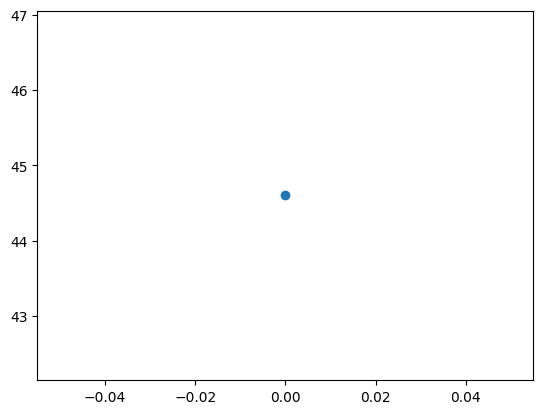

In [44]:
import matplotlib.pyplot as plt

plt.scatter(np.arange(len(equity_curve_arr)), equity_curve_arr)
for i in range(len(drawdowns)):
    if drawdowns[i] != 0:
        plt.plot(i, equity_curve_arr[i] - 10, marker='^', color='orange')
plt.show()

In [58]:
17547.4 / (60 * 60)

4.874277777777778

# BTC and ETH merging

In [100]:
df_btc = pd.read_csv(Path(r'C:/\Users/\vchar/\OneDrive/\Desktop/\ML Projects/\Upwork/\AlgoT_ML_Dev/\GrammarEvolution/\PonyGE2/\datasets/\BTC-1m.csv'))
# df_btc = pd.read_csv('/kaggle/input/btcusd-test/BTCUSD_ohlcv.csv')
df_btc['datetime'] = pd.to_datetime(df_btc['datetime'])
df_btc = df_btc.iloc[-10000:]
df_btc.sort_values('datetime', ascending=True, inplace=True)
df_btc.reset_index(inplace=True, drop=True)
df_btc.rename(
    columns={
        'open': 'btc_open', 
        'close': 'btc_close', 
        'low': 'btc_low', 
        'high': 'btc_high', 
        'volume': 'btc_volume'
    },
    inplace=True
)
df_btc.head()

,datetime,btc_open,btc_high,btc_low,btc_close,btc_volume
0,2024-09-04 17:50:00,58052.27,58055.91,57961.70,57975.48,6.286958
1,2024-09-04 17:51:00,57975.48,58014.30,57945.01,57948.03,13.541664
2,2024-09-04 17:52:00,57948.03,57948.03,57888.06,57892.97,11.412409
3,2024-09-04 17:53:00,57889.36,57898.18,57836.55,57857.49,6.163645
4,2024-09-04 17:54:00,57857.51,57915.60,57857.51,57912.29,8.040556


In [101]:
df_btc.tail()

,datetime,btc_open,btc_high,btc_low,btc_close,btc_volume
9995,2024-09-11 16:25:00,56864.38,56923.75,56847.32,56903.83,12.777984
9996,2024-09-11 16:26:00,56904.37,56916.37,56788.22,56808.40,10.192957
9997,2024-09-11 16:27:00,56804.54,56821.79,56787.89,56798.19,2.912109
9998,2024-09-11 16:28:00,56798.19,56831.83,56793.29,56830.72,3.706732
9999,2024-09-11 16:29:00,56828.08,56864.97,56828.08,56848.40,3.865301


In [102]:
df_eth = pd.read_csv(Path(r'C:/\Users/\vchar/\OneDrive/\Desktop/\ML Projects/\Upwork/\AlgoT_ML_Dev/\GrammarEvolution/\PonyGE2/\datasets/\ETH-1m.csv'))
# df_eth = pd.read_csv('/kaggle/input/btcusd-test/BTCUSD_ohlcv.csv')
df_eth['datetime'] = pd.to_datetime(df_eth['datetime'])
df_eth = df_eth.iloc[-10000:]
df_eth.sort_values('datetime', ascending=True, inplace=True)
df_eth.reset_index(inplace=True, drop=True)
df_eth.rename(
    columns={
        'open': 'eth_open', 
        'close': 'eth_close', 
        'low': 'eth_low', 
        'high': 'eth_high', 
        'volume': 'eth_volume'
    },
    inplace=True
)
df_eth.head()

,datetime,eth_open,eth_high,eth_low,eth_close,eth_volume
0,2024-09-07 14:22:00,2295.48,2295.48,2292.22,2292.22,8.133025
1,2024-09-07 14:23:00,2292.23,2293.17,2291.09,2292.84,18.279947
2,2024-09-07 14:24:00,2292.75,2293.33,2291.55,2292.98,12.682892
3,2024-09-07 14:25:00,2292.98,2293.07,2291.24,2292.00,29.546565
4,2024-09-07 14:26:00,2291.81,2294.84,2291.80,2294.80,7.415414


In [103]:
df_eth.tail()

,datetime,eth_open,eth_high,eth_low,eth_close,eth_volume
9995,2024-09-14 12:57:00,2421.30,2421.45,2420.28,2421.45,37.802834
9996,2024-09-14 12:58:00,2421.39,2421.44,2421.02,2421.24,3.580702
9997,2024-09-14 12:59:00,2421.24,2421.70,2421.12,2421.44,15.611558
9998,2024-09-14 13:00:00,2421.46,2421.52,2420.57,2421.40,10.753724
9999,2024-09-14 13:01:00,2421.26,2421.29,2420.61,2420.61,4.673591


In [104]:
df_sol = pd.read_csv(Path(r'C:/\Users/\vchar/\OneDrive/\Desktop/\ML Projects/\Upwork/\AlgoT_ML_Dev/\GrammarEvolution/\PonyGE2/\datasets/\SOL-1m.csv'))
# df_sol = pd.read_csv('/kaggle/input/btcusd-test/BTCUSD_ohlcv.csv')
df_sol['datetime'] = pd.to_datetime(df_sol['datetime'])
df_sol = df_sol.iloc[-10000:]
df_sol.sort_values('datetime', ascending=True, inplace=True)
df_sol.reset_index(inplace=True, drop=True)
df_sol.rename(
    columns={
        'open': 'sol_open', 
        'close': 'sol_close', 
        'low': 'sol_low', 
        'high': 'sol_high', 
        'volume': 'sol_volume'
    },
    inplace=True
)
df_sol.head()

,datetime,sol_open,sol_high,sol_low,sol_close,sol_volume
0,2023-11-22 12:01:00,54.50,54.52,54.47,54.51,475.244
1,2023-11-22 12:02:00,54.52,54.52,54.49,54.52,371.520
2,2023-11-22 12:03:00,54.50,54.63,54.50,54.63,538.134
3,2023-11-22 12:04:00,54.63,54.72,54.54,54.72,87.496
4,2023-11-22 12:05:00,54.72,54.72,54.70,54.70,4112.125


In [105]:
df_sol.tail()

,datetime,sol_open,sol_high,sol_low,sol_close,sol_volume
9995,2023-11-29 10:40:00,60.21,60.31,60.04,60.31,2471.730
9996,2023-11-29 10:41:00,60.32,60.32,60.22,60.26,417.767
9997,2023-11-29 10:42:00,60.28,60.30,60.22,60.30,541.638
9998,2023-11-29 10:43:00,60.32,60.45,60.29,60.33,1013.428
9999,2023-11-29 10:44:00,60.26,60.31,60.16,60.19,1979.268


In [106]:
# df_btc.set_index('datetime', inplace=True)
# df_eth.set_index('datetime', inplace=True)

df_m = pd.merge(df_btc, df_eth, on='datetime')
df_m.sort_values('datetime', ascending=True)
df_m.head()

,datetime,btc_open,btc_high,btc_low,btc_close,btc_volume,eth_open,eth_high,eth_low,eth_close,eth_volume
0,2024-09-07 14:22:00,54626.71,54626.71,54575.54,54587.68,3.029570,2295.48,2295.48,2292.22,2292.22,8.133025
1,2024-09-07 14:23:00,54579.67,54596.70,54557.25,54588.69,4.557107,2292.23,2293.17,2291.09,2292.84,18.279947
2,2024-09-07 14:24:00,54585.02,54605.49,54568.01,54605.49,3.003662,2292.75,2293.33,2291.55,2292.98,12.682892
3,2024-09-07 14:25:00,54605.49,54609.63,54581.65,54587.49,0.997784,2292.98,2293.07,2291.24,2292.00,29.546565
4,2024-09-07 14:26:00,54586.10,54658.16,54586.10,54658.16,2.026429,2291.81,2294.84,2291.80,2294.80,7.415414


In [107]:
df_m.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5888 entries, 0 to 5887
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    5888 non-null   datetime64[ns]
 1   btc_open    5888 non-null   float64       
 2   btc_high    5888 non-null   float64       
 3   btc_low     5888 non-null   float64       
 4   btc_close   5888 non-null   float64       
 5   btc_volume  5888 non-null   float64       
 6   eth_open    5888 non-null   float64       
 7   eth_high    5888 non-null   float64       
 8   eth_low     5888 non-null   float64       
 9   eth_close   5888 non-null   float64       
 10  eth_volume  5888 non-null   float64       
dtypes: datetime64[ns](1), float64(10)
memory usage: 506.1 KB


In [108]:
df_m.to_csv(
    Path(r'C:/\Users/\vchar/\OneDrive/\Desktop/\ML Projects/\Upwork/\AlgoT_ML_Dev/\GrammarEvolution/\PonyGE2/\datasets/\BTC-ETH-1m.csv'),
    index=False
)

# Merging the data

In [2]:
448797 - (2 * 52 * (24 * 60) + 5 * 52 * (15 * 60))

65037

In [4]:
main_path = Path(r'C:/\Users/\vchar/\Downloads/\FULL DATA LIBRARY')

files_list = os.listdir(main_path)
files_list

['6E_1m_databento_symbol_final_1min.csv',
 'AAPL_1m_databento.csv',
 'AAV-1m-1000wks-data.csv',
 'AMZN_1m_databento.csv',
 'BTC-1m-1000wks-data.csv',
 'CL_1m_databento_symbol_final_1min.csv',
 'COIN_1m_databento.csv',
 'DOG-1m-1000wks-data.csv',
 'ES_1m_databento_symbol_final_1min.csv',
 'ETH-1m-1000wks-data.csv_backup.csv',
 'FET-1m-1000wks-data.csv_backup.csv',
 'GC_1m_databento_symbol_final_1min.csv',
 'GOOGL_1m_databento.csv',
 'INJ-1m-1000wks-data.csv',
 'LIN-1m-1000wks-data.csv_backup.csv',
 'META_1m_databento.csv',
 'MSFT_1m_databento.csv',
 'NG_1m_databento_symbol_final_1min.csv',
 'NQ_1m_databento_symbol_final_1min.csv',
 'NVDA_1m_databento.csv',
 'PLTR_1m_databento.csv',
 'SOL-1m-1000wks-data.csv_backup.csv',
 'SUI-1m-1000wks-data.csv',
 'TIA-1m-1000wks-data.csv',
 'TSLA_1m_databento.csv',
 'XRP-1m-1000wks-data.csv',
 'ZF_1m_databento_symbol_final_1min.csv',
 'ZN_1m_databento_symbol_final_1min.csv']

In [5]:
# final_df = pd.DataFrame()

final_df = pd.read_csv(os.path.join(main_path, files_list[4]))
instrument_name = files_list[4].replace('-', '_').split('_')[0].lower()
final_df['datetime'] = pd.to_datetime(final_df['datetime'])
final_df.sort_values('datetime', ascending=True, inplace=True)
final_df.reset_index(inplace=True, drop=True)
final_df.rename(
    columns={
        'open': f'{instrument_name}_open', 
        'close': f'{instrument_name}_close', 
        'low': f'{instrument_name}_low', 
        'high': f'{instrument_name}_high', 
        'volume': f'{instrument_name}_volume'
    },
    inplace=True
)

final_df.set_index('datetime', inplace=True)
complete_time_index = pd.date_range(start=final_df.index.min(), end=final_df.index.max(), freq='min')
final_df = final_df.reindex(complete_time_index)
final_df = final_df.ffill()
final_df.reset_index(inplace=True)
final_df.rename(columns={'index': 'datetime'}, inplace=True)

for i in range(len(files_list)):
    if i in [4, 9, 21]:
        if i != 4:
            print(f"{files_list[i]} doesn't contain overlapping data.")
        continue
    temp_df = pd.read_csv(os.path.join(main_path, files_list[i]))
    instrument_name = files_list[i].replace('-', '_').split('_')[0].lower()
    temp_df['datetime'] = pd.to_datetime(temp_df['datetime'])
    temp_df.sort_values('datetime', ascending=True, inplace=True)
    # temp_df.set_index('datetime', inplace=True)
    temp_df.reset_index(inplace=True, drop=True)
    temp_df.rename(
        columns={
            'open': f'{instrument_name}_open', 
            'close': f'{instrument_name}_close', 
            'low': f'{instrument_name}_low', 
            'high': f'{instrument_name}_high', 
            'volume': f'{instrument_name}_volume'
        },
        inplace=True
    )
    # print(f"{i}: {files_list[i]}: start_date = {temp_df.iloc[0]['datetime']} end_date = {temp_df.iloc[-1]['datetime']}")
    # if i == 0:
    #     final_df = temp_df.copy()
    # else:
    #     final_df = pd.merge(final_df, temp_df, on='datetime')
    # temp_df.ffill(inplace=True)
    final_df = pd.merge(final_df, temp_df, on='datetime', how='left')
    final_df.ffill(inplace=True)

    if final_df.shape[0] == 0:
        print(i)

ETH-1m-1000wks-data.csv_backup.csv doesn't contain overlapping data.
SOL-1m-1000wks-data.csv_backup.csv doesn't contain overlapping data.


In [6]:
final_df.shape

(4814757, 131)

In [7]:
final_df.dropna(inplace=True)
final_df.reset_index(drop=True, inplace=True)
final_df.shape

(457520, 131)

In [8]:
# final_df['diff'] = final_df['datetime'].diff().apply(lambda x: x if pd.isna(x) else x.total_seconds()/60)

In [9]:
final_df.head()

,datetime,btc_open,btc_high,btc_low,btc_close,btc_volume,6e_open,6e_high,6e_low,6e_close,...,zf_open,zf_high,zf_low,zf_close,zf_volume,zn_open,zn_high,zn_low,zn_close,zn_volume
0,2023-11-01 18:14:00,34553.59,34565.88,34546.16,34549.35,6.687855,1.0557,1.05570,1.05515,1.05520,...,104.867188,104.867188,104.843750,104.843750,1640.0,106.750000,106.765625,106.703125,106.703125,2238.0
1,2023-11-01 18:15:00,34549.33,34552.58,34507.30,34507.39,14.284419,1.0552,1.05530,1.05465,1.05465,...,104.843750,104.851562,104.828125,104.835938,6235.0,106.718750,106.734375,106.703125,106.703125,4672.0
2,2023-11-01 18:16:00,34507.49,34525.83,34486.81,34522.14,7.825300,1.0546,1.05505,1.05445,1.05505,...,104.835938,104.859375,104.835938,104.851562,2477.0,106.703125,106.734375,106.687500,106.734375,2382.0
3,2023-11-01 18:17:00,34522.14,34530.14,34500.18,34526.96,7.512638,1.0550,1.05525,1.05490,1.05515,...,104.851562,104.867188,104.843750,104.851562,3767.0,106.734375,106.750000,106.734375,106.750000,2937.0
4,2023-11-01 18:18:00,34526.20,34545.63,34525.18,34540.48,13.100650,1.0551,1.05535,1.05510,1.05530,...,104.851562,104.859375,104.851562,104.851562,1634.0,106.734375,106.750000,106.734375,106.734375,962.0


In [10]:
final_df.tail()

,datetime,btc_open,btc_high,btc_low,btc_close,btc_volume,6e_open,6e_high,6e_low,6e_close,...,zf_open,zf_high,zf_low,zf_close,zf_volume,zn_open,zn_high,zn_low,zn_close,zn_volume
457515,2024-09-14 11:29:00,59835.10,59835.10,59805.98,59819.64,2.781430,1.11185,1.11185,1.11175,1.11185,...,110.625,110.632812,110.617188,110.625,1569.0,115.390625,115.390625,115.375,115.390625,641.0
457516,2024-09-14 11:30:00,59815.61,59825.88,59805.44,59813.19,0.866345,1.11185,1.11185,1.11175,1.11185,...,110.625,110.632812,110.617188,110.625,1569.0,115.390625,115.390625,115.375,115.390625,641.0
457517,2024-09-14 11:31:00,59811.70,59827.60,59805.43,59827.18,2.052995,1.11185,1.11185,1.11175,1.11185,...,110.625,110.632812,110.617188,110.625,1569.0,115.390625,115.390625,115.375,115.390625,641.0
457518,2024-09-14 11:32:00,59827.17,59833.78,59824.37,59831.64,1.489819,1.11185,1.11185,1.11175,1.11185,...,110.625,110.632812,110.617188,110.625,1569.0,115.390625,115.390625,115.375,115.390625,641.0
457519,2024-09-14 11:33:00,59831.64,59836.10,59831.64,59836.10,0.078481,1.11185,1.11185,1.11175,1.11185,...,110.625,110.632812,110.617188,110.625,1569.0,115.390625,115.390625,115.375,115.390625,641.0


In [11]:
final_df.shape

(457520, 131)

In [12]:
np.unique([i.split('_')[0] for i in final_df.columns])

array(['6e', 'aapl', 'aav', 'amzn', 'btc', 'cl', 'coin', 'datetime',
       'dog', 'es', 'fet', 'gc', 'googl', 'inj', 'lin', 'meta', 'msft',
       'ng', 'nq', 'nvda', 'pltr', 'sui', 'tia', 'tsla', 'xrp', 'zf',
       'zn'], dtype='<U8')

In [13]:
final_df.to_csv("all_data_1min.csv", index=False)

In [ ]:
inst_list = [
    '6e', 'aapl', 'aav', 'amzn', 'btc', 'cl', 'coin',
    'dog', 'es', 'fet', 'gc', 'googl', 'inj', 'lin', 'meta', 'msft',
    'ng', 'nq', 'nvda', 'pltr', 'sui', 'tia', 'tsla', 'xrp', 'zf',
    'zn'
]

prefix_txt = '{:{:'
suffix_txt = ':}:}{::}'
it_txt = '_{i}'

for instrument in inst_list:

    if instrument == 'btc':
        continue

    text_template = f'''{prefix_txt}df[f"'"{instrument}_close{it_txt}"'"] = df["'"{instrument}_close"'"].shift(i){suffix_txt}
    {prefix_txt}df[f"'"{instrument}_open{it_txt}"'"] = df["'"{instrument}_open"'"].shift(i){suffix_txt}
    {prefix_txt}df[f"'"{instrument}_high{it_txt}"'"] = df["'"{instrument}_high"'"].shift(i){suffix_txt}
    {prefix_txt}df[f"'"{instrument}_low{it_txt}"'"] = df["'"{instrument}_low"'"].shift(i){suffix_txt}
    {prefix_txt}df[f"'"{instrument}_volume{it_txt}"'"] = df["'"{instrument}_volume"'"].shift(i){suffix_txt}'''

    print(text_template)

In [ ]:
inst_list = [
    '6e', 'aapl', 'aav', 'amzn', 'btc', 'cl', 'coin',
    'dog', 'es', 'fet', 'gc', 'googl', 'inj', 'lin', 'meta', 'msft',
    'ng', 'nq', 'nvda', 'pltr', 'sui', 'tia', 'tsla', 'xrp', 'zf',
    'zn'
]

for instrument in inst_list:

    if instrument == 'btc':
        continue

    txt_temp = f'''| df["'"{instrument}_close"'"].values.reshape(-1, 1) 
    | df["'"{instrument}_open"'"].values.reshape(-1, 1) 
    | df["'"{instrument}_high"'"].values.reshape(-1, 1) 
    | df["'"{instrument}_low"'"].values.reshape(-1, 1)
    | df["'"{instrument}_volume"'"].values.reshape(-1, 1)
    | df["'"{instrument}_close_1"'"].values.reshape(-1, 1) 
    | df["'"{instrument}_open_1"'"].values.reshape(-1, 1) 
    | df["'"{instrument}_high_1"'"].values.reshape(-1, 1) 
    | df["'"{instrument}_low_1"'"].values.reshape(-1, 1)
    | df["'"{instrument}_volume_1"'"].values.reshape(-1, 1)
    | df["'"{instrument}_close_2"'"].values.reshape(-1, 1) 
    | df["'"{instrument}_open_2"'"].values.reshape(-1, 1) 
    | df["'"{instrument}_high_2"'"].values.reshape(-1, 1) 
    | df["'"{instrument}_low_2"'"].values.reshape(-1, 1)
    | df["'"{instrument}_volume_2"'"].values.reshape(-1, 1)
    | df["'"{instrument}_close_3"'"].values.reshape(-1, 1) 
    | df["'"{instrument}_open_3"'"].values.reshape(-1, 1) 
    | df["'"{instrument}_high_3"'"].values.reshape(-1, 1) 
    | df["'"{instrument}_low_3"'"].values.reshape(-1, 1)
    | df["'"{instrument}_volume_3"'"].values.reshape(-1, 1)
    | df["'"{instrument}_close_4"'"].values.reshape(-1, 1) 
    | df["'"{instrument}_open_4"'"].values.reshape(-1, 1) 
    | df["'"{instrument}_high_4"'"].values.reshape(-1, 1) 
    | df["'"{instrument}_low_4"'"].values.reshape(-1, 1)
    | df["'"{instrument}_volume_4"'"].values.reshape(-1, 1)
    | df["'"{instrument}_close_5"'"].values.reshape(-1, 1) 
    | df["'"{instrument}_open_5"'"].values.reshape(-1, 1) 
    | df["'"{instrument}_high_5"'"].values.reshape(-1, 1) 
    | df["'"{instrument}_low_5"'"].values.reshape(-1, 1)
    | df["'"{instrument}_volume_5"'"].values.reshape(-1, 1)'''

    print(txt_temp)

# Extracting strategy from the code

In [11]:
import re 

text = '''def fun(price_data):
  import pandas as pd
  import numpy as np
  from fitness.indicators import indicators
  from numba import njit
  @njit
  def merge_pnl(arr1, arr2):
    out = np.zeros((len(arr1) + len(arr2)))
    idx = 1
    for i in range(len(arr1) + len(arr2)):
      if i % 2 == 0:
        out[i] = arr1[int(i/2)]
      else:
        out[i] = arr2[i-idx]
      idx += 1
    return out
  @njit
  def get_drawdowns(arr):
    drawdowns = np.zeros((len(arr)))
    max = arr[0]
    for i in range(1, len(drawdowns)-1):
      if arr[i-1] > arr[i] and arr[i] < arr[i+1]:
        min = arr[i]
        drawdowns[i] = max - min
      elif arr[i-1] < arr[i] and arr[i] > arr[i+1]:
        max = arr[i]
    return drawdowns
  df = price_data.copy()
  df['buy'] = (indicators.RSI(df=data, HistLength=10).values < 20).astype(int)
  df['sell'] = (indicators.RSI(df=data, HistLength=10).values > 80).astype(int)
  df['signal'] = df['buy'] + df['sell']
  df['signal'] = df['signal'].apply(lambda x: 1 if x==1 else 0)
  df['sell'] = df['sell'] * (-1)
  df['signal'] = df['signal'] * df['sell']
  df['signal'] = df['signal'] + df['buy']
  df.drop(columns=['buy', 'sell'], inplace=True)
  buy_idxs = []
  sell_idxs = []
  is_buy = 0
  is_sell = 0
  for i, row in enumerate(df.itertuples()):
    if row.signal == 1 and is_buy == 0:
      buy_idxs.append(i+1)
      is_buy = 1
      is_sell = 0
    elif row.signal == -1 and is_sell == 0:
      sell_idxs.append(i+1)
      is_sell = 1
      is_buy = 0
  if len(buy_idxs) > len(sell_idxs):
    buy_idxs = buy_idxs[:-(len(buy_idxs) - len(sell_idxs))]
  elif len(buy_idxs) < len(sell_idxs):
    sell_idxs = sell_idxs[:-(len(sell_idxs) - len(buy_idxs))]
  if len(buy_idxs) == 0 or len(sell_idxs) == 0:
    return 999
  buy_prices = df[df.index.isin(buy_idxs)]['open'].values
  sell_prices = df[df.index.isin(sell_idxs)]['open'].values
  if buy_idxs[0] < sell_idxs[0]:
    buy_pnl = np.sum(sell_prices - buy_prices)
    sell_pnl = np.sum(sell_prices[:-1] - buy_prices[1:])
    buy_arr = sell_prices - buy_prices
    sell_arr = sell_prices[:-1] - buy_prices[1:]
    all_arr = merge_pnl(buy_arr, sell_arr)
  else:
    sell_pnl = np.sum(sell_prices - buy_prices)
    buy_pnl = np.sum(sell_prices[1:] - buy_prices[:-1])
    sell_arr = sell_prices - buy_prices
    buy_arr = sell_prices[1:] - buy_prices[:-1]
    all_arr = merge_pnl(sell_arr, buy_arr)
  total_pnl = buy_pnl + sell_pnl
  equity_curve_arr = np.cumsum(all_arr)
  drawdowns = get_drawdowns(equity_curve_arr)
  avg_drawdown = np.sum(drawdowns[drawdowns!=0]) / len(drawdowns[drawdowns!=0])
  fitness = total_pnl / avg_drawdown
  if np.isnan(fitness):
    return 999
  return -fitness
fitness = fun(data)'''

re.findall(r"df\[\'buy\'\] = \((.*)\)\.astype\(int\)", text)

['indicators.RSI(df=data, HistLength=10).values < 20']

In [12]:
re.findall(r"df\[\'sell\'\] = \((.*)\)\.astype\(int\)", text)

['indicators.RSI(df=data, HistLength=10).values > 80']

In [ ]:
@njit(cache=True)
def get_pnl(
    trade_close_prices,
    trade_open_prices,
    commission=0.015,
    slippage=0.05,
    init_inv=20000,
    trade_size=0.1,
    is_buy=1
):

    pnl_list = np.zeros(len(trade_close_prices))

    for i in range(len(trade_close_prices)):
        
        temp_n_assets = int(init_inv * trade_size / trade_open_prices[i])
        if is_buy == 1:
            temp_pnl = temp_n_assets * (trade_close_prices[i] - trade_open_prices[i] * (1 + slippage))
        else:
            temp_pnl = -temp_n_assets * (trade_close_prices[i] - trade_open_prices[i] * (1 - slippage))
        temp_pnl = temp_pnl * (1 - commission)
        init_inv += temp_pnl

        pnl_list[i] = temp_pnl

    return pnl_list

In [31]:
def fun(price_data):
  import pandas as pd
  import numpy as np
  # from fitness.indicators import indicators
  from numba import njit
  COMMISSION = 0.015
  SLIPPAGE = 0.00005
  AVAILABLE_CAPITAL = 700000
  TRADE_SIZE = 0.5
  @njit
  def merge_pnl(arr1, arr2):
    out = np.zeros((len(arr1) + len(arr2)))
    idx = 1
    for i in range(len(arr1) + len(arr2)):
      if i % 2 == 0:
        out[i] = arr1[int(i/2)]
      else:
        out[i] = arr2[i-idx]
      idx += 1
    return out
  @njit
  def get_drawdowns(arr):
    drawdowns = np.zeros((len(arr)))
    max = arr[0]
    for i in range(1, len(drawdowns)-1):
      if arr[i-1] > arr[i] and arr[i] < arr[i+1]:
        min = arr[i]
        drawdowns[i] = max - min
      elif arr[i-1] < arr[i] and arr[i] > arr[i+1]:
        max = arr[i]
    return drawdowns
  @njit
  def get_pnl(trade_close_prices, trade_open_prices, commission, slippage, init_inv, trade_size, is_buy):
    pnl_list = np.zeros(len(trade_close_prices))
    for i in range(len(trade_close_prices)):
      temp_n_assets = int(init_inv * trade_size / trade_open_prices[i])
      if is_buy == 1:
        temp_pnl = temp_n_assets * (trade_close_prices[i] - trade_open_prices[i] * (1 + slippage))
      else:
        temp_pnl = -temp_n_assets * (trade_close_prices[i] - trade_open_prices[i] * (1 - slippage))
      temp_pnl = temp_pnl * (1 - commission)
      init_inv += temp_pnl
      pnl_list[i] = temp_pnl
    return pnl_list
  df = price_data.copy()
  for i in range(1, 6):
    df[f'close_{i}'] = df['close'].shift(i)
    df[f'open_{i}'] = df['open'].shift(i)
    df[f'high_{i}'] = df['high'].shift(i)
    df[f'low_{i}'] = df['low'].shift(i)
    df[f'volume_{i}'] = df['volume'].shift(i)
  df.dropna(inplace=True)
  df.reset_index(drop=True, inplace=True)
  df['buy'] = (RSI(df=df, HistLength=10).values < 20).astype(int)
  df['sell'] = (RSI(df=df, HistLength=10).values > 80).astype(int)
  df['signal'] = df['buy'] + df['sell']
  df['signal'] = df['signal'].apply(lambda x: 1 if x==1 else 0)
  df['sell'] = df['sell'] * (-1)
  df['signal'] = df['signal'] * df['sell']
  df['signal'] = df['signal'] + df['buy']
  df.drop(columns=['buy', 'sell'], inplace=True)
  buy_idxs = []
  sell_idxs = []
  is_buy = 0
  is_sell = 0
  for i, row in enumerate(df.itertuples()):
    if row.signal == 1 and is_buy == 0:
      buy_idxs.append(i+1)
      is_buy = 1
      is_sell = 0
    elif row.signal == -1 and is_sell == 0:
      sell_idxs.append(i+1)
      is_sell = 1
      is_buy = 0
  if len(buy_idxs) > len(sell_idxs):
    buy_idxs = buy_idxs[:-(len(buy_idxs) - len(sell_idxs))]
  elif len(buy_idxs) < len(sell_idxs):
    sell_idxs = sell_idxs[:-(len(sell_idxs) - len(buy_idxs))]
  if len(buy_idxs) == 0 or len(sell_idxs) == 0:
    return 999
  buy_prices = df[df.index.isin(buy_idxs)]['open'].values
  sell_prices = df[df.index.isin(sell_idxs)]['open'].values
  if buy_idxs[0] < sell_idxs[0]:
    buy_arr = get_pnl(sell_prices, buy_prices, COMMISSION, SLIPPAGE, AVAILABLE_CAPITAL, TRADE_SIZE, 1)
    buy_pnl = np.sum(buy_arr)
    sell_arr = get_pnl(buy_prices[1:], sell_prices[:-1], COMMISSION, SLIPPAGE, AVAILABLE_CAPITAL, TRADE_SIZE, 0)
    sell_pnl = np.sum(sell_arr)
    all_arr = merge_pnl(buy_arr, sell_arr)
  else:
    sell_arr = get_pnl(buy_prices, sell_prices, COMMISSION, SLIPPAGE, AVAILABLE_CAPITAL, TRADE_SIZE, 0)
    sell_pnl = np.sum(sell_arr)
    buy_arr = get_pnl(sell_prices[1:], buy_prices[:-1], COMMISSION, SLIPPAGE, AVAILABLE_CAPITAL, TRADE_SIZE, 1)
    buy_pnl = np.sum(buy_arr)
    all_arr = merge_pnl(sell_arr, buy_arr)
  total_pnl = buy_pnl + sell_pnl
  equity_curve_arr = np.cumsum(all_arr)
  drawdowns = get_drawdowns(equity_curve_arr)
  avg_drawdown = np.sum(drawdowns[drawdowns!=0]) / len(drawdowns[drawdowns!=0])
  fitness = total_pnl / avg_drawdown
  if np.isnan(fitness):
    return -999
  return -fitness
# fitness = fun(df)

# Limited testing

In [81]:
import pandas as pd
import numpy as np
from src.fitness.indicators import indicators
from numba import njit
COMMISSION = 0.015
SLIPPAGE = 0.00005
AVAILABLE_CAPITAL = 700000
TRADE_SIZE = 0.5

@njit
def merge_pnl(arr1, arr2):
    out = np.zeros((len(arr1) + len(arr2)))
    idx = 1
    for i in range(len(arr1) + len(arr2)):
        if i % 2 == 0:
            out[i] = arr1[int(i/2)]
        else:
            out[i] = arr2[i-idx]
        idx += 1
    return out

@njit
def get_drawdowns(arr):
    drawdowns = np.zeros((len(arr)))
    max = arr[0]
    for i in range(1, len(drawdowns)-1):
        if arr[i-1] > arr[i] and arr[i] < arr[i+1]:
            min = arr[i]
            drawdowns[i] = max - min
        elif arr[i-1] < arr[i] and arr[i] > arr[i+1]:
            max = arr[i]
    return drawdowns

@njit
def get_pnl(trade_close_prices, trade_open_prices, commission, slippage, init_inv, trade_size, is_buy):
    pnl_list = np.zeros(len(trade_close_prices))
    for i in range(len(trade_close_prices)):
        temp_n_assets = int(init_inv * trade_size / trade_open_prices[i])
        if is_buy == 1:
            temp_pnl = temp_n_assets * (trade_close_prices[i] - trade_open_prices[i] * (1 + slippage))
        else:
            temp_pnl = -temp_n_assets * (trade_close_prices[i] - trade_open_prices[i] * (1 - slippage))
        temp_pnl = temp_pnl * (1 - commission)
        init_inv += temp_pnl
        pnl_list[i] = temp_pnl
    return pnl_list

# df = price_data.copy()
# for i in range(1, 6):
#     df[f'close_{i}'] = df['close'].shift(i)
#     df[f'open_{i}'] = df['open'].shift(i)
#     df[f'high_{i}'] = df['high'].shift(i)
#     df[f'low_{i}'] = df['low'].shift(i)
#     df[f'volume_{i}'] = df['volume'].shift(i)
# df.dropna(inplace=True)
# df.reset_index(drop=True, inplace=True)

df['buy'] = (indicators.RSI(df=df, HistLength=10).values < 20).astype(int)
df['sell'] = (indicators.RSI(df=df, HistLength=10).values > 80).astype(int)
df['signal'] = df['buy'] + df['sell']
df['signal'] = df['signal'].apply(lambda x: 1 if x==1 else 0)
df['sell'] = df['sell'] * (-1)
df['signal'] = df['signal'] * df['sell']
df['signal'] = df['signal'] + df['buy']
df.drop(columns=['buy', 'sell'], inplace=True)

buy_idxs = []
sell_idxs = []
is_buy = 0
is_sell = 0
for i, row in enumerate(df.itertuples()):
    if row.signal == 1 and is_buy == 0:
        buy_idxs.append(i+1)
        is_buy = 1
        is_sell = 0
    elif row.signal == -1 and is_sell == 0:
        sell_idxs.append(i+1)
        is_sell = 1
        is_buy = 0

if len(buy_idxs) > len(sell_idxs):
    buy_idxs = buy_idxs[:-(len(buy_idxs) - len(sell_idxs))]
elif len(buy_idxs) < len(sell_idxs):
    sell_idxs = sell_idxs[:-(len(sell_idxs) - len(buy_idxs))]

if len(buy_idxs) == 0 or len(sell_idxs) == 0:
    print("not enough signals")

buy_prices = df[df.index.isin(buy_idxs)]['open'].values
sell_prices = df[df.index.isin(sell_idxs)]['open'].values

if buy_idxs[0] < sell_idxs[0]:
    buy_arr = get_pnl(sell_prices, buy_prices, COMMISSION, SLIPPAGE, AVAILABLE_CAPITAL, TRADE_SIZE, 1)
    buy_pnl = np.sum(buy_arr)
    sell_arr = get_pnl(buy_prices[1:], sell_prices[:-1], COMMISSION, SLIPPAGE, AVAILABLE_CAPITAL, TRADE_SIZE, 0)
    sell_pnl = np.sum(sell_arr)
    all_arr = merge_pnl(buy_arr, sell_arr)
else:
    sell_arr = get_pnl(buy_prices, sell_prices, COMMISSION, SLIPPAGE, AVAILABLE_CAPITAL, TRADE_SIZE, 0)
    sell_pnl = np.sum(sell_arr)
    buy_arr = get_pnl(sell_prices[1:], buy_prices[:-1], COMMISSION, SLIPPAGE, AVAILABLE_CAPITAL, TRADE_SIZE, 1)
    buy_pnl = np.sum(buy_arr)
    all_arr = merge_pnl(sell_arr, buy_arr)

total_pnl = buy_pnl + sell_pnl
equity_curve_arr = np.cumsum(all_arr)
drawdowns = get_drawdowns(equity_curve_arr)
avg_drawdown = np.sum(drawdowns[drawdowns!=0]) / len(drawdowns[drawdowns!=0])
fitness = total_pnl / avg_drawdown

In [82]:
print(buy_idxs)

[95, 396, 525, 609, 695, 732, 918, 1088, 1228, 1439, 1566, 1801, 1890, 2061, 2272, 2433, 2521, 2833, 2882, 2970, 3097, 3473, 3764, 3836, 4088, 4427, 4583, 4804, 4939, 5012, 5173, 5220, 5534, 5850, 5965, 6254, 6598, 6674, 6807, 7125, 7336, 7440, 7521, 7584, 7781, 7910, 8080, 8191, 8462, 8622, 8753, 8948, 9091, 9375, 9488]


In [83]:
print(sell_idxs)

[15, 373, 496, 574, 651, 711, 801, 972, 1107, 1376, 1526, 1747, 1870, 1993, 2198, 2294, 2481, 2579, 2860, 2948, 3024, 3242, 3510, 3782, 3990, 4205, 4549, 4720, 4831, 4985, 5061, 5209, 5301, 5701, 5893, 6023, 6311, 6630, 6758, 6931, 7318, 7413, 7488, 7566, 7650, 7876, 8012, 8094, 8297, 8496, 8730, 8865, 9012, 9281, 9433]


In [11]:
len(buy_idxs), len(sell_idxs)

(55, 55)

In [12]:
signal_idxs = buy_idxs.copy()
signal_idxs.extend(sell_idxs)
signal_idxs = sorted(signal_idxs)
print(signal_idxs)

[15, 95, 373, 396, 496, 525, 574, 609, 651, 695, 711, 732, 801, 918, 972, 1088, 1107, 1228, 1376, 1439, 1526, 1566, 1747, 1801, 1870, 1890, 1993, 2061, 2198, 2272, 2294, 2433, 2481, 2521, 2579, 2833, 2860, 2882, 2948, 2970, 3024, 3097, 3242, 3473, 3510, 3764, 3782, 3836, 3990, 4088, 4205, 4427, 4549, 4583, 4720, 4804, 4831, 4939, 4985, 5012, 5061, 5173, 5209, 5220, 5301, 5534, 5701, 5850, 5893, 5965, 6023, 6254, 6311, 6598, 6630, 6674, 6758, 6807, 6931, 7125, 7318, 7336, 7413, 7440, 7488, 7521, 7566, 7584, 7650, 7781, 7876, 7910, 8012, 8080, 8094, 8191, 8297, 8462, 8496, 8622, 8730, 8753, 8865, 8948, 9012, 9091, 9281, 9375, 9433, 9488]


In [13]:
signal_idxs_true = [i - 1 for i in signal_idxs]
print(signal_idxs_true)

[14, 94, 372, 395, 495, 524, 573, 608, 650, 694, 710, 731, 800, 917, 971, 1087, 1106, 1227, 1375, 1438, 1525, 1565, 1746, 1800, 1869, 1889, 1992, 2060, 2197, 2271, 2293, 2432, 2480, 2520, 2578, 2832, 2859, 2881, 2947, 2969, 3023, 3096, 3241, 3472, 3509, 3763, 3781, 3835, 3989, 4087, 4204, 4426, 4548, 4582, 4719, 4803, 4830, 4938, 4984, 5011, 5060, 5172, 5208, 5219, 5300, 5533, 5700, 5849, 5892, 5964, 6022, 6253, 6310, 6597, 6629, 6673, 6757, 6806, 6930, 7124, 7317, 7335, 7412, 7439, 7487, 7520, 7565, 7583, 7649, 7780, 7875, 7909, 8011, 8079, 8093, 8190, 8296, 8461, 8495, 8621, 8729, 8752, 8864, 8947, 9011, 9090, 9280, 9374, 9432, 9487]


In [14]:
len(signal_idxs)

110

In [15]:
df['new_signal'] = 0
df.loc[df.index.isin(signal_idxs_true), 'new_signal'] = df.loc[df.index.isin(signal_idxs_true), 'signal'].values
# df.loc[~df.index.isin(signal_idxs), 'new_signal'] = 0

In [16]:
df[df['new_signal']==-1].shape

(55, 8)

In [17]:
df.loc[df.index.isin(signal_idxs_true), 'signal'].values

array([-1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1,
        1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1,
       -1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1,
        1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1,
       -1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1,
        1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1,
       -1,  1, -1,  1, -1,  1, -1,  1], dtype=int64)

In [18]:
df['signal_prices'] = 0
df.loc[df.index.isin(signal_idxs), 'signal_prices'] = df.loc[df.index.isin(signal_idxs), 'open'].values

In [19]:
df.loc[df.index.isin(signal_idxs), 'open'].values

array([16550. , 16569.6, 16568.5, 16554.5, 16536.9, 16532.7, 16543.3,
       16531.5, 16539.6, 16550.4, 16563.7, 16543.6, 16541.3, 16558.2,
       16561.6, 16570.8, 16599.9, 16569.1, 16568.7, 16548.6, 16548.2,
       16458.4, 16531.8, 16526.2, 16518.8, 16507.5, 16517.5, 16513.5,
       16496.3, 16515. , 16524.5, 16530.1, 16527.9, 16529.6, 16527.9,
       16578.7, 16604.1, 16589. , 16587.5, 16580.3, 16589.1, 16583.1,
       16564.4, 16630.3, 16685.1, 16706. , 16726.4, 16725.5, 16699.3,
       16713.8, 16711.6, 16698.5, 16691.5, 16665.2, 16679.5, 16671.6,
       16689.8, 16709.7, 16717.2, 16703.6, 16715.1, 16714.4, 16717.4,
       16703. , 16716.4, 16606.1, 16640. , 16640.1, 16664.4, 16650.4,
       16659.1, 16847.6, 16842.2, 16827. , 16842.5, 16828. , 16829. ,
       16803.7, 16873.6, 16791.5, 16826. , 16803.6, 16862.2, 16836.1,
       16834.1, 16812.5, 16829.1, 16816.5, 16819.6, 16821.1, 16812. ,
       16797. , 16809.9, 16807. , 16816.3, 16799.1, 16820. , 16801.8,
       16812. , 1682

In [20]:
signal_list = np.zeros((2, df.shape[0]))
signal_list[0][1:] = df['new_signal'].values[:-1]
signal_list[1] = df['signal_prices'].values

In [21]:
print([i for i in range(len(signal_list[0])) if signal_list[0][i] != 0])

[15, 95, 373, 396, 496, 525, 574, 609, 651, 695, 711, 732, 801, 918, 972, 1088, 1107, 1228, 1376, 1439, 1526, 1566, 1747, 1801, 1870, 1890, 1993, 2061, 2198, 2272, 2294, 2433, 2481, 2521, 2579, 2833, 2860, 2882, 2948, 2970, 3024, 3097, 3242, 3473, 3510, 3764, 3782, 3836, 3990, 4088, 4205, 4427, 4549, 4583, 4720, 4804, 4831, 4939, 4985, 5012, 5061, 5173, 5209, 5220, 5301, 5534, 5701, 5850, 5893, 5965, 6023, 6254, 6311, 6598, 6630, 6674, 6758, 6807, 6931, 7125, 7318, 7336, 7413, 7440, 7488, 7521, 7566, 7584, 7650, 7781, 7876, 7910, 8012, 8080, 8094, 8191, 8297, 8462, 8496, 8622, 8730, 8753, 8865, 8948, 9012, 9091, 9281, 9375, 9433, 9488]


In [22]:
print(signal_idxs)

[15, 95, 373, 396, 496, 525, 574, 609, 651, 695, 711, 732, 801, 918, 972, 1088, 1107, 1228, 1376, 1439, 1526, 1566, 1747, 1801, 1870, 1890, 1993, 2061, 2198, 2272, 2294, 2433, 2481, 2521, 2579, 2833, 2860, 2882, 2948, 2970, 3024, 3097, 3242, 3473, 3510, 3764, 3782, 3836, 3990, 4088, 4205, 4427, 4549, 4583, 4720, 4804, 4831, 4939, 4985, 5012, 5061, 5173, 5209, 5220, 5301, 5534, 5701, 5850, 5893, 5965, 6023, 6254, 6311, 6598, 6630, 6674, 6758, 6807, 6931, 7125, 7318, 7336, 7413, 7440, 7488, 7521, 7566, 7584, 7650, 7781, 7876, 7910, 8012, 8080, 8094, 8191, 8297, 8462, 8496, 8622, 8730, 8753, 8865, 8948, 9012, 9091, 9281, 9375, 9433, 9488]


## Entry testing

### Fixed stop and target exit

In [23]:
@njit(cache=True)
def get_exit_entry_testing1(
    close_prices, 
    open_prices,  
    signal_list,
    stoploss_th,
    takeprofit_th, 
    commission, 
    slippage, 
    init_inv, 
    trade_size
):

    exit_list = np.zeros((2, len(close_prices)))

    for i in range(len(close_prices)-1):

        if signal_list[1][i] == 0:

            pass

        else:

            temp_n_assets = int(init_inv * trade_size / signal_list[1][i])
            if signal_list[0][i] == 1:
                temp_pnl = temp_n_assets * (close_prices[i] - signal_list[1][i] * (1 + slippage))
            else:
                temp_pnl = -temp_n_assets * (close_prices[i] - signal_list[1][i] * (1 - slippage))
            temp_pnl = temp_pnl * (1 - commission)
            init_inv += temp_pnl

            if -temp_pnl >= stoploss_th or temp_pnl >= takeprofit_th:
                exit_list[0][i+1] = -signal_list[0][i]
                exit_list[1][i+1] = open_prices[i+1]
            else:
                pass
        
    return exit_list

In [24]:
exit_list = get_exit_entry_testing1(
    close_prices=df['close'].values, 
    open_prices=df['open'].values,  
    signal_list=signal_list,
    stoploss_th=50,
    takeprofit_th=100,
    commission=COMMISSION, 
    slippage=SLIPPAGE, 
    init_inv=AVAILABLE_CAPITAL, 
    trade_size=TRADE_SIZE
)

In [25]:
sum(exit_list[0]), sum(exit_list[1])

(8.0, 567961.2)

In [26]:
np.sum(np.where(exit_list[0]!=0, 1, 0)), np.sum(np.where(exit_list[1]!=0, 1, 0))

(34, 34)

In [27]:
exit_list[1][exit_list[1]!=0]

array([16579. , 16538.8, 16569.5, 16562.8, 16562. , 16550. , 16490.6,
       16526.3, 16585.7, 16587.5, 16628.7, 16721.4, 16713.5, 16710.3,
       16716.5, 16685.4, 16633.6, 16636.5, 16668.5, 16844.7, 16844.9,
       16801. , 16862.8, 16828.4, 16812.1, 16831.4, 16794.6, 16812.6,
       16838.9, 16816. , 16827.3, 16819.9, 16798.8, 16761.2])

In [28]:
@njit(cache=True)
def get_signals(signal_list, exit_list):

    start_idx = 0
    exit_idx = 0
   
    for i in range(len(signal_list[0])):

        if i == start_idx:

            if signal_list[0][i] == 0:

                start_idx += 1

                exit_list[0][i] = 0

            else:

                for j in range(i+1, len(exit_list[0])):
                    if exit_list[0][j] == -signal_list[0][i]:
                        exit_idx = j
                        break
                    else:
                        exit_idx = j

                for k in range(i+1, exit_idx+1):
                    if signal_list[0][k] == -signal_list[0][i]:
                        exit_idx = k
                        exit_list[1][k] = signal_list[1][k]
                        break
                    else:
                        exit_idx = k

                for p in range(i+1, exit_idx):
                    signal_list[0][p] = 0
                    exit_list[0][p] = 0
                
                if exit_idx == len(signal_list[0]) - 1 and exit_list[0][exit_idx] != -signal_list[0][i]:
                    exit_list[0][exit_idx] = 0
                    exit_list[0][i] = 0
                    signal_list[0][exit_idx] = 0
                else:
                    exit_list[0][exit_idx] = -signal_list[0][i]
                    exit_list[0][i] = 0
                    signal_list[0][exit_idx] = 0
                
                start_idx = exit_idx + 1

        else:

            continue

    if sum(np.abs(signal_list[0])) == sum(np.abs(exit_list[0])):

        return signal_list, exit_list
    
    else:

        for i in range(len(signal_list[0])):
            if signal_list[0][-(i+1)] != 0:
                signal_list[0][-(i+1)] = 0
                break

        return signal_list, exit_list
    
@njit(cache=True)
def create_position_open_prices(signal_list, exit_list):

    pos_open_prices = np.zeros(len(signal_list[0]))
    pos_exit_prices = np.zeros(len(exit_list[0]))

    start_idx = 0
    price_idx = 0

    for i in range(len(signal_list[0])):
        if exit_list[0][i] != 0:
            for j in range(start_idx, i):
                if signal_list[0][j] != 0:
                    price_idx = j
                    break
            pos_open_prices[i] = signal_list[1][price_idx]
            pos_exit_prices[i] = exit_list[1][i]
            start_idx = i
        else:
            pass

    return pos_open_prices, pos_exit_prices

In [95]:
@njit(cache=True)
def get_pnl_testing(
    trade_close_prices,
    signal_list, 
    trade_open_prices,
    commission=0.015,
    slippage=0.05,
    init_inv=20000,
    trade_size=0.1
):

    pnl_list = np.zeros(len(trade_close_prices))

    for i in range(len(trade_close_prices)):

        if signal_list[i] == 0 or trade_open_prices[i] == 0:
            pass
        
        # signal_list contains the points where exit occurs
        elif signal_list[i] == -1: 
            temp_n_assets = int(init_inv * trade_size / trade_open_prices[i])
            temp_pnl = temp_n_assets * (trade_close_prices[i] - trade_open_prices[i] * (1 + slippage)) 
            temp_pnl = temp_pnl * (1 - commission)
            init_inv += temp_pnl

        else:
            temp_n_assets = int(init_inv * trade_size / trade_open_prices[i])
            temp_pnl = temp_n_assets * (trade_open_prices[i] * (1 - slippage) - trade_close_prices[i])
            temp_pnl = temp_pnl * (1 - commission)
            init_inv += temp_pnl

        pnl_list[i] = temp_pnl

    return pnl_list

In [30]:
signal_list, exit_list = get_signals(signal_list, exit_list)
pos_open_prices, pos_exit_prices = create_position_open_prices(signal_list, exit_list)

pnl_list = get_pnl_testing(
    trade_close_prices=pos_exit_prices,
    signal_list=exit_list[0], 
    trade_open_prices=pos_open_prices,
    commission=COMMISSION, 
    slippage=SLIPPAGE, 
    init_inv=AVAILABLE_CAPITAL, 
    trade_size=TRADE_SIZE
)

winning_percent = 100 * sum(pnl_list > 0) / len(pnl_list)
winning_percent

57.410714285714285

In [31]:
winning_percent = 100 * sum(pnl_list > 0) / np.sum(np.where(pnl_list!=0, 1, 0))
winning_percent

57.501987281399046

In [32]:
np.sum(np.where(pnl_list!=0, 1, 0))

10064

### Fixed bar exit

In [34]:
@njit(cache=True)
def get_exit_entry_testing2( 
    open_prices,  
    signal_list,
    n_exit_bars
):

    exit_list = np.zeros((2, len(signal_list[0])))

    n_exit_bars = np.int64(n_exit_bars)

    for i in range(len(signal_list[0])-1):

        if signal_list[0][i] == 0:

            pass

        else:
            
            if i + n_exit_bars < len(signal_list[0]):
                exit_list[0][i+n_exit_bars] = -signal_list[0][i]
                exit_list[1][i+n_exit_bars] = open_prices[i+n_exit_bars]
            else:
                pass
        
    return exit_list

In [35]:
exit_list = get_exit_entry_testing2( 
    open_prices=df['open'].values,  
    signal_list=signal_list,
    n_exit_bars=5
)

In [36]:
sum(exit_list[0]), sum(exit_list[1])

(-16.0, 1067607.2)

In [37]:
np.sum(np.where(exit_list[0]!=0, 1, 0)), np.sum(np.where(exit_list[1]!=0, 1, 0))

(64, 64)

In [38]:
signal_list, exit_list = get_signals(signal_list, exit_list)
pos_open_prices, pos_exit_prices = create_position_open_prices(signal_list, exit_list)

pnl_list = get_pnl_testing(
    trade_close_prices=pos_exit_prices,
    signal_list=exit_list[0], 
    trade_open_prices=pos_open_prices,
    commission=COMMISSION, 
    slippage=SLIPPAGE, 
    init_inv=AVAILABLE_CAPITAL, 
    trade_size=TRADE_SIZE
)

winning_percent = 100 * sum(pnl_list > 0) / len(pnl_list)
winning_percent

36.97420634920635

In [39]:
winning_percent = 100 * sum(pnl_list > 0) / np.sum(np.where(pnl_list!=0, 1, 0))
winning_percent

37.04771371769384

### Random exit

In [47]:
@njit(cache=True)
def get_exit_entry_testing3( 
    open_prices,  
    signal_list
):

    exit_list = np.zeros((2, len(signal_list[0])))

    for i in range(len(signal_list[0])-1):

        if signal_list[0][i] == 0:

            pass

        else:

            for j in range(i+1, len(signal_list[0])):
                if signal_list[0][j] != 0:
                    j = j - 1
                    break
                else:
                    if np.random.rand() > 0.5:
                        break
            
            exit_list[0][j] = -signal_list[0][i]
            exit_list[1][j] = open_prices[j]
        
    return exit_list

In [48]:
exit_list = get_exit_entry_testing3( 
    open_prices=df['open'].values,  
    signal_list=signal_list
)

In [49]:
sum(exit_list[0]), sum(exit_list[1])

(-16.0, 1067603.0)

In [50]:
np.sum(np.where(exit_list[0]!=0, 1, 0)), np.sum(np.where(exit_list[1]!=0, 1, 0))

(64, 64)

In [51]:
signal_list, exit_list = get_signals(signal_list, exit_list)
pos_open_prices, pos_exit_prices = create_position_open_prices(signal_list, exit_list)

pnl_list = get_pnl_testing(
    trade_close_prices=pos_exit_prices,
    signal_list=exit_list[0], 
    trade_open_prices=pos_open_prices,
    commission=COMMISSION, 
    slippage=SLIPPAGE, 
    init_inv=AVAILABLE_CAPITAL, 
    trade_size=TRADE_SIZE
)

winning_percent = 100 * sum(pnl_list > 0) / len(pnl_list)
winning_percent

27.172619047619047

In [52]:
winning_percent = 100 * sum(pnl_list > 0) / np.sum(np.where(pnl_list!=0, 1, 0))
winning_percent

27.218523303189905

## Exit testing

In [53]:
df['exit_signal'] = 0
df.loc[df.index.isin(signal_idxs_true[1:]), 'exit_signal'] = df.loc[df.index.isin(signal_idxs_true[1:]), 'signal'].values

df['exit_prices'] = 0
df.loc[df.index.isin(signal_idxs[1:]), 'exit_prices'] = df.loc[df.index.isin(signal_idxs[1:]), 'open'].values

exit_list = np.zeros((2, df.shape[0]))
exit_list[0][1:] = df['exit_signal'].values[:-1]
exit_list[1] = df['exit_prices'].values

In [54]:
print([i for i in range(len(exit_list[0])) if exit_list[0][i] != 0])

[95, 373, 396, 496, 525, 574, 609, 651, 695, 711, 732, 801, 918, 972, 1088, 1107, 1228, 1376, 1439, 1526, 1566, 1747, 1801, 1870, 1890, 1993, 2061, 2198, 2272, 2294, 2433, 2481, 2521, 2579, 2833, 2860, 2882, 2948, 2970, 3024, 3097, 3242, 3473, 3510, 3764, 3782, 3836, 3990, 4088, 4205, 4427, 4549, 4583, 4720, 4804, 4831, 4939, 4985, 5012, 5061, 5173, 5209, 5220, 5301, 5534, 5701, 5850, 5893, 5965, 6023, 6254, 6311, 6598, 6630, 6674, 6758, 6807, 6931, 7125, 7318, 7336, 7413, 7440, 7488, 7521, 7566, 7584, 7650, 7781, 7876, 7910, 8012, 8080, 8094, 8191, 8297, 8462, 8496, 8622, 8730, 8753, 8865, 8948, 9012, 9091, 9281, 9375, 9433, 9488]


In [55]:
print(signal_idxs[1:])

[95, 373, 396, 496, 525, 574, 609, 651, 695, 711, 732, 801, 918, 972, 1088, 1107, 1228, 1376, 1439, 1526, 1566, 1747, 1801, 1870, 1890, 1993, 2061, 2198, 2272, 2294, 2433, 2481, 2521, 2579, 2833, 2860, 2882, 2948, 2970, 3024, 3097, 3242, 3473, 3510, 3764, 3782, 3836, 3990, 4088, 4205, 4427, 4549, 4583, 4720, 4804, 4831, 4939, 4985, 5012, 5061, 5173, 5209, 5220, 5301, 5534, 5701, 5850, 5893, 5965, 6023, 6254, 6311, 6598, 6630, 6674, 6758, 6807, 6931, 7125, 7318, 7336, 7413, 7440, 7488, 7521, 7566, 7584, 7650, 7781, 7876, 7910, 8012, 8080, 8094, 8191, 8297, 8462, 8496, 8622, 8730, 8753, 8865, 8948, 9012, 9091, 9281, 9375, 9433, 9488]


### Similar approach entry

In [58]:
@njit(cache=True)
def get_entry_exit_testing1(
    close_prices,
    open_prices,
    n_bars
):

    signal_list = np.zeros((2, len(close_prices)))

    # n_bars = np.int64(n_bars)

    for i in range(n_bars, len(signal_list[0])):
            
        if close_prices[i - n_bars] - close_prices[i - 1] > 0:
            signal_list[0][i] = 1
            signal_list[1][i] = open_prices[i]
        elif close_prices[i - n_bars] - close_prices[i - 1] < 0:
           signal_list[0][i] = -1
           signal_list[1][i] = open_prices[i]
        else:
            pass
        
    return signal_list

In [59]:
signal_list = get_entry_exit_testing1(
    close_prices=df['close'].values,
    open_prices=df['open'].values,
    n_bars=5
)

In [60]:
sum(signal_list[0]), sum(signal_list[1])

(72.0, 161171668.60000023)

In [61]:
np.sum(np.where(signal_list[0]!=0, 1, 0)), np.sum(np.where(signal_list[1]!=0, 1, 0))

(9654, 9654)

In [62]:
signal_list, exit_list = get_signals(signal_list, exit_list)
pos_open_prices, pos_exit_prices = create_position_open_prices(signal_list, exit_list)

pnl_list = get_pnl_testing(
    trade_close_prices=pos_exit_prices,
    signal_list=exit_list[0], 
    trade_open_prices=pos_open_prices,
    commission=COMMISSION, 
    slippage=SLIPPAGE, 
    init_inv=AVAILABLE_CAPITAL, 
    trade_size=TRADE_SIZE
)

winning_percent = 100 * sum(pnl_list > 0) / len(pnl_list)
winning_percent

47.291666666666664

In [63]:
winning_percent = 100 * sum(pnl_list > 0) / np.sum(np.where(pnl_list!=0, 1, 0))
winning_percent

47.3198332340679

In [65]:
@njit(cache=True)
def get_rsi(close_prices, prev_close_prices, length=14):
    # Create numpy arrays to store the gain/loss values
    gains = np.zeros(len(close_prices))
    losses = np.zeros(len(close_prices))

    # Iterate through the data frame and calculate the gain/loss for each period
    for i in range(1, len(close_prices)):
        change = close_prices[i] - prev_close_prices[i]
        if change > 0:
            gains[i] = change
        elif change < 0:
            losses[i] = abs(change)

    # Calculate the average gain and loss for each period
    avg_gains = np.zeros(len(close_prices))
    avg_losses = np.zeros(len(close_prices))
    for i in range(length, len(close_prices)):
        avg_gains[i] = np.mean(gains[i-length:i])
        avg_losses[i] = np.mean(losses[i-length:i])

    # Calculate the relative strength and RSI for each period
    rs = np.zeros(len(close_prices))
    rsi = np.zeros(len(close_prices))
    
    for i in range(len(close_prices)):
        if i+1 < length:
            rsi[i] = -999
        elif avg_losses[i] == 0:
            rs[i] = avg_gains[i]
            rsi[i] = 100
        else:
            rs[i] = avg_gains[i] / avg_losses[i]
            rsi[i] = 100 - (100 / (1 + rs[i]))

    return rsi

In [66]:
@njit(cache=True)
def get_entry_exit_testing2(
    close_prices, open_prices, prev_close_prices, rsi_window_size, rsi_threshold
):

    signal_list = np.zeros((2, len(close_prices)))

    rsi = get_rsi(close_prices, prev_close_prices, length=rsi_window_size)

    for i in range(len(close_prices)-1):

        if i < rsi_window_size - 1 or rsi[i] == -999:
            continue
       
        if rsi[i] < rsi_threshold:
            signal_list[0][i+1] = 1
            signal_list[1][i+1] = open_prices[i+1]
        elif rsi[i] > (100 - rsi_threshold):
            signal_list[0][i+1] = -1
            signal_list[1][i+1] = open_prices[i+1]
        else:
            pass

    return signal_list

In [67]:
signal_list = get_entry_exit_testing2(
    close_prices=df['close'].values, 
    open_prices=df['open'].values, 
    prev_close_prices=df['close'].shift(1).fillna(method='bfill').values, 
    rsi_window_size=10, 
    rsi_threshold = 20
)

In [68]:
sum(signal_list[0]), sum(signal_list[1])

(34.0, 54070094.599999815)

In [69]:
np.sum(np.where(signal_list[0]!=0, 1, 0)), np.sum(np.where(signal_list[1]!=0, 1, 0))

(3242, 3242)

In [70]:
signal_list, exit_list = get_signals(signal_list, exit_list)
pos_open_prices, pos_exit_prices = create_position_open_prices(signal_list, exit_list)

pnl_list = get_pnl_testing(
    trade_close_prices=pos_exit_prices,
    signal_list=exit_list[0], 
    trade_open_prices=pos_open_prices,
    commission=COMMISSION, 
    slippage=SLIPPAGE, 
    init_inv=AVAILABLE_CAPITAL, 
    trade_size=TRADE_SIZE
)

winning_percent = 100 * sum(pnl_list > 0) / len(pnl_list)
winning_percent

50.198412698412696

In [71]:
winning_percent = 100 * sum(pnl_list > 0) / np.sum(np.where(pnl_list!=0, 1, 0))
winning_percent

50.30321105477682

### Random entry

In [72]:
@njit(cache=True)
def get_entry_exit_testing3(
    open_prices
):

    signal_list = np.zeros((2, len(open_prices)))

    for i in range(len(open_prices)-1):

        if np.random.rand() > 0.7:
            signal_list[0][i] = 1
            signal_list[1][i] = open_prices[i]
        elif np.random.rand() < 0.3:
            signal_list[0][i] = -1
            signal_list[1][i] = open_prices[i]
        else:
            pass

    return signal_list

In [73]:
signal_list = get_entry_exit_testing3(
    open_prices=df['open'].values
)

In [74]:
sum(signal_list[0]), sum(signal_list[1])

(877.0, 85355821.69999993)

In [75]:
np.sum(np.where(signal_list[0]!=0, 1, 0)), np.sum(np.where(signal_list[1]!=0, 1, 0))

(5113, 5113)

In [76]:
signal_list, exit_list = get_signals(signal_list, exit_list)
pos_open_prices, pos_exit_prices = create_position_open_prices(signal_list, exit_list)

pnl_list = get_pnl_testing(
    trade_close_prices=pos_exit_prices,
    signal_list=exit_list[0], 
    trade_open_prices=pos_open_prices,
    commission=COMMISSION, 
    slippage=SLIPPAGE, 
    init_inv=AVAILABLE_CAPITAL, 
    trade_size=TRADE_SIZE
)

winning_percent = 100 * sum(pnl_list > 0) / len(pnl_list)
winning_percent

33.541666666666664

In [77]:
winning_percent = 100 * sum(pnl_list > 0) / np.sum(np.where(pnl_list!=0, 1, 0))
winning_percent

33.55831265508685

In [108]:
def generate_52w_data(data_path):
    df = pd.read_csv(data_path)
    df['datetime'] = pd.to_datetime(df['datetime'])
    df = df.iloc[-(7 * 60 * 24 * 52):]
    df.sort_values('datetime', ascending=True, inplace=True)
    df.reset_index(inplace=True, drop=True)
    return df

In [79]:
data_path = Path(r'C:/\Users/\vchar/\OneDrive/\Desktop/\ML Projects/\Upwork/\AlgoT_ML_Dev/\GrammarEvolution/\PonyGE2/\datasets/\BTCUSD_ohlcv.csv')
df_52w = generate_52w_data(data_path)
df_52w.shape

(524160, 6)

In [160]:
buy_signal_txt = 'indicators.RSI(df=df, HistLength=10).values < 20'
sell_signal_txt = 'indicators.RSI(df=df, HistLength=10).values > 80'
lag_txt = '{i}'

text_code = f'''import pandas as pd
import numpy as np
from src.fitness.indicators import indicators
from numba import njit
COMMISSION = 0.015
SLIPPAGE = 0.00005
AVAILABLE_CAPITAL = 700000
TRADE_SIZE = 0.5

@njit
def merge_pnl(arr1, arr2):
    out = np.zeros((len(arr1) + len(arr2)))
    idx = 1
    for i in range(len(arr1) + len(arr2)):
        if i % 2 == 0:
            out[i] = arr1[int(i/2)]
        else:
            out[i] = arr2[i-idx]
        idx += 1
    return out

@njit
def get_drawdowns(arr):
    drawdowns = np.zeros((len(arr)))
    max = arr[0]
    for i in range(1, len(drawdowns)-1):
        if arr[i-1] > arr[i] and arr[i] < arr[i+1]:
            min = arr[i]
            drawdowns[i] = max - min
        elif arr[i-1] < arr[i] and arr[i] > arr[i+1]:
            max = arr[i]
    return drawdowns

@njit
def get_pnl(trade_close_prices, trade_open_prices, commission, slippage, init_inv, trade_size, is_buy):
    pnl_list = np.zeros(len(trade_close_prices))
    for i in range(len(trade_close_prices)):
        temp_n_assets = int(init_inv * trade_size / trade_open_prices[i])
        if is_buy == 1:
            temp_pnl = temp_n_assets * (trade_close_prices[i] - trade_open_prices[i] * (1 + slippage))
        else:
            temp_pnl = -temp_n_assets * (trade_close_prices[i] - trade_open_prices[i] * (1 - slippage))
        temp_pnl = temp_pnl * (1 - commission)
        init_inv += temp_pnl
        pnl_list[i] = temp_pnl
    return pnl_list

df = data.copy()
# for i in range(1, 6):
#     df[f'close_{lag_txt}'] = df['close'].shift(i)
#     df[f'open_{lag_txt}'] = df['open'].shift(i)
#     df[f'high_{lag_txt}'] = df['high'].shift(i)
#     df[f'low_{lag_txt}'] = df['low'].shift(i)
#     df[f'volume_{lag_txt}'] = df['volume'].shift(i)
# df.dropna(inplace=True)
# df.reset_index(drop=True, inplace=True)

df['buy'] = ({buy_signal_txt}).astype(int)
df['sell'] = ({sell_signal_txt}).astype(int)
df['signal'] = df['buy'] + df['sell']
df['signal'] = df['signal'].apply(lambda x: 1 if x==1 else 0)
df['sell'] = df['sell'] * (-1)
df['signal'] = df['signal'] * df['sell']
df['signal'] = df['signal'] + df['buy']
df.drop(columns=['buy', 'sell'], inplace=True)

buy_idxs = []
sell_idxs = []
is_buy = 0
is_sell = 0
for i, row in enumerate(df.itertuples()):
    if row.signal == 1 and is_buy == 0:
        buy_idxs.append(i+1)
        is_buy = 1
        is_sell = 0
    elif row.signal == -1 and is_sell == 0:
        sell_idxs.append(i+1)
        is_sell = 1
        is_buy = 0

if len(buy_idxs) > len(sell_idxs):
    buy_idxs = buy_idxs[:-(len(buy_idxs) - len(sell_idxs))]
elif len(buy_idxs) < len(sell_idxs):
    sell_idxs = sell_idxs[:-(len(sell_idxs) - len(buy_idxs))]

if len(buy_idxs) == 0 or len(sell_idxs) == 0:
    print("not enough signals")

buy_prices = df[df.index.isin(buy_idxs)]['open'].values
sell_prices = df[df.index.isin(sell_idxs)]['open'].values

if buy_idxs[0] < sell_idxs[0]:
    buy_arr = get_pnl(sell_prices, buy_prices, COMMISSION, SLIPPAGE, AVAILABLE_CAPITAL, TRADE_SIZE, 1)
    buy_pnl = np.sum(buy_arr)
    sell_arr = get_pnl(buy_prices[1:], sell_prices[:-1], COMMISSION, SLIPPAGE, AVAILABLE_CAPITAL, TRADE_SIZE, 0)
    sell_pnl = np.sum(sell_arr)
    all_arr = merge_pnl(buy_arr, sell_arr)
else:
    sell_arr = get_pnl(buy_prices, sell_prices, COMMISSION, SLIPPAGE, AVAILABLE_CAPITAL, TRADE_SIZE, 0)
    sell_pnl = np.sum(sell_arr)
    buy_arr = get_pnl(sell_prices[1:], buy_prices[:-1], COMMISSION, SLIPPAGE, AVAILABLE_CAPITAL, TRADE_SIZE, 1)
    buy_pnl = np.sum(buy_arr)
    all_arr = merge_pnl(sell_arr, buy_arr)

total_pnl = buy_pnl + sell_pnl
equity_curve_arr = np.cumsum(all_arr)
drawdowns = get_drawdowns(equity_curve_arr)
avg_drawdown = np.sum(drawdowns[drawdowns!=0]) / len(drawdowns[drawdowns!=0])
fitness = total_pnl / avg_drawdown'''

In [93]:
d = {'data': df}
exec(text_code, d)

In [94]:
d['fitness'], d['avg_drawdown'], d['total_pnl']

(20.931649876661233, 622.6980546194997, 13034.09765817344)

In [98]:
from collections import defaultdict
from tqdm import tqdm

In [161]:
def calculate_mean_win_perc_entry_testing(data, text_code):

    bars_per_5week = 7 * 60 * 24 * 5
    n_bars_per_year = 7 * 60 * 24 * 52

    n_not_worked = 0
    n_total_cases = 0

    entry_walk_forward_dict = defaultdict(list)

    for idx in tqdm(range(0, n_bars_per_year, bars_per_5week)):

        n_total_cases += 1

        df = data.iloc[idx:idx+bars_per_5week, :]
        df.reset_index(drop=True, inplace=True)
        
        try:
            exec_dict = {'data': df}
            exec(text_code, exec_dict)
            df = exec_dict['df']

            commission = exec_dict['COMMISSION']
            slippage = exec_dict['SLIPPAGE'] 
            init_inv = exec_dict['AVAILABLE_CAPITAL']
            trade_size = exec_dict['TRADE_SIZE'] 

            signal_idxs = exec_dict['buy_idxs'].copy()
            signal_idxs.extend(exec_dict['sell_idxs'])
            signal_idxs = sorted(signal_idxs)
            signal_idxs_true = [i - 1 for i in signal_idxs]

            df['new_signal'] = 0
            df.loc[df.index.isin(signal_idxs_true), 'new_signal'] = df.loc[df.index.isin(signal_idxs_true), 'signal'].values
            df['signal_prices'] = 0
            df.loc[df.index.isin(signal_idxs), 'signal_prices'] = df.loc[df.index.isin(signal_idxs), 'open'].values

            signal_list = np.zeros((2, df.shape[0]))
            signal_list[0][1:] = df['new_signal'].values[:-1]
            signal_list[1] = df['signal_prices'].values

            # fixed stop and target exit testing
            exit_list = get_exit_entry_testing1(
                close_prices=df['close'].values, 
                open_prices=df['open'].values,  
                signal_list=signal_list,
                stoploss_th=50,
                takeprofit_th=100,
                commission=commission, 
                slippage=slippage, 
                init_inv=init_inv, 
                trade_size=trade_size
            )

            signal_list, exit_list = get_signals(signal_list, exit_list)
            pos_open_prices, pos_exit_prices = create_position_open_prices(signal_list, exit_list)

            pnl_list = get_pnl_testing(
                trade_close_prices=pos_exit_prices,
                signal_list=exit_list[0], 
                trade_open_prices=pos_open_prices,
                commission=commission, 
                slippage=slippage, 
                init_inv=init_inv, 
                trade_size=trade_size
            )

            fixed_winning_percent = 100 * sum(pnl_list > 0) / np.sum(pnl_list != 0)
            entry_walk_forward_dict['fixed_sp_testing'].append(fixed_winning_percent)

            # fixed bar exit testing
            exit_list = get_exit_entry_testing2( 
                open_prices=df['open'].values,  
                signal_list=signal_list,
                n_exit_bars=5
            )

            signal_list, exit_list = get_signals(signal_list, exit_list)
            pos_open_prices, pos_exit_prices = create_position_open_prices(signal_list, exit_list)

            pnl_list = get_pnl_testing(
                trade_close_prices=pos_exit_prices,
                signal_list=exit_list[0], 
                trade_open_prices=pos_open_prices,
                commission=commission, 
                slippage=slippage, 
                init_inv=init_inv, 
                trade_size=trade_size
            )

            fixed_bar_winning_percent = 100 * sum(pnl_list > 0) / np.sum(pnl_list != 0)
            entry_walk_forward_dict['fixed_bar_testing'].append(fixed_bar_winning_percent)

            # random exit testing
            exit_list = get_exit_entry_testing3( 
                open_prices=df['open'].values,  
                signal_list=signal_list
            )

            signal_list, exit_list = get_signals(signal_list, exit_list)
            pos_open_prices, pos_exit_prices = create_position_open_prices(signal_list, exit_list)

            pnl_list = get_pnl_testing(
                trade_close_prices=pos_exit_prices,
                signal_list=exit_list[0], 
                trade_open_prices=pos_open_prices,
                commission=commission, 
                slippage=slippage, 
                init_inv=init_inv, 
                trade_size=trade_size
            )

            random_winning_percent = 100 * sum(pnl_list > 0) / np.sum(pnl_list != 0)
            entry_walk_forward_dict['random_exit_testing'].append(random_winning_percent)

        except:

            n_not_worked += 1

    mean_win_perc_dict = defaultdict(list)

    mean_win_perc_dict['Fixed_StopLoss_TakeProfit_testing'].\
        append(np.mean(entry_walk_forward_dict['fixed_sp_testing']))
    mean_win_perc_dict['Fixed_Bar_testing'].\
        append(np.mean(entry_walk_forward_dict['fixed_bar_testing']))
    mean_win_perc_dict['Random_Exit_testing'].\
        append(np.mean(entry_walk_forward_dict['random_exit_testing']))
    mean_win_perc_dict['Not_Working'].\
        append(100 * n_not_worked / n_total_cases)
    
    win_pc_df = pd.DataFrame(mean_win_perc_dict)

    return win_pc_df

In [162]:
data_path = Path(r'C:/\Users/\vchar/\OneDrive/\Desktop/\ML Projects/\Upwork/\AlgoT_ML_Dev/\GrammarEvolution/\PonyGE2/\datasets/\BTCUSD_ohlcv.csv')
df_52w = generate_52w_data(data_path)

entry_win_pc_df = calculate_mean_win_perc_entry_testing(
    data=df_52w, 
    text_code=text_code
)

temp_signal_df = pd.DataFrame({'buy': [buy_signal_txt], 'sell': [sell_signal_txt]})

entry_win_pc_df = pd.concat([temp_signal_df, entry_win_pc_df], axis=1)
entry_win_pc_df

100%|██████████| 11/11 [00:11<00:00,  1.08s/it]


,buy,sell,Fixed_StopLoss_TakeProfit_testing,Fixed_Bar_testing,Random_Exit_testing,Not_Working
0,"indicators.RSI(df=df, HistLength=10).values < 20","indicators.RSI(df=df, HistLength=10).values > 80",52.243935,49.675599,46.452423,0.0


In [163]:
def calculate_mean_win_perc_exit_testing(data, text_code):

    bars_per_5week = 7 * 60 * 24 * 5
    n_bars_per_year = 7 * 60 * 24 * 52

    n_not_worked = 0
    n_total_cases = 0

    exit_walk_forward_dict = defaultdict(list)

    for idx in tqdm(range(0, n_bars_per_year, bars_per_5week)):

        n_total_cases += 1

        df = data.iloc[idx:idx+bars_per_5week, :]
        df.reset_index(drop=True, inplace=True)

        try:

            exec_dict = {'data': df}
            exec(text_code, exec_dict)
            df = exec_dict['df']

            commission = exec_dict['COMMISSION']
            slippage = exec_dict['SLIPPAGE'] 
            init_inv = exec_dict['AVAILABLE_CAPITAL']
            trade_size = exec_dict['TRADE_SIZE']       

            signal_idxs = exec_dict['buy_idxs'].copy()
            signal_idxs.extend(exec_dict['sell_idxs'])
            signal_idxs = sorted(signal_idxs)
            signal_idxs_true = [i - 1 for i in signal_idxs]

            df['exit_signal'] = 0
            df.loc[df.index.isin(signal_idxs_true[1:]), 'exit_signal'] = df.loc[df.index.isin(signal_idxs_true[1:]), 'signal'].values
            df['exit_prices'] = 0
            df.loc[df.index.isin(signal_idxs[1:]), 'exit_prices'] = df.loc[df.index.isin(signal_idxs[1:]), 'open'].values

            exit_list = np.zeros((2, df.shape[0]))
            exit_list[0][1:] = df['exit_signal'].values[:-1]
            exit_list[1] = df['exit_prices'].values

            # replacing entry with trend following entry
            signal_list = get_entry_exit_testing1(
                close_prices=df['close'].values,
                open_prices=df['open'].values,
                n_bars=5
            )

            signal_list, exit_list = get_signals(signal_list, exit_list)
            pos_open_prices, pos_exit_prices = create_position_open_prices(signal_list, exit_list)

            pnl_list = get_pnl_testing(
                trade_close_prices=pos_exit_prices,
                signal_list=exit_list[0], 
                trade_open_prices=pos_open_prices,
                commission=commission, 
                slippage=slippage, 
                init_inv=init_inv, 
                trade_size=trade_size
            )

            fixed_winning_percent = 100 * sum(pnl_list > 0) / np.sum(pnl_list != 0)
            exit_walk_forward_dict['trend_entry_testing'].append(fixed_winning_percent)

            # replacing entry with countertrend entry
            signal_list = get_entry_exit_testing2(
                close_prices=df['close'].values, 
                open_prices=df['open'].values, 
                prev_close_prices=df['close'].shift(1).fillna(method='bfill').values, 
                rsi_window_size=10, 
                rsi_threshold = 20
            )

            signal_list, exit_list = get_signals(signal_list, exit_list)
            pos_open_prices, pos_exit_prices = create_position_open_prices(signal_list, exit_list)

            pnl_list = get_pnl_testing(
                trade_close_prices=pos_exit_prices,
                signal_list=exit_list[0], 
                trade_open_prices=pos_open_prices,
                commission=commission, 
                slippage=slippage, 
                init_inv=init_inv, 
                trade_size=trade_size
            )

            fixed_bar_winning_percent = 100 * sum(pnl_list > 0) / np.sum(pnl_list != 0)
            exit_walk_forward_dict['countertrend_entry_testing'].append(fixed_bar_winning_percent)

            # random entry testing
            signal_list = get_entry_exit_testing3(
                open_prices=df['open'].values
            )

            signal_list, exit_list = get_signals(signal_list, exit_list)
            pos_open_prices, pos_exit_prices = create_position_open_prices(signal_list, exit_list)

            pnl_list = get_pnl_testing(
                trade_close_prices=pos_exit_prices,
                signal_list=exit_list[0], 
                trade_open_prices=pos_open_prices,
                commission=commission, 
                slippage=slippage, 
                init_inv=init_inv, 
                trade_size=trade_size
            )

            random_winning_percent = 100 * sum(pnl_list > 0) / np.sum(pnl_list != 0)
            exit_walk_forward_dict['random_entry_testing'].append(random_winning_percent)

        except:

            n_not_worked += 1

    mean_win_perc_dict = defaultdict(list)

    mean_win_perc_dict['Trend_testing'].\
        append(np.mean(exit_walk_forward_dict['trend_entry_testing']))
    mean_win_perc_dict['Countertrend_testing'].\
        append(np.mean(exit_walk_forward_dict['countertrend_entry_testing']))
    mean_win_perc_dict['Random_Entry_testing'].\
        append(np.mean(exit_walk_forward_dict['random_entry_testing']))
    mean_win_perc_dict['Not_Working'].\
        append(100 * n_not_worked / n_total_cases)
    
    win_pc_df = pd.DataFrame(mean_win_perc_dict)

    return win_pc_df

In [164]:
# data_path = Path(r'C:/\Users/\vchar/\OneDrive/\Desktop/\ML Projects/\Upwork/\AlgoT_ML_Dev/\GrammarEvolution/\PonyGE2/\datasets/\BTCUSD_ohlcv.csv')
# df_52w = generate_52w_data(data_path)

exit_win_pc_df = calculate_mean_win_perc_exit_testing(
    data=df_52w, 
    text_code=text_code
)

temp_signal_df = pd.DataFrame({'buy': [buy_signal_txt], 'sell': [sell_signal_txt]})

exit_win_pc_df = pd.concat([temp_signal_df, exit_win_pc_df], axis=1)
exit_win_pc_df

100%|██████████| 11/11 [00:12<00:00,  1.12s/it]


,buy,sell,Trend_testing,Countertrend_testing,Random_Entry_testing,Not_Working
0,"indicators.RSI(df=df, HistLength=10).values < 20","indicators.RSI(df=df, HistLength=10).values > 80",57.485339,57.937155,44.505765,0.0


In [165]:
def calculate_mean_win_perc_core_testing(data, text_code):

    bars_per_5week = 7 * 60 * 24 * 5
    n_bars_per_year = 7 * 60 * 24 * 52

    n_not_worked = 0
    n_total_cases = 0

    core_walk_forward_dict = defaultdict(list)

    for idx in tqdm(range(0, n_bars_per_year, bars_per_5week)):

        n_total_cases += 1

        df = data.iloc[idx:idx+bars_per_5week, :]
        df.reset_index(drop=True, inplace=True)

        try:
            exec_dict = {'data': df}
            exec(text_code, exec_dict)
            df = exec_dict['df']
            pnl_list = exec_dict['all_arr']

            winning_percent = 100 * sum(pnl_list > 0) / np.sum(pnl_list != 0)
            core_walk_forward_dict['core_testing'].append(winning_percent)
        except:
            n_not_worked += 1

    mean_win_perc_dict = defaultdict(list)
    mean_win_perc_dict['Core_Testing'].\
        append(np.mean(core_walk_forward_dict['core_testing']))
    mean_win_perc_dict['Not_Working'].\
        append(100 * n_not_worked / n_total_cases)
    
    win_pc_df = pd.DataFrame(mean_win_perc_dict)

    return win_pc_df

In [166]:
core_win_pc_df = calculate_mean_win_perc_core_testing(
    data=df_52w, 
    text_code=text_code
)

temp_signal_df = pd.DataFrame({'buy': [buy_signal_txt], 'sell': [sell_signal_txt]})
coret_win_pc_df = pd.concat([temp_signal_df, core_win_pc_df], axis=1)
coret_win_pc_df

100%|██████████| 11/11 [00:12<00:00,  1.13s/it]


,buy,sell,Core_Testing,Not_Working
0,"indicators.RSI(df=df, HistLength=10).values < 20","indicators.RSI(df=df, HistLength=10).values > 80",78.30893,0.0


In [169]:
@njit(cache=True)
def get_drawdown(pnl_list):

    # running_total = np.cumsum(pnl_list)
    # max_running_total = np.maximum.accumulate(running_total)

    running_total = np.zeros(len(pnl_list))
    max_running_total = np.zeros(len(pnl_list))

    for i in range(len(pnl_list)):
        if i == 0:
            running_total[i] = pnl_list[i]
            max_running_total[i] = pnl_list[i]
        else:
            running_total[i] = running_total[i-1] + pnl_list[i]
            max_running_total[i] = max([max_running_total[i-1], pnl_list[i]])

    min_total = running_total[np.argmin(running_total)]

    max_total = max_running_total[np.argmin(running_total)]

    if max_total == 0:
        max_total = 0.00001

    max_drawdown = 100 * (min_total - max_total) / max_total

    if max_drawdown == -1:
        max_drawdown = 0

    return max_drawdown

@njit(cache=True)
def get_sharpe_ratio(
    pnl_list, 
    risk_free_rate=0
):
    # mean_return = np.mean(pnl_list)
    mean_return = 0
    for i in range(len(pnl_list)):
        mean_return += pnl_list[i]

    if len(pnl_list) == 0:
        mean_return = 0
    else:
        mean_return = mean_return / len(pnl_list)

    # std_dev = np.std(pnl_list)
    std_dev = 0
    for i in range(len(pnl_list)):
        std_dev += (pnl_list[i] - mean_return) ** 2

    if len(pnl_list) == 1:
        std_dev = np.sqrt(std_dev/len(pnl_list))
    else:
        std_dev = np.sqrt(std_dev/(len(pnl_list) - 1))

    if std_dev == 0:
        std_dev += 0.0001

    sharpe_ratio = (mean_return - risk_free_rate) / std_dev
    return sharpe_ratio


In [172]:
def calculate_mean_performance(data, text_code):

    bars_per_5week = 7 * 60 * 24 * 5
    n_bars_per_year = 7 * 60 * 24 * 52

    n_not_worked = 0
    n_total_cases = 0

    performance_walk_forward_dict = defaultdict(list)

    for idx in tqdm(range(0, n_bars_per_year, bars_per_5week)):

        n_total_cases += 1

        df = data.iloc[idx:idx+bars_per_5week, :]
        df.reset_index(drop=True, inplace=True)

        try:
            exec_dict = {'data': df}
            exec(text_code, exec_dict)
            df = exec_dict['df']
            pnl_list = exec_dict['all_arr']

            init_inv = exec_dict['AVAILABLE_CAPITAL']
            trade_size = exec_dict['TRADE_SIZE']       

            signal_idxs = exec_dict['buy_idxs'].copy()
            signal_idxs.extend(exec_dict['sell_idxs'])
            signal_idxs = sorted(signal_idxs)

            performance_walk_forward_dict['n_trades'].append(len(signal_idxs) - 1)
            performance_walk_forward_dict['pnl'].append(np.sum(pnl_list))
            performance_walk_forward_dict['roi'].append(100 * np.sum(pnl_list) / (trade_size * init_inv))
            performance_walk_forward_dict['avg_drawdown'].append(exec_dict['avg_drawdown'])
            performance_walk_forward_dict['drawdown'].append(get_drawdown(pnl_list))
            performance_walk_forward_dict['pnl_avgd_ratio'].append(exec_dict['fitness'])
            performance_walk_forward_dict['sharpe_ratio'].append(get_sharpe_ratio(pnl_list, risk_free_rate=0))
        except:
            n_not_worked += 1

    mean_perf_dict = defaultdict(list)
    mean_perf_dict['N_Trades'].\
        append(np.mean(performance_walk_forward_dict['n_trades']))
    mean_perf_dict['PNL'].\
        append(np.mean(performance_walk_forward_dict['pnl']))
    mean_perf_dict['ROI'].\
        append(np.mean(performance_walk_forward_dict['roi']))
    mean_perf_dict['AVG_Drawdown'].\
        append(np.mean(performance_walk_forward_dict['avg_drawdown']))
    mean_perf_dict['Drawdown'].\
        append(np.mean(performance_walk_forward_dict['drawdown']))
    mean_perf_dict['PNL_AVGD_Ratio'].\
        append(np.mean(performance_walk_forward_dict['pnl_avgd_ratio']))
    mean_perf_dict['Sharpe_Ratio'].\
        append(np.mean(performance_walk_forward_dict['sharpe_ratio']))
    mean_perf_dict['Not_Working'].\
        append(100 * n_not_worked / n_total_cases)
    
    perf_df = pd.DataFrame(mean_perf_dict)

    return perf_df

In [173]:
perf_df = calculate_mean_performance(
    data=df_52w, 
    text_code=text_code
)

temp_signal_df = pd.DataFrame({'buy': [buy_signal_txt], 'sell': [sell_signal_txt]})
perf_df = pd.concat([temp_signal_df, perf_df], axis=1)
perf_df

100%|██████████| 11/11 [00:12<00:00,  1.13s/it]


,buy,sell,N_Trades,PNL,ROI,AVG_Drawdown,Drawdown (%),PNL_AVGD_Ratio,Sharpe_Ratio,Not_Working
0,"indicators.RSI(df=df, HistLength=10).values < 20","indicators.RSI(df=df, HistLength=10).values > 80",294.272727,329938.762362,94.268218,2747.807435,-79.734246,13.940902,0.327276,0.0


# Equity curve simulation

In [12]:
import numpy as np
from numba import njit

In [13]:
@njit(cache=True)
def get_max_drawdown(pnl_list):
    max_dd = 0.0
    peak = pnl_list[0]

    for i in range(1, len(pnl_list)):
        if pnl_list[i] > peak:
            peak = pnl_list[i]
        drawdown = 100 * (peak - pnl_list[i]) / peak
        if drawdown > max_dd:
            max_dd = drawdown

    return max_dd

In [15]:
# np.random.seed(42)

pnl_list = np.random.rand(3000)

init_inv = 700000
trade_size = 0.5

max_dd_list = []
profit_list = []
roi_list = []
binary_profit_list = []

for i in range(10000):

    temp_pnl_list = np.random.choice(pnl_list, size=len(pnl_list), replace=True)

    max_dd = get_max_drawdown(temp_pnl_list)
    max_dd_list.append(max_dd)

    profit_list.append(np.sum(temp_pnl_list))
    roi_list.append(100 * np.sum(temp_pnl_list) / (init_inv * trade_size))
    is_profit = 1 if np.sum(temp_pnl_list) > 0 else 0
    binary_profit_list.append(is_profit)

median_max_dd = np.median(max_dd_list)
median_profit = np.median(profit_list)
median_return = np.median(roi_list)
return_dd_ratio = median_return / median_max_dd
prob_profit = np.sum(binary_profit_list) / len(binary_profit_list)

print(f'Median max drawdown: {median_max_dd}')
print(f'Median profit: {median_profit}')
print(f'Median return: {median_return}')
print(f'Return/Drawdown: {return_dd_ratio}')
print(f'Prob>0: {prob_profit}')
    

Median max drawdown: 99.94857352302125
Median profit: 1512.5274058036653
Median return: 0.4321506873724758
Return/Drawdown: 0.0043237304159517405
Prob>0: 1.0


In [18]:
def get_mc_results(pnl_list, init_inv, trade_size, n_runs):

    max_dd_list = []
    profit_list = []
    roi_list = []
    binary_profit_list = []

    for _ in range(n_runs):

        temp_pnl_list = np.random.choice(pnl_list, size=len(pnl_list), replace=True)

        max_dd = get_max_drawdown(temp_pnl_list)
        max_dd_list.append(max_dd)

        profit_list.append(np.sum(temp_pnl_list))
        roi_list.append(100 * np.sum(temp_pnl_list) / (init_inv * trade_size))
        is_profit = 1 if np.sum(temp_pnl_list) > 0 else 0
        binary_profit_list.append(is_profit)

    mc_dict = {}
    mc_dict['median_max_dd'] = np.median(max_dd_list)
    mc_dict['median_profit'] = np.median(profit_list)
    mc_dict['median_return'] = np.median(roi_list)
    mc_dict['return_dd_ratio'] = np.median(roi_list) / np.median(max_dd_list)
    mc_dict['prob_profit'] = np.sum(binary_profit_list) / len(binary_profit_list)

    return mc_dict

In [21]:
get_mc_results(pnl_list, init_inv, trade_size, n_runs=10000)

{'median_max_dd': 99.94857352302125,
 'median_profit': 1512.4943093197248,
 'median_return': 0.43214123123420706,
 'return_dd_ratio': 0.004323635805914444,
 'prob_profit': 1.0}

In [13]:
from numba import cuda
import numpy as np

@cuda.jit
def merge_pnl(arr1, arr2, out):
    i = cuda.grid(1)
    if i < len(out):
        if i % 2 == 0:
            out[i] = arr1[i // 2]
        else:
            out[i] = arr2[i // 2]

In [14]:
@cuda.jit
def get_drawdowns(arr, drawdowns):
    i = cuda.grid(1)
    if i == 0:
        return
    max_val = cuda.shared.array((1,), dtype=np.float32)
    if i == 1:
        max_val[0] = arr[0]

    if i < len(arr) - 1:
        if arr[i - 1] > arr[i] < arr[i + 1]:
            drawdowns[i] = max_val[0] - arr[i]
        elif arr[i - 1] < arr[i] > arr[i + 1]:
            max_val[0] = arr[i]

In [15]:
@cuda.jit
def get_pnl(trade_close_prices, trade_open_prices, pnl_list, commission, slippage, init_inv, trade_size, is_buy):
    i = cuda.grid(1)
    if i < len(trade_close_prices):
        temp_n_assets = int(init_inv * trade_size / trade_open_prices[i])
        temp_pnl = temp_n_assets * (trade_close_prices[i] - trade_open_prices[i] * (1 + slippage)) if is_buy == 1 else -temp_n_assets * (trade_close_prices[i] - trade_open_prices[i] * (1 - slippage))
        temp_pnl = temp_pnl * (1 - commission)
        init_inv += temp_pnl
        pnl_list[i] = temp_pnl

In [16]:
def trading_signals(buy_signal, sell_signal):
    buy = np.where(buy_signal, 1, 0)
    sell = np.where(sell_signal, -1, 0)
    signal = buy + sell
    buy_idxs, sell_idxs = [], []
    is_buy, is_sell = 0, 0
    for i in range(len(signal)):
        if signal[i] == 1 and is_buy == 0:
            buy_idxs.append(i + 1)
            is_buy, is_sell = 1, 0
        elif signal[i] == -1 and is_sell == 0:
            sell_idxs.append(i + 1)
            is_sell, is_buy = 1, 0
    return buy_idxs[:min(len(buy_idxs), len(sell_idxs))], sell_idxs[:min(len(buy_idxs), len(sell_idxs))]

In [17]:
@cuda.jit
def get_lag(prices, result, lag):
    i = cuda.grid(1)
    if i >= lag:
        result[i] = prices[i - lag]

In [6]:
# Initialize arrays with sample data
arr1 = np.array(list(np.random.rand(200000)), dtype=np.float32)  # Replace with actual data
arr2 = np.array(list(np.random.rand(200000)), dtype=np.float32)
out = np.zeros(len(arr1) + len(arr2), dtype=np.float32)

# Transfer data to the GPU
d_arr1 = cuda.to_device(arr1)
d_arr2 = cuda.to_device(arr2)
d_out = cuda.to_device(out)

# Define the grid and block sizes
threads_per_block = 128
blocks_per_grid = (len(out) + threads_per_block - 1) // threads_per_block

# Launch the kernel
merge_pnl[blocks_per_grid, threads_per_block](d_arr1, d_arr2, d_out)

# Copy result back to host
result = d_out.copy_to_host()

In [40]:
import pandas as pd
from pathlib import Path

def generate_52w_data(data_path):
    df = pd.read_csv(data_path)
    df['datetime'] = pd.to_datetime(df['datetime'])
    df = df.iloc[-(7 * 60 * 24 * 52):]
    df.sort_values('datetime', ascending=True, inplace=True)
    df.reset_index(inplace=True, drop=True)

    return df


data_path = Path(r'C:/\Users/\vchar/\OneDrive/\Desktop/\ML Projects/\Upwork/\AlgoT_ML_Dev/\GrammarEvolution/\PonyGE2/\datasets/\all_data_1min.csv')
df = generate_52w_data(data_path)
# price_data.head()

price_data = {}
for col in df.columns:
    if col == 'datetime':
        continue
    else:
        price_data[col] = df[col].values

price_data['day_of_week'] = (df['datetime'].dt.dayofweek + 1).values
price_data['month'] = df['datetime'].dt.month.values
price_data['day_of_year'] = df['datetime'].dt.dayofyear.values

In [50]:
import os
CUR_DIR = os.getcwd()
os.chdir('src')
#import pandas as pd
import numpy as np
import gc
from fitness.indicators import numba_indicators
from fitness.performance.helper_func import merge_pnl, get_drawdowns, get_pnl, trading_signals, get_lag
os.chdir(CUR_DIR)
#from numba import njit
COMMISSION = 0.015
SLIPPAGE = 0.00005
AVAILABLE_CAPITAL = 700000
TRADE_SIZE = 0.5
MAX_LAG = 5
buy_signal_txt = get_lag(price_data['aapl_volume'], lag=5)[MAX_LAG:] < get_lag(price_data['aapl_high'], lag=5)[MAX_LAG:]
sell_signal_txt = get_lag(price_data['dog_volume'], lag=2)[MAX_LAG:] < get_lag(price_data['pltr_open'], lag=2)[MAX_LAG:]
buy_idxs, sell_idxs = trading_signals(buy_signal=buy_signal_txt, sell_signal=sell_signal_txt)
if len(buy_idxs) == 0 or len(sell_idxs) == 0:
    fitness = -999
else:
    buy_idxs = np.array(buy_idxs)
    sell_idxs = np.array(sell_idxs)
    open_prices = price_data['btc_open']
    buy_prices = open_prices[np.isin(np.arange(len(open_prices)), buy_idxs)]
    sell_prices = open_prices[np.isin(np.arange(len(open_prices)), sell_idxs)]
    if buy_idxs[0] < sell_idxs[0]:
        buy_arr = get_pnl(sell_prices, buy_prices, COMMISSION, SLIPPAGE, AVAILABLE_CAPITAL, TRADE_SIZE, 1)
        buy_pnl = np.sum(buy_arr)
        sell_arr = get_pnl(buy_prices[1:], sell_prices[:-1], COMMISSION, SLIPPAGE, AVAILABLE_CAPITAL, TRADE_SIZE, 0)
        sell_pnl = np.sum(sell_arr)
        all_arr = merge_pnl(buy_arr, sell_arr)
    else:
        sell_arr = get_pnl(buy_prices, sell_prices, COMMISSION, SLIPPAGE, AVAILABLE_CAPITAL, TRADE_SIZE, 0)
        sell_pnl = np.sum(sell_arr)
        buy_arr = get_pnl(sell_prices[1:], buy_prices[:-1], COMMISSION, SLIPPAGE, AVAILABLE_CAPITAL, TRADE_SIZE, 1)
        buy_pnl = np.sum(buy_arr)
        all_arr = merge_pnl(sell_arr, buy_arr)
    total_pnl = buy_pnl + sell_pnl
    equity_curve_arr = np.cumsum(all_arr)
    drawdowns = get_drawdowns(equity_curve_arr)
    avg_drawdown = np.sum(drawdowns[drawdowns!=0]) / len(drawdowns[drawdowns!=0])
    fitness = total_pnl / avg_drawdown
    if np.isnan(fitness) or total_pnl <= 0 or len(drawdowns[drawdowns!=0]) == 0:
        fitness = -999
gc.collect()

0

In [51]:
fitness

8.783004842293362

In [48]:
import os
CUR_DIR = os.getcwd()
os.chdir('src')
import numpy as np
import gc
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor
from fitness.indicators import numba_indicators
from fitness.performance.helper_func import merge_pnl, get_drawdowns, get_pnl, trading_signals, get_lag

os.chdir(CUR_DIR)

COMMISSION = 0.015
SLIPPAGE = 0.00005
AVAILABLE_CAPITAL = 700000
TRADE_SIZE = 0.5
MAX_LAG = 5

# Parallelize the lag and signal calculations
with ThreadPoolExecutor() as executor:
    future_buy_signal = executor.submit(get_lag, price_data['aapl_volume'], lag=5)
    future_sell_signal = executor.submit(get_lag, price_data['dog_volume'], lag=2)
    buy_lag = future_buy_signal.result()
    sell_lag = future_sell_signal.result()

buy_signal_txt = buy_lag[MAX_LAG:] < get_lag(price_data['aapl_high'], lag=5)[MAX_LAG:]
sell_signal_txt = sell_lag[MAX_LAG:] < get_lag(price_data['pltr_open'], lag=2)[MAX_LAG:]
buy_idxs, sell_idxs = trading_signals(buy_signal=buy_signal_txt, sell_signal=sell_signal_txt)

if len(buy_idxs) == 0 or len(sell_idxs) == 0:
    fitness = -999
else:
    buy_idxs = np.array(buy_idxs)
    sell_idxs = np.array(sell_idxs)
    open_prices = price_data['btc_open']
    buy_prices = open_prices[np.isin(np.arange(len(open_prices)), buy_idxs)]
    sell_prices = open_prices[np.isin(np.arange(len(open_prices)), sell_idxs)]

    with ProcessPoolExecutor() as executor:
        if buy_idxs[0] < sell_idxs[0]:
            # Parallelize pnl calculations
            future_buy = executor.submit(get_pnl, sell_prices, buy_prices, COMMISSION, SLIPPAGE, AVAILABLE_CAPITAL, TRADE_SIZE, 1)
            future_sell = executor.submit(get_pnl, buy_prices[1:], sell_prices[:-1], COMMISSION, SLIPPAGE, AVAILABLE_CAPITAL, TRADE_SIZE, 0)
            buy_arr = future_buy.result()
            sell_arr = future_sell.result()
            all_arr = merge_pnl(buy_arr, sell_arr)
        else:
            future_sell = executor.submit(get_pnl, buy_prices, sell_prices, COMMISSION, SLIPPAGE, AVAILABLE_CAPITAL, TRADE_SIZE, 0)
            future_buy = executor.submit(get_pnl, sell_prices[1:], buy_prices[:-1], COMMISSION, SLIPPAGE, AVAILABLE_CAPITAL, TRADE_SIZE, 1)
            sell_arr = future_sell.result()
            buy_arr = future_buy.result()
            all_arr = merge_pnl(sell_arr, buy_arr)

    buy_pnl = np.sum(buy_arr)
    sell_pnl = np.sum(sell_arr)
    total_pnl = buy_pnl + sell_pnl

    # Calculate drawdowns
    equity_curve_arr = np.cumsum(all_arr)
    drawdowns = get_drawdowns(equity_curve_arr)
    avg_drawdown = np.sum(drawdowns[drawdowns!=0]) / len(drawdowns[drawdowns!=0])
    fitness = total_pnl / avg_drawdown if not np.isnan(fitness) and total_pnl > 0 and len(drawdowns[drawdowns!=0]) != 0 else -999

gc.collect()

0

In [49]:
fitness

8.783004842293362

In [12]:
import numpy as np
import gc
import dask
from dask import delayed, compute
from dask.distributed import Client
from fitness.indicators import numba_indicators
from fitness.performance.helper_func import merge_pnl, get_drawdowns, get_pnl, trading_signals, get_lag
import os

os.chdir(CUR_DIR)
client = Client()  # Initialize a Dask client

COMMISSION = 0.015
SLIPPAGE = 0.00005
AVAILABLE_CAPITAL = 700000
TRADE_SIZE = 0.5
MAX_LAG = 5

# Define delayed tasks for parallel execution
buy_signal_lag = delayed(get_lag)(price_data['aapl_volume'], lag=5)
sell_signal_lag = delayed(get_lag)(price_data['dog_volume'], lag=2)
aapl_high_lag = delayed(get_lag)(price_data['aapl_high'], lag=5)
pltr_open_lag = delayed(get_lag)(price_data['pltr_open'], lag=2)

buy_signal_txt = buy_signal_lag[MAX_LAG:] < aapl_high_lag[MAX_LAG:]
sell_signal_txt = sell_signal_lag[MAX_LAG:] < pltr_open_lag[MAX_LAG:]

# Compute signals
buy_signal_txt, sell_signal_txt = compute(buy_signal_txt, sell_signal_txt)
buy_idxs, sell_idxs = trading_signals(buy_signal=buy_signal_txt, sell_signal=sell_signal_txt)

if len(buy_idxs) == 0 or len(sell_idxs) == 0:
    fitness = -999
else:
    buy_idxs = np.array(buy_idxs)
    sell_idxs = np.array(sell_idxs)
    open_prices = price_data['btc_open']
    buy_prices = open_prices[np.isin(np.arange(len(open_prices)), buy_idxs)]
    sell_prices = open_prices[np.isin(np.arange(len(open_prices)), sell_idxs)]

    # Define delayed PnL calculations
    if buy_idxs[0] < sell_idxs[0]:
        buy_task = delayed(get_pnl)(sell_prices, buy_prices, COMMISSION, SLIPPAGE, AVAILABLE_CAPITAL, TRADE_SIZE, 1)
        sell_task = delayed(get_pnl)(buy_prices[1:], sell_prices[:-1], COMMISSION, SLIPPAGE, AVAILABLE_CAPITAL, TRADE_SIZE, 0)
        all_arr = delayed(merge_pnl)(buy_task, sell_task)
    else:
        sell_task = delayed(get_pnl)(buy_prices, sell_prices, COMMISSION, SLIPPAGE, AVAILABLE_CAPITAL, TRADE_SIZE, 0)
        buy_task = delayed(get_pnl)(sell_prices[1:], buy_prices[:-1], COMMISSION, SLIPPAGE, AVAILABLE_CAPITAL, TRADE_SIZE, 1)
        all_arr = delayed(merge_pnl)(sell_task, buy_task)

    # Compute PnL and merge results
    buy_arr, sell_arr, all_arr = compute(buy_task, sell_task, all_arr)
    buy_pnl = np.sum(buy_arr)
    sell_pnl = np.sum(sell_arr)
    total_pnl = buy_pnl + sell_pnl

    # Calculate drawdowns using Dask
    equity_curve_arr = np.cumsum(all_arr)
    drawdown_task = delayed(get_drawdowns)(equity_curve_arr)
    drawdowns = drawdown_task.compute()

    # Calculate fitness
    avg_drawdown = np.sum(drawdowns[drawdowns != 0]) / len(drawdowns[drawdowns != 0])
    fitness = total_pnl / avg_drawdown if not np.isnan(fitness) and total_pnl > 0 and len(drawdowns[drawdowns != 0]) != 0 else -999

gc.collect()
client.close()  # Close the Dask client when done


In [13]:
fitness

8.783004842293362

In [5]:
from numba import njit
import numpy as np
import math

@njit(cache=True)
def sortino_ratio(profit_loss, target_pl=0):

    downside_pnl = profit_loss[profit_loss < target_pl]
    if len(downside_pnl) == 0:
        return 0

    downside_deviation = np.sqrt(np.mean((downside_pnl - target_pl) ** 2))
    if downside_deviation == 0:
        return 0

    mean_pnl = np.mean(profit_loss)
    sortino_ratio = (mean_pnl - target_pl) / downside_deviation

    return sortino_ratio

temp_arr = np.random.rand(100)
temp_arr2 = np.random.rand(100)
temp_arr3 = np.random.rand(100)
temp_arr4 = np.random.rand(100) * (-1)
sortino_ratio(temp_arr4)

-0.8733557466392465

In [82]:
from pathlib import Path
import pandas as pd

csv_path = Path(r'C:/\Users/\vchar/\OneDrive/\Desktop/\ML Projects/\Upwork/\AlgoT_ML_Dev/\GrammarEvolution/\PonyGE2/\results/\VCh_24_10_17_205608_321434_47732_321434/\ge_results_inst_ind_comb_numba.csv')

df = pd.read_csv(csv_path, sep=';')

In [83]:
df.head()

,buy,sell,fitness
0,"get_lag(price_data['btc_close'], lag=5)[MAX_LA...","get_lag(price_data['nvda_low'], lag=3)[MAX_LAG...",999.0
1,"get_lag(price_data['aapl_volume'], lag=4)[MAX_...","get_lag(price_data['cl_high'], lag=4)[MAX_LAG:...",999.0
2,"get_lag(price_data['tsla_high'], lag=4)[MAX_LA...","get_lag(price_data['fet_volume'], lag=3)[MAX_L...",999.0
3,"get_lag(price_data['aav_open'], lag=4)[MAX_LAG...","get_lag(price_data['sui_low'], lag=1)[MAX_LAG:...",999.0
4,"get_lag(price_data['ng_open'], lag=3)[MAX_LAG:...","get_lag(price_data['tsla_high'], lag=1)[MAX_LA...",999.0


In [84]:
df.shape

(49355, 3)

In [85]:
df[~df.duplicated()].shape

(49355, 3)

In [86]:
df = df[(~df.duplicated()) & (df['fitness'] != 'fitness')]
df.shape

(49355, 3)

In [87]:
df.columns

Index(['buy', 'sell', 'fitness'], dtype='object')

In [88]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49355 entries, 0 to 49354
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   buy      49355 non-null  object 
 1   sell     49355 non-null  object 
 2   fitness  49355 non-null  float64
dtypes: float64(1), object(2)
memory usage: 1.1+ MB


In [89]:
# df['fitness'] = df['fitness'].apply(lambda x: float(x.strip()))
df = df[df['fitness'] < 0].reset_index(drop=True)
df

,buy,sell,fitness
0,price_data['lin_close'][MAX_LAG:] >= get_lag(p...,"get_lag(price_data['pltr_volume'], lag=5)[MAX_...",-96.605888
1,"get_lag(price_data['tia_open'], lag=4)[MAX_LAG...","get_lag(price_data['fet_volume'], lag=3)[MAX_L...",-33.659914
2,"get_lag(price_data['aav_low'], lag=5)[MAX_LAG:...","get_lag(price_data['fet_volume'], lag=5)[MAX_L...",-8.925688
3,(np.sqrt(price_data['sui_open'][MAX_LAG:]) // ...,numba_indicators.on_balance_volume(price=price...,-5.680848
4,"get_lag(price_data['aav_close'], lag=2)[MAX_LA...","(get_lag(price_data['amzn_close'], lag=3)[MAX_...",-9.228982
...,...,...,...
1653,"get_lag(price_data['googl_volume'], lag=4)[MAX...",(np.sin(numba_indicators.delta_reactivity(numb...,-50.673933
1654,"get_lag(price_data['sui_volume'], lag=4)[MAX_L...","(get_lag(price_data['btc_volume'], lag=3)[MAX_...",-4128.236283
1655,"get_lag(price_data['sui_volume'], lag=4)[MAX_L...",price_data['googl_volume'][MAX_LAG:] <= 630,-21.908317
1656,"get_lag(price_data['googl_volume'], lag=4)[MAX...",(np.sin(numba_indicators.delta_reactivity(numb...,-15.606512


In [31]:
import numpy as np

temp_arr = np.random.rand(100)

buy_idxs = np.array([1, 14, 47, 69, 97])
sell_idxs = np.array([7, 31, 55, 81, 99])

new_buy_idxs = sorted(np.random.choice(np.arange(100), size=len(buy_idxs), replace=False))
possible_sell_idxs_arr = np.arange(100)
possible_sell_idxs_arr = [i for i in possible_sell_idxs_arr if i not in new_buy_idxs]
new_sell_idxs = sorted(np.random.choice(np.arange(100), size=len(sell_idxs), replace=False))
new_buy_idxs, new_sell_idxs

([27, 52, 53, 69, 89], [18, 19, 28, 85, 96])

In [32]:
buy_prices = temp_arr[np.isin(np.arange(len(temp_arr)), new_buy_idxs)]
sell_prices = temp_arr[np.isin(np.arange(len(temp_arr)), new_sell_idxs)]
buy_prices, sell_prices

(array([0.11402232, 0.65989122, 0.59174298, 0.46496872, 0.2422387 ]),
 array([0.70276495, 0.58868152, 0.94868271, 0.68164955, 0.34086948]))

In [ ]:
import os
CUR_DIR = os.getcwd()
os.chdir('src')
#import pandas as pd
import numpy as np
import gc
from fitness.indicators import numba_indicators
from fitness.performance.helper_func import merge_pnl, get_drawdowns, get_pnl, trading_signals, get_lag, get_monkey_entry_results
os.chdir(CUR_DIR)
#from numba import njit
COMMISSION = 0.015
SLIPPAGE = 0.00005
AVAILABLE_CAPITAL = 700000
TRADE_SIZE = 0.5
MAX_LAG = 5
buy_idxs, sell_idxs = trading_signals(buy_signal={buy_signal_txt}, sell_signal={sell_signal_txt})
pnl_arr, max_dd_arr = get_monkey_entry_results(open_prices, buy_idxs, sell_idxs, COMMISSION, SLIPPAGE, AVAILABLE_CAPITAL, TRADE_SIZE)
gc.collect()

In [38]:
import numpy as np
from numba import njit

@njit(cache=True)
def merge_pnl(arr1, arr2):

    out = np.zeros((len(arr1) + len(arr2)))
    idx = 1

    for i in range(len(arr1) + len(arr2)):
        
        if i % 2 == 0:
            out[i] = arr1[int(i/2)]
        else:
            out[i] = arr2[i-idx]

        idx += 1

    return out

@njit(cache=True)
def get_drawdowns(arr):

    drawdowns = np.zeros((len(arr)))
    max = arr[0]

    for i in range(1, len(drawdowns)-1):

        if arr[i-1] > arr[i] and arr[i] < arr[i+1]:
            min = arr[i]
            drawdowns[i] = max - min
        elif arr[i-1] < arr[i] and arr[i] > arr[i+1]:
            max = arr[i]

    return drawdowns

@njit(cache=True)
def get_pnl(trade_close_prices, trade_open_prices, commission, slippage, init_inv, trade_size, is_buy):

    pnl_list = np.zeros(len(trade_close_prices))

    for i in range(len(trade_close_prices)):

        temp_n_assets = int(init_inv * trade_size / trade_open_prices[i])

        if is_buy == 1:
            temp_pnl = temp_n_assets * (trade_close_prices[i] - trade_open_prices[i] * (1 + slippage))
        else:
            temp_pnl = -temp_n_assets * (trade_close_prices[i] - trade_open_prices[i] * (1 - slippage))

        temp_pnl = temp_pnl * (1 - commission)
        init_inv += temp_pnl
        pnl_list[i] = temp_pnl

    return pnl_list

@njit(cache=True)
def trading_signals(buy_signal, sell_signal):
    buy = np.where(buy_signal, 1, 0)
    sell = np.where(sell_signal, -1, 0)
    signal = buy + sell
    buy_idxs = []
    sell_idxs = []
    is_buy = 0
    is_sell = 0
    for i in range(len(signal)):
        if signal[i] == 1 and is_buy == 0:
            buy_idxs.append(i + 1)
            is_buy = 1
            is_sell = 0
        elif signal[i] == -1 and is_sell == 0:
            sell_idxs.append(i + 1)
            is_sell = 1
            is_buy = 0
    if len(buy_idxs) > len(sell_idxs):
        buy_idxs = buy_idxs[:-(len(buy_idxs) - len(sell_idxs))]
    elif len(buy_idxs) < len(sell_idxs):
        sell_idxs = sell_idxs[:-(len(sell_idxs) - len(buy_idxs))]
    return buy_idxs, sell_idxs

@njit(cache=True)
def get_lag(prices, lag=1):
    n = len(prices)
    result = np.full(n, -999, dtype=np.float64)  # Initialize with -999

    for i in range(lag, n):
        result[i] = prices[i - lag]

    return result

@njit(cache=True)
def get_max_drawdown(pnl_list):
    max_dd = 0.0
    peak = pnl_list[0]

    for i in range(1, len(pnl_list)):
        if pnl_list[i] > peak:
            peak = pnl_list[i]
        drawdown = 100 * (peak - pnl_list[i]) / peak
        if drawdown > max_dd:
            max_dd = drawdown

    return max_dd

@njit(cache=True)
def get_drawdown(pnl_list):
    max_dd = 0.0
    peak = pnl_list[0]

    for i in range(1, len(pnl_list)):
        if pnl_list[i] > peak:
            peak = pnl_list[i]
        drawdown = 100 * (peak - pnl_list[i]) / peak
        if drawdown > max_dd:
            max_dd = drawdown

    return max_dd


In [62]:
import numpy as np
from numba import njit

@njit(cache=True)
def get_random_idxs(arr, num_elements, exclude_arr=np.array([])):
    # Get the length of the input array
    n = len(arr)

    if num_elements > n:
        raise ValueError("num_elements must be less than or equal to the length of the array.")

    # Set up the set of excluded indices for quick look-up
    exclude_set = set(exclude_arr)

    # Create an array to hold unique indices
    indices = np.zeros(num_elements, dtype=np.int32)
    chosen_set = set()

    for i in range(num_elements):
        idx = np.random.randint(0, n)

        # Ensure the index is unique and not in the exclude_arr
        while idx in chosen_set or idx in exclude_set:
            idx = np.random.randint(0, n)

        indices[i] = idx
        chosen_set.add(idx)

    # Return the randomly selected elements, sorted
    return np.sort(indices)



random_choice(np.random.rand(100), num_elements=5)

array([26, 38, 87, 89, 95])

In [55]:
import numpy as np
from numba import njit, prange

COMMISSION = 0.015
SLIPPAGE = 0.00005
AVAILABLE_CAPITAL = 700000
TRADE_SIZE = 0.5
# open_prices = price_data['btc_open']

open_prices = np.random.rand(100)

buy_idxs = np.array([1, 14, 47, 69, 97])
sell_idxs = np.array([7, 31, 55, 81, 99])

@njit(cache=True)
def get_monkey_entry_results(open_prices, buy_idxs, sell_idxs, COMMISSION, SLIPPAGE, AVAILABLE_CAPITAL, TRADE_SIZE, n_runs=8000):
    
    pnl_arr = np.zeros(n_runs)
    max_dd_arr = np.zeros(n_runs)
    
    for i in prange(n_runs):
        # Generate new buy indexes
        new_buy_idxs = get_random_idxs(np.arange(len(open_prices)), num_elements=len(buy_idxs))

        # Generate new sell indexes
        new_sell_idxs = get_random_idxs(np.arange(len(open_prices)), num_elements=len(sell_idxs), exclude_arr=new_buy_idxs)

        # Filter sell indexes to avoid overlaps
        buy_idxs = new_buy_idxs
        sell_idxs = new_sell_idxs

        # Fetch buy and sell prices
        buy_prices = open_prices[buy_idxs]
        sell_prices = open_prices[sell_idxs]

        # Calculate P&L and merge results based on buy/sell sequence
        if buy_idxs[0] < sell_idxs[0]:
            buy_arr = get_pnl(sell_prices, buy_prices, COMMISSION, SLIPPAGE, AVAILABLE_CAPITAL, TRADE_SIZE, 1)
            buy_pnl = np.sum(buy_arr)
            sell_arr = get_pnl(buy_prices[1:], sell_prices[:-1], COMMISSION, SLIPPAGE, AVAILABLE_CAPITAL, TRADE_SIZE, 0)
            sell_pnl = np.sum(sell_arr)
            all_arr = merge_pnl(buy_arr, sell_arr)
        else:
            sell_arr = get_pnl(buy_prices, sell_prices, COMMISSION, SLIPPAGE, AVAILABLE_CAPITAL, TRADE_SIZE, 0)
            sell_pnl = np.sum(sell_arr)
            buy_arr = get_pnl(sell_prices[1:], buy_prices[:-1], COMMISSION, SLIPPAGE, AVAILABLE_CAPITAL, TRADE_SIZE, 1)
            buy_pnl = np.sum(buy_arr)
            all_arr = merge_pnl(sell_arr, buy_arr)

        pnl_arr[i] = buy_pnl + sell_pnl
        max_dd_arr[i] = get_drawdown(all_arr)
    
    return pnl_arr, max_dd_arr

In [56]:
pnl_arr, max_dd_arr = get_monkey_entry_results(open_prices, buy_idxs, sell_idxs, COMMISSION, SLIPPAGE, AVAILABLE_CAPITAL, TRADE_SIZE)

In [58]:
pnl_arr

array([  397300.85564778,  -438232.43888039,   713614.96445566, ...,
       35751595.27918512,  4360012.42009901,  3924407.90467627])

In [61]:
max_dd_arr

array([340.48159655, 105.29302598, 145.87187729, ...,  98.66884267,
       119.46601797, 158.60561921])

In [63]:
np.sum(np.where(30 < max_dd_arr, 1, 0))

7744

In [ ]:
monkey_random_entry_txt = f'''import os
CUR_DIR = os.getcwd()
os.chdir('src')
#import pandas as pd
import numpy as np
import gc
from fitness.indicators import numba_indicators
from fitness.performance.helper_func import merge_pnl, get_drawdowns, get_pnl, trading_signals, get_lag, get_monkey_entry_results
os.chdir(CUR_DIR)
#from numba import njit
COMMISSION = 0.015
SLIPPAGE = 0.00005
AVAILABLE_CAPITAL = 700000
TRADE_SIZE = 0.5
MAX_LAG = 5
buy_idxs, sell_idxs = trading_signals(buy_signal={buy_signal_txt}, sell_signal={sell_signal_txt})
open_prices = price_data['btc_open']
pnl_mren_arr, max_dd_mren_arr = get_monkey_entry_results(open_prices, buy_idxs, sell_idxs, COMMISSION, SLIPPAGE, AVAILABLE_CAPITAL, TRADE_SIZE)
gc.collect()'''

In [9]:
from pathlib import Path
import pandas as pd

path1 = Path(r'C:/\Users/\vchar/\OneDrive/\Desktop/\ML Projects/\Upwork/\AlgoT_ML_Dev/\GrammarEvolution/\PonyGE2/\results/\VCh_24_10_17_172107_709806_6984_709806/\ge_results_dd_inst_ind_comb_numba.csv')
path2 = Path(r'C:/\Users/\vchar/\OneDrive/\Desktop/\ML Projects/\Upwork/\AlgoT_ML_Dev/\GrammarEvolution/\PonyGE2/\derived_strategies/\ge_results_dd_inst_ind_comb_numba.csv')

df1 = pd.read_csv(path1, sep=';')
df2 = pd.read_csv(path2)

df = pd.concat([df1, df2], axis=0)
df.reset_index(drop=True, inplace=True)

print(f"Shape before removing duplicates is {df.shape}.")

df = df[~df.duplicated()]
df.reset_index(drop=True, inplace=True)
print(f"Shape after removing duplicates is {df.shape}.")

df.to_csv(path2, index=False)

df = pd.read_csv(path2)

df.shape

Shape before removing duplicates is (2603141, 3).
Shape after removing duplicates is (120892, 3).


(120892, 3)

In [1]:
import numpy as np
from numba import njit

In [48]:
@njit(cache=True)
def trading_signals_buy(buy_signal, exit_signal):

    buy = np.where(buy_signal, 1, 0)
    sell = np.where(exit_signal, -1, 0)
    signal = buy + sell
    buy_idxs = []
    sell_idxs = []
    is_buy = 0
    is_sell = 0

    for i in range(len(signal)):
        if signal[i] == 1 and is_buy == 0:
            buy_idxs.append(i + 1)
            is_buy = 1
            is_sell = 0
        elif signal[i] == -1 and is_sell == 0:
            sell_idxs.append(i + 1)
            is_sell = 1
            is_buy = 0

    sell_start_idx = -1
    for i in range(len(sell_idxs)):
        if sell_idxs[i] < buy_idxs[0]:
            sell_start_idx = i
        else:
            break
    
    if sell_start_idx != -1:
        sell_idxs = sell_idxs[sell_start_idx+1:]

    if len(buy_idxs) > len(sell_idxs):
        buy_idxs = buy_idxs[:-(len(buy_idxs) - len(sell_idxs))]
    elif len(buy_idxs) < len(sell_idxs):
        sell_idxs = sell_idxs[:-(len(sell_idxs) - len(buy_idxs))]
    return buy_idxs, sell_idxs

@njit(cache=True)
def trading_signals_sell(sell_signal, exit_signal):

    buy = np.where(exit_signal, 1, 0)
    sell = np.where(sell_signal, -1, 0)
    signal = buy + sell
    buy_idxs = []
    sell_idxs = []
    is_buy = 0
    is_sell = 0

    for i in range(len(signal)):
        if signal[i] == 1 and is_buy == 0:
            buy_idxs.append(i + 1)
            is_buy = 1
            is_sell = 0
        elif signal[i] == -1 and is_sell == 0:
            sell_idxs.append(i + 1)
            is_sell = 1
            is_buy = 0

    buy_start_idx = -1
    for i in range(len(buy_idxs)):
        if buy_idxs[i] < sell_idxs[0]:
            buy_start_idx = i
        else:
            break
    
    if buy_start_idx != -1:
        buy_idxs = buy_idxs[buy_start_idx+1:]

    if len(buy_idxs) > len(sell_idxs):
        buy_idxs = buy_idxs[:-(len(buy_idxs) - len(sell_idxs))]
    elif len(buy_idxs) < len(sell_idxs):
        sell_idxs = sell_idxs[:-(len(sell_idxs) - len(buy_idxs))]
    return sell_idxs, buy_idxs

@njit(cache=True)
def change_exit(buy_idxs, buy_exit_idxs, sell_idxs, sell_exit_idxs):

    remove_buy_idxs = []
    remove_sell_idxs = []

    for i in range(len(buy_idxs)):
        for j in range(len(sell_idxs)):
            if buy_idxs[i] > sell_idxs[j] and buy_idxs[i] < sell_exit_idxs[j]:
                sell_exit_idxs[j] = buy_idxs[i]
            elif sell_idxs[j] > buy_idxs[i] and sell_idxs[j] < buy_exit_idxs[i]:
                buy_exit_idxs[i] = sell_idxs[j]
            elif buy_idxs[i] == sell_idxs[j]:
                remove_buy_idxs.append(i)
                remove_sell_idxs.append(j)

    remove_buy_idxs = set(remove_buy_idxs)
    remove_sell_idxs = set(remove_sell_idxs)

    buy_idxs = np.array([buy_idxs[k] for k in range(len(buy_idxs)) if k not in remove_buy_idxs])
    buy_exit_idxs = np.array([buy_exit_idxs[k] for k in range(len(buy_exit_idxs)) if k not in remove_buy_idxs])

    sell_idxs = np.array([sell_idxs[k] for k in range(len(sell_idxs)) if k not in remove_sell_idxs])
    sell_exit_idxs = np.array([sell_exit_idxs[k] for k in range(len(sell_exit_idxs)) if k not in remove_sell_idxs])

    return buy_idxs, buy_exit_idxs, sell_idxs, sell_exit_idxs



In [64]:
buy_signal = RSI(df=data, HistLength=10).values < 30

exit_signal = np.zeros((len(buy_signal), 1))

for i in range(len(buy_signal)):
    if buy_signal[i] and i + 3 < len(buy_signal):
        exit_signal[i+3] = 1

buy_idxs, buy_exit_idxs = trading_signals_buy(buy_signal, exit_signal)

In [65]:
print(buy_idxs)

[70, 90, 204, 252, 279, 317, 383, 389, 430, 465, 478, 525, 553, 608, 639, 695, 728, 738, 772, 885, 917, 939, 1078, 1083, 1123, 1151, 1171, 1195, 1228, 1304, 1340, 1360, 1392, 1439, 1478, 1502, 1507, 1534, 1554, 1566, 1646, 1672, 1797, 1816, 1884, 1896, 1922, 2061, 2069, 2130, 2153, 2181, 2270, 2428, 2451, 2461, 2517, 2521, 2557, 2638, 2765, 2822, 2831, 2880, 2895, 2900, 2970, 2990, 3092, 3114, 3130, 3141, 3152, 3158, 3196, 3281, 3383, 3398, 3467, 3557, 3609, 3700, 3715, 3739, 3754, 3836, 3889, 3941, 3952, 3983, 4088, 4107, 4162, 4171, 4199, 4240, 4278, 4342, 4423, 4432, 4444, 4449, 4490, 4503, 4568, 4582, 4593, 4683, 4696, 4780, 4797, 4811, 4916, 4923, 4935, 4958, 4967, 5005, 5020, 5037, 5127, 5137, 5149, 5169, 5195, 5219, 5238, 5284, 5408, 5414, 5429, 5435, 5527, 5531, 5580, 5667, 5850, 5877, 5957, 5962, 5972, 5991, 6001, 6249, 6300, 6410, 6429, 6464, 6469, 6547, 6570, 6596, 6662, 6666, 6672, 6679, 6712, 6722, 6801, 6828, 6962, 7036, 7099, 7105, 7119, 7192, 7212, 7292, 7334, 7432, 743

In [66]:
print(buy_exit_idxs)

[76, 104, 217, 273, 282, 322, 386, 421, 444, 469, 488, 538, 557, 611, 642, 705, 735, 745, 796, 894, 930, 963, 1081, 1091, 1126, 1154, 1175, 1198, 1240, 1319, 1344, 1363, 1412, 1442, 1483, 1505, 1525, 1538, 1560, 1569, 1654, 1675, 1803, 1836, 1893, 1911, 1927, 2066, 2085, 2134, 2170, 2186, 2274, 2446, 2458, 2473, 2520, 2543, 2564, 2642, 2768, 2825, 2834, 2885, 2898, 2912, 2977, 2997, 3108, 3119, 3133, 3147, 3155, 3161, 3199, 3284, 3386, 3401, 3480, 3560, 3612, 3703, 3719, 3744, 3774, 3871, 3902, 3949, 3954, 3986, 4099, 4110, 4165, 4177, 4202, 4243, 4282, 4345, 4429, 4433, 4447, 4452, 4496, 4519, 4572, 4589, 4602, 4686, 4699, 4784, 4806, 4814, 4919, 4931, 4942, 4964, 4975, 5015, 5025, 5041, 5131, 5140, 5154, 5183, 5208, 5222, 5258, 5295, 5411, 5417, 5432, 5438, 5530, 5539, 5584, 5670, 5856, 5882, 5960, 5967, 5975, 5997, 6004, 6277, 6307, 6413, 6432, 6467, 6472, 6552, 6573, 6602, 6665, 6669, 6676, 6680, 6716, 6731, 6812, 6831, 6965, 7039, 7102, 7111, 7129, 7204, 7215, 7296, 7337, 7435, 74

In [68]:
# sell_signal = RSI(df=data, HistLength=10).values > 70
sell_signal = PRICE_MOMENTUM(df=data, HistLength=10, StdDevLength=2).values > 45

exit_signal = np.zeros((len(sell_signal), 1))

for i in range(len(sell_signal)):
    if sell_signal[i] and i + 3 < len(sell_signal):
        exit_signal[i+3] = 1

sell_idxs, sell_exit_idxs = trading_signals_sell(sell_signal, exit_signal)

In [69]:
print(sell_idxs)

[11, 28, 53, 65, 77, 98, 107, 113, 123, 128, 140, 148, 153, 176, 181, 188, 195, 203, 207, 215, 221, 231, 239, 248, 258, 271, 280, 284, 297, 304, 312, 321, 327, 338, 348, 353, 355, 357, 362, 367, 375, 380, 386, 393, 399, 411, 422, 435, 446, 451, 458, 464, 468, 481, 485, 491, 500, 512, 518, 528, 541, 550, 558, 572, 578, 584, 594, 600, 612, 622, 632, 645, 655, 663, 674, 691, 698, 704, 714, 721, 727, 738, 744, 751, 760, 775, 779, 786, 794, 799, 806, 811, 831, 835, 842, 852, 860, 878, 886, 890, 901, 909, 920, 925, 929, 942, 957, 969, 975, 981, 989, 996, 1007, 1014, 1018, 1025, 1030, 1037, 1050, 1067, 1090, 1094, 1101, 1112, 1118, 1131, 1138, 1143, 1161, 1168, 1173, 1182, 1188, 1199, 1207, 1215, 1219, 1221, 1231, 1242, 1249, 1259, 1264, 1273, 1277, 1284, 1291, 1300, 1307, 1314, 1324, 1331, 1342, 1346, 1352, 1357, 1361, 1374, 1388, 1394, 1406, 1417, 1424, 1442, 1452, 1466, 1472, 1476, 1481, 1488, 1499, 1505, 1510, 1514, 1528, 1537, 1565, 1572, 1605, 1617, 1621, 1626, 1632, 1641, 1650, 1664, 1

In [70]:
print(sell_exit_idxs)

[15, 31, 56, 68, 90, 102, 110, 118, 126, 131, 143, 151, 159, 179, 184, 192, 197, 206, 210, 218, 225, 234, 242, 251, 263, 277, 283, 288, 298, 308, 313, 324, 332, 343, 352, 354, 356, 358, 365, 372, 378, 383, 389, 396, 405, 419, 430, 439, 449, 455, 461, 466, 478, 482, 488, 494, 505, 515, 519, 538, 544, 553, 563, 574, 581, 591, 597, 603, 616, 629, 639, 647, 658, 668, 688, 692, 701, 707, 717, 724, 730, 741, 747, 754, 770, 777, 783, 791, 796, 801, 809, 820, 834, 838, 850, 855, 868, 881, 889, 897, 906, 917, 923, 928, 939, 951, 960, 972, 978, 986, 992, 999, 1010, 1017, 1022, 1027, 1033, 1045, 1053, 1070, 1093, 1097, 1104, 1115, 1121, 1135, 1141, 1146, 1167, 1171, 1176, 1185, 1192, 1206, 1208, 1218, 1220, 1227, 1237, 1245, 1257, 1261, 1267, 1274, 1279, 1288, 1297, 1304, 1308, 1317, 1327, 1339, 1344, 1349, 1355, 1360, 1370, 1381, 1391, 1403, 1414, 1419, 1439, 1449, 1457, 1469, 1474, 1478, 1483, 1491, 1502, 1507, 1513, 1520, 1531, 1540, 1568, 1575, 1608, 1620, 1622, 1629, 1635, 1644, 1653, 1667, 

In [71]:
buy_idxs, buy_exit_idxs, sell_idxs, sell_exit_idxs = change_exit(buy_idxs, buy_exit_idxs, sell_idxs, sell_exit_idxs)

In [72]:
print(buy_idxs)
print(buy_exit_idxs)

[  70   90  204  252  279  317  383  389  430  465  478  525  553  608
  639  695  728  772  885  917  939 1078 1083 1123 1151 1171 1195 1228
 1304 1340 1360 1392 1439 1478 1502 1507 1534 1554 1566 1646 1672 1797
 1816 1884 1896 1922 2061 2069 2130 2153 2181 2270 2428 2451 2461 2517
 2521 2557 2638 2765 2822 2831 2880 2895 2900 2970 2990 3092 3114 3130
 3141 3152 3158 3196 3281 3383 3398 3467 3557 3609 3700 3715 3739 3754
 3836 3889 3941 3952 3983 4088 4107 4162 4171 4199 4240 4278 4342 4423
 4432 4444 4490 4503 4568 4582 4593 4683 4696 4780 4797 4811 4916 4923
 4935 4958 5005 5020 5037 5127 5137 5149 5169 5195 5219 5238 5284 5408
 5414 5429 5435 5527 5531 5580 5667 5850 5877 5957 5962 5972 5991 6001
 6249 6300 6410 6429 6464 6469 6547 6570 6596 6662 6666 6672 6679 6712
 6722 6801 6828 6962 7036 7099 7105 7119 7192 7212 7292 7334 7432 7438
 7451 7462 7516 7581 7612 7760 7776 7785 7819 7835 7839 7895 7907 7940
 7973 7983 8075 8128 8135 8142 8169 8181 8191 8214 8234 8278 8352 8357
 8378 

In [73]:
print(sell_idxs)
print(sell_exit_idxs)

[   11    28    53 ...  9977  9984 10003]
[   15    31    56 ...  9983  9990 10006]


In [77]:
@njit(cache=True)
def get_pnl(trade_close_prices, trade_open_prices, commission, slippage, init_inv, trade_size, is_buy):

    pnl_list = np.zeros(len(trade_close_prices))

    for i in range(len(trade_close_prices)):

        temp_n_assets = int(init_inv * trade_size / trade_open_prices[i])

        if is_buy == 1:
            temp_pnl = temp_n_assets * (trade_close_prices[i] - trade_open_prices[i] * (1 + slippage))
        else:
            temp_pnl = -temp_n_assets * (trade_close_prices[i] - trade_open_prices[i] * (1 - slippage))

        temp_pnl = temp_pnl * (1 - commission)
        init_inv += temp_pnl
        pnl_list[i] = temp_pnl

    return pnl_list

In [86]:
@njit(cache=True)
def merge_buy_sell_pnl(buy_idxs, sell_idxs, buy_arr, sell_arr):
    # Determine the size of the merged array
    total_size = len(buy_idxs) + len(sell_idxs)
    merged_arr = np.empty(total_size, dtype=buy_arr.dtype)

    # Indices for buy, sell, and merged arrays
    i, j, k = 0, 0, 0

    # Merge by comparing indices
    while i < len(buy_idxs) and j < len(sell_idxs):
        if buy_idxs[i] < sell_idxs[j]:
            merged_arr[k] = buy_arr[i]
            i += 1
        else:
            merged_arr[k] = sell_arr[j]
            j += 1
        k += 1

    # If there are remaining elements in buy_arr
    while i < len(buy_idxs):
        merged_arr[k] = buy_arr[i]
        i += 1
        k += 1

    # If there are remaining elements in sell_arr
    while j < len(sell_idxs):
        merged_arr[k] = sell_arr[j]
        j += 1
        k += 1

    return merged_arr

In [88]:
COMMISSION = 0.015
SLIPPAGE = 0.00005
AVAILABLE_CAPITAL = 700000
TRADE_SIZE = 0.5

open_prices = df["open"].values

buy_prices = open_prices[np.isin(np.arange(len(open_prices)), buy_idxs)]
buy_exit_prices = open_prices[np.isin(np.arange(len(open_prices)), buy_exit_idxs)]

sell_prices = open_prices[np.isin(np.arange(len(open_prices)), sell_idxs)]
sell_exit_prices = open_prices[np.isin(np.arange(len(open_prices)), sell_exit_idxs)]


buy_arr = get_pnl(buy_exit_prices, buy_prices, COMMISSION, SLIPPAGE, AVAILABLE_CAPITAL, TRADE_SIZE, 1)
buy_pnl = np.sum(buy_arr)
sell_arr = get_pnl(sell_exit_prices, sell_prices, COMMISSION, SLIPPAGE, AVAILABLE_CAPITAL, TRADE_SIZE, 0)
sell_pnl = np.sum(sell_arr)
all_arr = merge_buy_sell_pnl(buy_idxs, sell_idxs, buy_arr, sell_arr)

In [89]:
total_pnl = buy_pnl + sell_pnl
total_pnl

-23667.60009892901

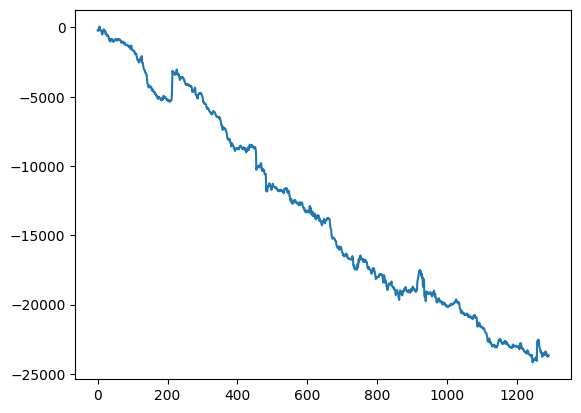

In [90]:
import matplotlib.pyplot as plt
equity_curve_arr = np.cumsum(all_arr)
plt.plot(equity_curve_arr);

In [97]:
import numpy as np
from numba import njit

@njit(cache=True)
def moving_percentile(arr, window, percentile):
    # Initialize the result array with NaNs (or you can use 999 for insufficient data if needed)
    result = np.full(len(arr), np.nan, dtype=arr.dtype)
    
    for i in range(len(arr)):
        if i + 1 >= window:
            # Calculate percentile for the current window
            window_values = arr[i + 1 - window:i + 1]
            result[i] = np.percentile(window_values, percentile * 100)
        else:
            result[i] = 999  # Not enough data to calculate the percentile

    return result

In [100]:
moving_percentile(arr=buy_idxs, window=14, percentile=0.25)

array([ 999,  999,  999,  999,  999,  999,  999,  999,  999,  999,  999,
        999,  999,  258,  288,  333,  384,  399,  438,  468,  489,  532,
        566,  615,  653,  703,  739,  800,  893,  922,  973, 1079, 1093,
       1130, 1156, 1177, 1203, 1247, 1313, 1345, 1368, 1403, 1448, 1484,
       1503, 1513, 1539, 1557, 1586, 1652, 1703, 1801, 1833, 1887, 1902,
       1956, 2063, 2084, 2135, 2160, 2203, 2309, 2433, 2453, 2475, 2518,
       2530, 2577, 2669, 2779, 2824, 2843, 2883, 2896, 2917, 2975, 3015,
       3097, 3118, 3132, 3143, 3153, 3167, 3217, 3306, 3386, 3415, 3489,
       3570, 3631, 3703, 3721, 3742, 3774, 3849, 3902, 3943, 3959, 4009,
       4092, 4120, 4164, 4178, 4209, 4249, 4294, 4362, 4425, 4435, 4455,
       4493, 4519, 4571, 4584, 4615, 4686, 4717, 4784, 4800, 4837, 4917,
       4926, 4940, 4969, 5008, 5024, 5059, 5129, 5140, 5154, 5175, 5201,
       5223, 5249, 5315, 5409, 5417, 5430, 5458, 5528, 5543, 5601, 5712,
       5856, 5897, 5958, 5964, 5976, 5993, 6063, 62

# Merging all data revised

In [1]:
import pandas as pd
from pathlib import Path

import warnings
warnings.filterwarnings('ignore')

# df = pd.read_csv(Path(r'C:/\Users/\vchar/\OneDrive/\Desktop/\ML Projects/\Upwork/\AlgoT_ML_Dev/\GrammarEvolution/\PonyGE2/\datasets/\all_data_1min.csv'))
df = pd.read_csv(Path(r'/\Users/\vchar/\OneDrive/\Desktop/\ML Projects/\Upwork/\AlgoT_ML_Dev/\GrammarEvolution/\PonyGE2/\all_data_1min.csv'))
df['datetime'] = pd.to_datetime(df['datetime'])
df.sort_values('datetime', ascending=True, inplace=True)
df.reset_index(inplace=True, drop=True)
df.head()

,datetime,btc_open,btc_high,btc_low,btc_close,btc_volume,6e_open,6e_high,6e_low,6e_close,...,zf_open,zf_high,zf_low,zf_close,zf_volume,zn_open,zn_high,zn_low,zn_close,zn_volume
0,2023-11-01 18:14:00,34553.59,34565.88,34546.16,34549.35,6.687855,1.0557,1.05570,1.05515,1.05520,...,104.867188,104.867188,104.843750,104.843750,1640.0,106.750000,106.765625,106.703125,106.703125,2238.0
1,2023-11-01 18:15:00,34549.33,34552.58,34507.30,34507.39,14.284419,1.0552,1.05530,1.05465,1.05465,...,104.843750,104.851562,104.828125,104.835938,6235.0,106.718750,106.734375,106.703125,106.703125,4672.0
2,2023-11-01 18:16:00,34507.49,34525.83,34486.81,34522.14,7.825300,1.0546,1.05505,1.05445,1.05505,...,104.835938,104.859375,104.835938,104.851562,2477.0,106.703125,106.734375,106.687500,106.734375,2382.0
3,2023-11-01 18:17:00,34522.14,34530.14,34500.18,34526.96,7.512638,1.0550,1.05525,1.05490,1.05515,...,104.851562,104.867188,104.843750,104.851562,3767.0,106.734375,106.750000,106.734375,106.750000,2937.0
4,2023-11-01 18:18:00,34526.20,34545.63,34525.18,34540.48,13.100650,1.0551,1.05535,1.05510,1.05530,...,104.851562,104.859375,104.851562,104.851562,1634.0,106.734375,106.750000,106.734375,106.734375,962.0


In [2]:
instrument_list = [col.split('_')[0] for col in df.columns if col.endswith('_open')]

In [3]:
from datetime import timedelta, datetime

print(df.shape)
df.set_index('datetime', inplace=True)

# Grouping by date
df['date'] = df.index.date
grouped = df.groupby('date')

df['weekend_date'] = df.index
df['weekend_date'] = df['weekend_date'].apply(lambda x: (x + timedelta(days=6 - x.weekday())).date())

df['month_date'] = df.index
df['month_date'] = df['month_date'].apply(
    lambda x: (
        datetime(x.year + int(x.month % 12 == 0), x.month % 12 + 1, 1) - timedelta(days=1)
    ).date()
)

for instrument in instrument_list:

    daily_data = df.resample('1D').agg({
        f'{instrument}_open': 'first',
        f'{instrument}_high': 'max',
        f'{instrument}_low': 'min',
        f'{instrument}_close': 'last',
        f'{instrument}_volume': 'sum'
    })

    weekly_data = df.resample('W').agg({
        f'{instrument}_open': 'first',
        f'{instrument}_high': 'max',
        f'{instrument}_low': 'min',
        f'{instrument}_close': 'last',
        f'{instrument}_volume': 'sum'
    })

    monthly_data = df.resample('ME').agg({
        f'{instrument}_open': 'first',
        f'{instrument}_high': 'max',
        f'{instrument}_low': 'min',
        f'{instrument}_close': 'last',
        f'{instrument}_volume': 'sum'
    })

    df[f'{instrument}_mean'] = (df[f'{instrument}_close'] + df[f'{instrument}_low'] + df[f'{instrument}_high'] + df[f'{instrument}_open']) / 4

    df[f'{instrument}_rmean_day'] = grouped[f'{instrument}_close'].transform(lambda x: x.shift(1).rolling(window=len(x), min_periods=1).mean())
    df[f'{instrument}_rhigh_day'] = grouped[f'{instrument}_high'].transform(lambda x: x.shift(1).rolling(window=len(x), min_periods=1).max())
    df[f'{instrument}_rlow_day'] = grouped[f'{instrument}_low'].transform(lambda x: x.shift(1).rolling(window=len(x), min_periods=1).min())
    df[f'{instrument}_rstd_day'] = grouped[f'{instrument}_close'].transform(lambda x: x.shift(1).rolling(window=len(x), min_periods=1).std())
    df[f'{instrument}_rvolume_day'] = grouped[f'{instrument}_volume'].transform(lambda x: x.shift(1).rolling(window=len(x), min_periods=1).sum())

    df[f'{instrument}_rmean_2h'] = df[f'{instrument}_close'].shift(1).rolling(window=120, min_periods=1).mean()
    df[f'{instrument}_rmax_2h'] = df[f'{instrument}_high'].shift(1).rolling(window=120, min_periods=1).max()
    df[f'{instrument}_rmin_2h'] = df[f'{instrument}_low'].shift(1).rolling(window=120, min_periods=1).min()
    df[f'{instrument}_rstd_2h'] = df[f'{instrument}_close'].shift(1).rolling(window=120, min_periods=1).std()
    df[f'{instrument}_rvolume_2h'] = df[f'{instrument}_volume'].shift(1).rolling(window=120, min_periods=1).sum()

    df[f'{instrument}_rmean_4h'] = df[f'{instrument}_close'].shift(1).rolling(window=240, min_periods=1).mean()
    df[f'{instrument}_rmax_4h'] = df[f'{instrument}_high'].shift(1).rolling(window=240, min_periods=1).max()
    df[f'{instrument}_rmin_4h'] = df[f'{instrument}_low'].shift(1).rolling(window=240, min_periods=1).min()
    df[f'{instrument}_rstd_4h'] = df[f'{instrument}_close'].shift(1).rolling(window=240, min_periods=1).std()
    df[f'{instrument}_rvolume_4h'] = df[f'{instrument}_volume'].shift(1).rolling(window=240, min_periods=1).sum()

    df[f'{instrument}_rmean_1h'] = df[f'{instrument}_close'].shift(1).rolling(window=60, min_periods=1).mean()
    df[f'{instrument}_rmax_1h'] = df[f'{instrument}_high'].shift(1).rolling(window=60, min_periods=1).max()
    df[f'{instrument}_rmin_1h'] = df[f'{instrument}_low'].shift(1).rolling(window=60, min_periods=1).min()
    df[f'{instrument}_rstd_1h'] = df[f'{instrument}_close'].shift(1).rolling(window=60, min_periods=1).std()
    df[f'{instrument}_rvolume_1h'] = df[f'{instrument}_volume'].shift(1).rolling(window=60, min_periods=1).sum()
    
    daily_cols = []
    weekly_cols = []
    monthly_cols = []

    for col in ['high', 'low', 'open', 'close', 'volume']:

        for n_lag in [1, 3, 5]:
            daily_data[f'{instrument}_{col}_{n_lag}d_ago'] = daily_data[f'{instrument}_{col}'].shift(n_lag)
            daily_cols.append(f'{instrument}_{col}_{n_lag}d_ago')

        weekly_data[f'{instrument}_{col}_1w_ago'] = weekly_data[f'{instrument}_{col}'].shift(1)
        weekly_cols.append(f'{instrument}_{col}_1w_ago')

        monthly_data[f'{instrument}_{col}_1m_ago'] = monthly_data[f'{instrument}_{col}'].shift(1)
        monthly_cols.append(f'{instrument}_{col}_1m_ago')

    daily_data = daily_data[daily_cols].reset_index()
    weekly_data = weekly_data[weekly_cols].reset_index()
    monthly_data = monthly_data[monthly_cols].reset_index()

    daily_map_dict = daily_data.set_index('datetime').to_dict()
    for k in daily_map_dict.keys():
        df[k] = df['date'].map(daily_map_dict[k])

    weekly_map_dict = weekly_data.set_index('datetime').to_dict()
    for k in weekly_map_dict.keys():
        df[k] = df['weekend_date'].map(weekly_map_dict[k])

    monthly_map_dict = monthly_data.set_index('datetime').to_dict()
    for k in monthly_map_dict.keys():
        df[k] = df['month_date'].map(monthly_map_dict[k])

df.drop(columns=['date', 'weekend_date', 'month_date'], inplace=True)
df.dropna(inplace=True)
df.reset_index(inplace=True)
print(df.shape)
df.columns

(457520, 131)
(414836, 1326)


Index(['btc_open', 'btc_high', 'btc_low', 'btc_close', 'btc_volume', '6e_open',
       '6e_high', '6e_low', '6e_close', '6e_volume',
       ...
       'zn_high_1w_ago', 'zn_low_1w_ago', 'zn_open_1w_ago', 'zn_close_1w_ago',
       'zn_volume_1w_ago', 'zn_high_1m_ago', 'zn_low_1m_ago', 'zn_open_1m_ago',
       'zn_close_1m_ago', 'zn_volume_1m_ago'],
      dtype='object', length=1326)

In [4]:
df.isnull().sum().sum()

0

In [10]:
df.to_csv("all_data_1min.csv", index=False)

# Creating folds for 1 min data

In [ ]:
import pandas as pd
from pathlib import Path

df = pd.read_csv(Path(r'C:/\Users/\vchar/\OneDrive/\Desktop/\ML Projects/\Upwork/\AlgoT_ML_Dev/\GrammarEvolution/\PonyGE2/\all_data_1min_all.csv'))
df['datetime'] = pd.to_datetime(df['datetime'])
df.sort_values('datetime', ascending=True, inplace=True)
df.reset_index(inplace=True, drop=True)

df['week'] = df['datetime'].dt.isocalendar().week
df['year'] = df['datetime'].dt.year
df['year_week_id'] = df['year'].apply(str) + '_' + df['week'].apply(str)

year_week_list = list(df['year_week_id'].unique())
fold_id_list = [year_week_list[i:i+5] for i in range(0, len(year_week_list), 5) if len(year_week_list[i:i+5]) == 5]

for i in range(len(fold_id_list)):

    temp_df = df[df['year_week_id'].isin(fold_id_list[i])].copy()
    temp_df.sort_values('datetime', ascending=True, inplace=True)
    temp_df.reset_index(drop=True, inplace=True)
    temp_df.drop(columns=['week', 'year', 'year_week_id'], inplace=True)
    
    if not os.path.exists('data_folds_1min'):
        os.mkdir('data_folds_1min')

    temp_df.to_csv(f'data_folds_1min/data_fold{i+1}.csv', index=False)

# Changing the timeframes of the data

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import os
from tqdm import tqdm
import gc

In [49]:
main_path = Path(r'C:/\Users/\vchar/\Downloads/\FULL DATA LIBRARY')

files_list = os.listdir(main_path)
files_list

['6E_1m_databento_symbol_final_1min.csv',
 'AAPL_1m_databento.csv',
 'AAV-1m-1000wks-data.csv',
 'AMZN_1m_databento.csv',
 'BTC-1m-1000wks-data.csv',
 'CL_1m_databento_symbol_final_1min.csv',
 'COIN_1m_databento.csv',
 'DOG-1m-1000wks-data.csv',
 'ES_1m_databento_symbol_final_1min.csv',
 'ETH-1m-1000wks-data.csv_backup.csv',
 'FET-1m-1000wks-data.csv_backup.csv',
 'GC_1m_databento_symbol_final_1min.csv',
 'GOOGL_1m_databento.csv',
 'INJ-1m-1000wks-data.csv',
 'LIN-1m-1000wks-data.csv_backup.csv',
 'META_1m_databento.csv',
 'MSFT_1m_databento.csv',
 'NG_1m_databento_symbol_final_1min.csv',
 'NQ_1m_databento_symbol_final_1min.csv',
 'NVDA_1m_databento.csv',
 'PLTR_1m_databento.csv',
 'SOL-1m-1000wks-data.csv_backup.csv',
 'SUI-1m-1000wks-data.csv',
 'TIA-1m-1000wks-data.csv',
 'TSLA_1m_databento.csv',
 'XRP-1m-1000wks-data.csv',
 'ZF_1m_databento_symbol_final_1min.csv',
 'ZN_1m_databento_symbol_final_1min.csv']

In [3]:
instrument_name = files_list[4].replace('-', '_').split('_')[0].lower()

final_df_any = pd.read_csv(os.path.join(main_path, files_list[4]))
final_df_any['datetime'] = pd.to_datetime(final_df_any['datetime'])
final_df_any.set_index('datetime', inplace=True)
final_df_any = final_df_any.resample('5min').agg({
        'open': 'first',
        'high': 'max',
        'low': 'min',
        'close': 'last',
        'volume': 'sum'
    })
final_df_any.reset_index(inplace=True)

final_df_any.rename(
    columns={
        'open': f'{instrument_name}_open', 
        'close': f'{instrument_name}_close', 
        'low': f'{instrument_name}_low', 
        'high': f'{instrument_name}_high', 
        'volume': f'{instrument_name}_volume'
    },
    inplace=True
)

final_df_any.head()

,datetime,btc_open,btc_high,btc_low,btc_close,btc_volume
0,2015-07-20 21:35:00,277.98,277.99,277.97,277.97,1.501500
1,2015-07-20 21:40:00,277.98,278.00,277.98,277.99,17.756475
2,2015-07-20 21:45:00,278.00,278.00,277.98,277.99,13.655500
3,2015-07-20 21:50:00,277.98,278.00,277.92,277.94,12.433782
4,2015-07-20 21:55:00,278.00,278.00,277.95,278.00,13.913200


In [44]:
FREQUENCY = '1D'

instrument_name = files_list[4].replace('-', '_').split('_')[0].lower()

final_df_any = pd.read_csv(os.path.join(main_path, files_list[4]))
final_df_any['datetime'] = pd.to_datetime(final_df_any['datetime'])
final_df_any.sort_values('datetime', ascending=True, inplace=True)
final_df_any.set_index('datetime', inplace=True)
final_df_any = final_df_any.resample(FREQUENCY).agg({
        'open': 'first',
        'high': 'max',
        'low': 'min',
        'close': 'last',
        'volume': 'sum'
    })
# final_df_any.reset_index(inplace=True)

final_df_any.rename(
    columns={
        'open': f'{instrument_name}_open', 
        'close': f'{instrument_name}_close', 
        'low': f'{instrument_name}_low', 
        'high': f'{instrument_name}_high', 
        'volume': f'{instrument_name}_volume'
    },
    inplace=True
)

# final_df_any.set_index('datetime', inplace=True)
complete_time_index = pd.date_range(start=final_df_any.index.min(), end=final_df_any.index.max(), freq=FREQUENCY)
final_df_any = final_df_any.reindex(complete_time_index)
final_df_any = final_df_any.ffill()
final_df_any.reset_index(inplace=True)
final_df_any.rename(columns={'index': 'datetime'}, inplace=True)

for i in tqdm(range(len(files_list))):

    if i in [4, 9, 21]:
        if i != 4:
            print(f"{files_list[i]} doesn't contain overlapping data.")
        continue
    
    instrument_name = files_list[i].replace('-', '_').split('_')[0].lower()

    temp_df = pd.read_csv(os.path.join(main_path, files_list[i]))
    temp_df['datetime'] = pd.to_datetime(temp_df['datetime'])
    temp_df.sort_values('datetime', ascending=True, inplace=True)
    temp_df.set_index('datetime', inplace=True)
    temp_df = temp_df.resample(FREQUENCY).agg({
            'open': 'first',
            'high': 'max',
            'low': 'min',
            'close': 'last',
            'volume': 'sum'
        })
    temp_df.reset_index(inplace=True)
    temp_df.rename(
        columns={
            'open': f'{instrument_name}_open', 
            'close': f'{instrument_name}_close', 
            'low': f'{instrument_name}_low', 
            'high': f'{instrument_name}_high', 
            'volume': f'{instrument_name}_volume'
        },
        inplace=True
    )
    # print(f"{i}: {files_list[i]}: start_date = {temp_df.iloc[0]['datetime']} end_date = {temp_df.iloc[-1]['datetime']}")
    # if i == 0:
    #     final_df_any = temp_df.copy()
    # else:
    #     final_df_any = pd.merge(final_df_any, temp_df, on='datetime')
    # temp_df.ffill(inplace=True)
    final_df_any = pd.merge(final_df_any, temp_df, on='datetime', how='left')
    final_df_any.ffill(inplace=True)

    if final_df_any.shape[0] == 0:
        print(i)

    del temp_df

    gc.collect()

 32%|███▏      | 9/28 [00:13<00:32,  1.70s/it]

ETH-1m-1000wks-data.csv_backup.csv doesn't contain overlapping data.


 75%|███████▌  | 21/28 [00:29<00:09,  1.30s/it]

SOL-1m-1000wks-data.csv_backup.csv doesn't contain overlapping data.


100%|██████████| 28/28 [00:37<00:00,  1.35s/it]


In [45]:
print(final_df_any.shape)
final_df_any.dropna(inplace=True)
final_df_any.reset_index(drop=True, inplace=True)
final_df_any.shape

(3345, 131)


(319, 131)

In [46]:
(final_df_any['datetime'].diff().apply(lambda x: x if pd.isna(x) else x.total_seconds()/60) != 5).sum()

319

In [47]:
final_df_any.head()

,datetime,btc_open,btc_high,btc_low,btc_close,btc_volume,6e_open,6e_high,6e_low,6e_close,...,zf_open,zf_high,zf_low,zf_close,zf_volume,zn_open,zn_high,zn_low,zn_close,zn_volume
0,2023-11-01,34656.38,35647.19,34079.46,35440.10,16196.302638,1.0598,1.06060,1.05365,1.06055,...,104.367188,105.265625,104.343750,105.226562,1638972.0,105.921875,107.390625,105.859375,107.328125,2517584.0
1,2023-11-02,35440.10,35997.80,34311.73,34950.00,13455.655270,1.0606,1.06865,1.06025,1.06340,...,105.226562,105.484375,105.062500,105.109375,1587834.0,107.312500,107.875000,107.078125,107.421875,2162119.0
2,2023-11-03,34947.92,34954.60,34100.00,34731.27,13961.700145,1.0634,1.07655,1.06330,1.07505,...,105.117188,106.000000,105.070312,105.734375,1821627.0,107.421875,108.781250,107.390625,108.250000,2599995.0
3,2023-11-04,34730.32,35278.40,34599.85,35087.01,4696.701483,1.0634,1.07655,1.06330,1.07505,...,105.117188,106.000000,105.070312,105.734375,0.0,107.421875,108.781250,107.390625,108.250000,0.0
4,2023-11-05,35087.43,35410.00,34500.00,35035.42,5796.961673,1.0747,1.07520,1.07420,1.07495,...,105.726562,105.734375,105.656250,105.656250,11787.0,108.234375,108.234375,108.125000,108.140625,19554.0


In [48]:
final_df_any.to_csv(f'data_{FREQUENCY}.csv', index=False)

# Generating strategies for testing from KJD book

In [ ]:
import pandas as pd
from tqdm import tqdm

inds_params = [5, 10, 14, 30, 50, 65]
filters_params = [100, 150, 200, 250, 300, 350]

buy_strs = []
sell_strs = []

for i in tqdm(range(len(inds_params))):

    for j in range(len(filters_params)):


        window1 = inds_params[i]
        window2 = filters_params[j]
        lag1 = inds_params[i]
        lag2 = filters_params[j]

        buy_txt = f'''(price_data['btc_close'][MAX_LAG:] == signals.moving_max(price_data['btc_close'], window={window1})[MAX_LAG:])
(price_data['btc_close'][MAX_LAG:] == signals.moving_min(price_data['btc_close'], window={window1})[MAX_LAG:])
(numba_indicators.relative_strength_index(prices=price_data['btc_close'], window={window1})[MAX_LAG:] < 30)
(numba_indicators.relative_strength_index(prices=price_data['btc_close'], window={window1})[MAX_LAG:] > 70)
(price_data['btc_close'][MAX_LAG:] > get_lag(price_data['btc_close'], lag={lag1})[MAX_LAG:])
(price_data['btc_close'][MAX_LAG:] < get_lag(price_data['btc_close'], lag={lag1})[MAX_LAG:])
(price_data['btc_close'][MAX_LAG:] > numba_indicators.moving_average(prices=price_data['btc_close'], window={window1})[MAX_LAG:])
(price_data['btc_close'][MAX_LAG:] < numba_indicators.moving_average(prices=price_data['btc_close'], window={window1})[MAX_LAG:])
((price_data['btc_close'][MAX_LAG:] == signals.moving_max(price_data['btc_close'], window={window1})[MAX_LAG:]) & (price_data['btc_close'][MAX_LAG:] > numba_indicators.moving_average(prices=price_data['btc_close'], window={window2})[MAX_LAG:]))
((price_data['btc_close'][MAX_LAG:] == signals.moving_min(price_data['btc_close'], window={window1})[MAX_LAG:]) & (price_data['btc_close'][MAX_LAG:] > numba_indicators.moving_average(prices=price_data['btc_close'], window={window2})[MAX_LAG:]))
((numba_indicators.relative_strength_index(prices=price_data['btc_close'], window={window1})[MAX_LAG:] < 30) & (price_data['btc_close'][MAX_LAG:] > numba_indicators.moving_average(prices=price_data['btc_close'], window={window2})[MAX_LAG:]))
((numba_indicators.relative_strength_index(prices=price_data['btc_close'], window={window1})[MAX_LAG:] > 70) & (price_data['btc_close'][MAX_LAG:] > numba_indicators.moving_average(prices=price_data['btc_close'], window={window2})[MAX_LAG:]))
((price_data['btc_close'][MAX_LAG:] > get_lag(price_data['btc_close'], lag={lag1})[MAX_LAG:]) & (price_data['btc_close'][MAX_LAG:] > numba_indicators.moving_average(prices=price_data['btc_close'], window={window2})[MAX_LAG:]))
((price_data['btc_close'][MAX_LAG:] < get_lag(price_data['btc_close'], lag={lag1})[MAX_LAG:]) & (price_data['btc_close'][MAX_LAG:] > numba_indicators.moving_average(prices=price_data['btc_close'], window={window2})[MAX_LAG:]))
((price_data['btc_close'][MAX_LAG:] > numba_indicators.moving_average(prices=price_data['btc_close'], window={window1})[MAX_LAG:]) & (price_data['btc_close'][MAX_LAG:] > numba_indicators.moving_average(prices=price_data['btc_close'], window={window2})[MAX_LAG:]))
((price_data['btc_close'][MAX_LAG:] < numba_indicators.moving_average(prices=price_data['btc_close'], window={window1})[MAX_LAG:]) & (price_data['btc_close'][MAX_LAG:] > numba_indicators.moving_average(prices=price_data['btc_close'], window={window2})[MAX_LAG:]))
((price_data['btc_close'][MAX_LAG:] == signals.moving_max(price_data['btc_close'], window={window1})[MAX_LAG:]) & (price_data['btc_close'][MAX_LAG:] > get_lag(price_data['btc_close'], lag={lag2})[MAX_LAG:]))
((price_data['btc_close'][MAX_LAG:] == signals.moving_min(price_data['btc_close'], window={window1})[MAX_LAG:]) & (price_data['btc_close'][MAX_LAG:] > get_lag(price_data['btc_close'], lag={lag2})[MAX_LAG:]))
((numba_indicators.relative_strength_index(prices=price_data['btc_close'], window={window1})[MAX_LAG:] < 30) & (price_data['btc_close'][MAX_LAG:] > get_lag(price_data['btc_close'], lag={lag2})[MAX_LAG:]))
((numba_indicators.relative_strength_index(prices=price_data['btc_close'], window={window1})[MAX_LAG:] > 70) & (price_data['btc_close'][MAX_LAG:] > get_lag(price_data['btc_close'], lag={lag2})[MAX_LAG:]))
((price_data['btc_close'][MAX_LAG:] > get_lag(price_data['btc_close'], lag={lag1})[MAX_LAG:]) & (price_data['btc_close'][MAX_LAG:] > get_lag(price_data['btc_close'], lag={lag2})[MAX_LAG:]))
((price_data['btc_close'][MAX_LAG:] < get_lag(price_data['btc_close'], lag={lag1})[MAX_LAG:]) & (price_data['btc_close'][MAX_LAG:] > get_lag(price_data['btc_close'], lag={lag2})[MAX_LAG:]))
((price_data['btc_close'][MAX_LAG:] > numba_indicators.moving_average(prices=price_data['btc_close'], window={window1})[MAX_LAG:]) & (price_data['btc_close'][MAX_LAG:] > get_lag(price_data['btc_close'], lag={lag2})[MAX_LAG:]))
((price_data['btc_close'][MAX_LAG:] < numba_indicators.moving_average(prices=price_data['btc_close'], window={window1})[MAX_LAG:]) & (price_data['btc_close'][MAX_LAG:] > get_lag(price_data['btc_close'], lag={lag2})[MAX_LAG:]))
((price_data['btc_close'][MAX_LAG:] == signals.moving_max(price_data['btc_close'], window={window1})[MAX_LAG:]) & (numba_indicators.adx(high=price_data['btc_high'], low=price_data['btc_low'], close=price_data['btc_close'], window={window2})[MAX_LAG:] > 15))
((price_data['btc_close'][MAX_LAG:] == signals.moving_min(price_data['btc_close'], window={window1})[MAX_LAG:]) & (numba_indicators.adx(high=price_data['btc_high'], low=price_data['btc_low'], close=price_data['btc_close'], window={window2})[MAX_LAG:] > 15))
((numba_indicators.relative_strength_index(prices=price_data['btc_close'], window={window1})[MAX_LAG:] < 30) & (numba_indicators.adx(high=price_data['btc_high'], low=price_data['btc_low'], close=price_data['btc_close'], window={window2})[MAX_LAG:] > 15))
((numba_indicators.relative_strength_index(prices=price_data['btc_close'], window={window1})[MAX_LAG:] > 70) & (numba_indicators.adx(high=price_data['btc_high'], low=price_data['btc_low'], close=price_data['btc_close'], window={window2})[MAX_LAG:] > 15))
((price_data['btc_close'][MAX_LAG:] > get_lag(price_data['btc_close'], lag={lag1})[MAX_LAG:]) & (numba_indicators.adx(high=price_data['btc_high'], low=price_data['btc_low'], close=price_data['btc_close'], window={window2})[MAX_LAG:] > 15))
((price_data['btc_close'][MAX_LAG:] < get_lag(price_data['btc_close'], lag={lag1})[MAX_LAG:]) & (numba_indicators.adx(high=price_data['btc_high'], low=price_data['btc_low'], close=price_data['btc_close'], window={window2})[MAX_LAG:] > 15))
((price_data['btc_close'][MAX_LAG:] > numba_indicators.moving_average(prices=price_data['btc_close'], window={window1})[MAX_LAG:]) & (numba_indicators.adx(high=price_data['btc_high'], low=price_data['btc_low'], close=price_data['btc_close'], window={window2})[MAX_LAG:] > 15))
((price_data['btc_close'][MAX_LAG:] < numba_indicators.moving_average(prices=price_data['btc_close'], window={window1})[MAX_LAG:]) & (numba_indicators.adx(high=price_data['btc_high'], low=price_data['btc_low'], close=price_data['btc_close'], window={window2})[MAX_LAG:] > 15))
((price_data['btc_close'][MAX_LAG:] == signals.moving_max(price_data['btc_close'], window={window1})[MAX_LAG:]) & (numba_indicators.relative_strength_index(prices=price_data['btc_close'], window={window2})[MAX_LAG:] < 70))
((price_data['btc_close'][MAX_LAG:] == signals.moving_min(price_data['btc_close'], window={window1})[MAX_LAG:]) & (numba_indicators.relative_strength_index(prices=price_data['btc_close'], window={window2})[MAX_LAG:] < 70))
((numba_indicators.relative_strength_index(prices=price_data['btc_close'], window={window1})[MAX_LAG:] < 30) & (numba_indicators.relative_strength_index(prices=price_data['btc_close'], window={window2})[MAX_LAG:] < 70))
((numba_indicators.relative_strength_index(prices=price_data['btc_close'], window={window1})[MAX_LAG:] > 70) & (numba_indicators.relative_strength_index(prices=price_data['btc_close'], window={window2})[MAX_LAG:] < 70))
((price_data['btc_close'][MAX_LAG:] > get_lag(price_data['btc_close'], lag={lag1})[MAX_LAG:]) & (numba_indicators.relative_strength_index(prices=price_data['btc_close'], window={window2})[MAX_LAG:] < 70))
((price_data['btc_close'][MAX_LAG:] < get_lag(price_data['btc_close'], lag={lag1})[MAX_LAG:]) & (numba_indicators.relative_strength_index(prices=price_data['btc_close'], window={window2})[MAX_LAG:] < 70))
((price_data['btc_close'][MAX_LAG:] > numba_indicators.moving_average(prices=price_data['btc_close'], window={window1})[MAX_LAG:]) & (numba_indicators.relative_strength_index(prices=price_data['btc_close'], window={window2})[MAX_LAG:] < 70))
((price_data['btc_close'][MAX_LAG:] < numba_indicators.moving_average(prices=price_data['btc_close'], window={window1})[MAX_LAG:]) & (numba_indicators.relative_strength_index(prices=price_data['btc_close'], window={window2})[MAX_LAG:] < 70))
((price_data['btc_close'][MAX_LAG:] == signals.moving_max(price_data['btc_close'], window={window1})[MAX_LAG:]) & (numba_indicators.rolling_max_index(price_data['btc_high'], window={window2})[MAX_LAG:] > numba_indicators.rolling_min_index(price_data['btc_low'], window={window2})[MAX_LAG:]))
((price_data['btc_close'][MAX_LAG:] == signals.moving_min(price_data['btc_close'], window={window1})[MAX_LAG:]) & (numba_indicators.rolling_max_index(price_data['btc_high'], window={window2})[MAX_LAG:] > numba_indicators.rolling_min_index(price_data['btc_low'], window={window2})[MAX_LAG:]))
((numba_indicators.relative_strength_index(prices=price_data['btc_close'], window={window1})[MAX_LAG:] < 30) & (numba_indicators.rolling_max_index(price_data['btc_high'], window={window2})[MAX_LAG:] > numba_indicators.rolling_min_index(price_data['btc_low'], window={window2})[MAX_LAG:]))
((numba_indicators.relative_strength_index(prices=price_data['btc_close'], window={window1})[MAX_LAG:] > 70) & (numba_indicators.rolling_max_index(price_data['btc_high'], window={window2})[MAX_LAG:] > numba_indicators.rolling_min_index(price_data['btc_low'], window={window2})[MAX_LAG:]))
((price_data['btc_close'][MAX_LAG:] > get_lag(price_data['btc_close'], lag={lag1})[MAX_LAG:]) & (numba_indicators.rolling_max_index(price_data['btc_high'], window={window2})[MAX_LAG:] > numba_indicators.rolling_min_index(price_data['btc_low'], window={window2})[MAX_LAG:]))
((price_data['btc_close'][MAX_LAG:] < get_lag(price_data['btc_close'], lag={lag1})[MAX_LAG:]) & (numba_indicators.rolling_max_index(price_data['btc_high'], window={window2})[MAX_LAG:] > numba_indicators.rolling_min_index(price_data['btc_low'], window={window2})[MAX_LAG:]))
((price_data['btc_close'][MAX_LAG:] > numba_indicators.moving_average(prices=price_data['btc_close'], window={window1})[MAX_LAG:]) & (numba_indicators.rolling_max_index(price_data['btc_high'], window={window2})[MAX_LAG:] > numba_indicators.rolling_min_index(price_data['btc_low'], window={window2})[MAX_LAG:]))
((price_data['btc_close'][MAX_LAG:] < numba_indicators.moving_average(prices=price_data['btc_close'], window={window1})[MAX_LAG:]) & (numba_indicators.rolling_max_index(price_data['btc_high'], window={window2})[MAX_LAG:] > numba_indicators.rolling_min_index(price_data['btc_low'], window={window2})[MAX_LAG:]))'''

        temp_buy_strs = buy_txt.split('\n')
        buy_strs.extend(temp_buy_strs)

        sell_txt = f'''(price_data['btc_close'][MAX_LAG:] == signals.moving_max(price_data['btc_close'], window={window1})[MAX_LAG:])
(price_data['btc_close'][MAX_LAG:] == signals.moving_min(price_data['btc_close'], window={window1})[MAX_LAG:])
(numba_indicators.relative_strength_index(prices=price_data['btc_close'], window={window1})[MAX_LAG:] < 30)
(numba_indicators.relative_strength_index(prices=price_data['btc_close'], window={window1})[MAX_LAG:] > 70)
(price_data['btc_close'][MAX_LAG:] > get_lag(price_data['btc_close'], lag={lag1})[MAX_LAG:])
(price_data['btc_close'][MAX_LAG:] < get_lag(price_data['btc_close'], lag={lag1})[MAX_LAG:])
(price_data['btc_close'][MAX_LAG:] > numba_indicators.moving_average(prices=price_data['btc_close'], window={window1})[MAX_LAG:])
(price_data['btc_close'][MAX_LAG:] < numba_indicators.moving_average(prices=price_data['btc_close'], window={window1})[MAX_LAG:])
((price_data['btc_close'][MAX_LAG:] == signals.moving_max(price_data['btc_close'], window={window1})[MAX_LAG:]) & (price_data['btc_close'][MAX_LAG:] < numba_indicators.moving_average(prices=price_data['btc_close'], window={window2})[MAX_LAG:]))
((price_data['btc_close'][MAX_LAG:] == signals.moving_min(price_data['btc_close'], window={window1})[MAX_LAG:]) & (price_data['btc_close'][MAX_LAG:] < numba_indicators.moving_average(prices=price_data['btc_close'], window={window2})[MAX_LAG:]))
((numba_indicators.relative_strength_index(prices=price_data['btc_close'], window={window1})[MAX_LAG:] < 30) & (price_data['btc_close'][MAX_LAG:] < numba_indicators.moving_average(prices=price_data['btc_close'], window={window2})[MAX_LAG:]))
((numba_indicators.relative_strength_index(prices=price_data['btc_close'], window={window1})[MAX_LAG:] > 70) & (price_data['btc_close'][MAX_LAG:] < numba_indicators.moving_average(prices=price_data['btc_close'], window={window2})[MAX_LAG:]))
((price_data['btc_close'][MAX_LAG:] > get_lag(price_data['btc_close'], lag={lag1})[MAX_LAG:]) & (price_data['btc_close'][MAX_LAG:] < numba_indicators.moving_average(prices=price_data['btc_close'], window={window2})[MAX_LAG:]))
((price_data['btc_close'][MAX_LAG:] < get_lag(price_data['btc_close'], lag={lag1})[MAX_LAG:]) & (price_data['btc_close'][MAX_LAG:] < numba_indicators.moving_average(prices=price_data['btc_close'], window={window2})[MAX_LAG:]))
((price_data['btc_close'][MAX_LAG:] > numba_indicators.moving_average(prices=price_data['btc_close'], window={window1})[MAX_LAG:]) & (price_data['btc_close'][MAX_LAG:] < numba_indicators.moving_average(prices=price_data['btc_close'], window={window2})[MAX_LAG:]))
((price_data['btc_close'][MAX_LAG:] < numba_indicators.moving_average(prices=price_data['btc_close'], window={window1})[MAX_LAG:]) & (price_data['btc_close'][MAX_LAG:] < numba_indicators.moving_average(prices=price_data['btc_close'], window={window2})[MAX_LAG:]))
((price_data['btc_close'][MAX_LAG:] == signals.moving_max(price_data['btc_close'], window={window1})[MAX_LAG:]) & (price_data['btc_close'][MAX_LAG:] < get_lag(price_data['btc_close'], lag={lag2})[MAX_LAG:]))
((price_data['btc_close'][MAX_LAG:] == signals.moving_min(price_data['btc_close'], window={window1})[MAX_LAG:]) & (price_data['btc_close'][MAX_LAG:] < get_lag(price_data['btc_close'], lag={lag2})[MAX_LAG:]))
((numba_indicators.relative_strength_index(prices=price_data['btc_close'], window={window1})[MAX_LAG:] < 30) & (price_data['btc_close'][MAX_LAG:] < get_lag(price_data['btc_close'], lag={lag2})[MAX_LAG:]))
((numba_indicators.relative_strength_index(prices=price_data['btc_close'], window={window1})[MAX_LAG:] > 70) & (price_data['btc_close'][MAX_LAG:] < get_lag(price_data['btc_close'], lag={lag2})[MAX_LAG:]))
((price_data['btc_close'][MAX_LAG:] > get_lag(price_data['btc_close'], lag={lag1})[MAX_LAG:]) & (price_data['btc_close'][MAX_LAG:] < get_lag(price_data['btc_close'], lag={lag2})[MAX_LAG:]))
((price_data['btc_close'][MAX_LAG:] < get_lag(price_data['btc_close'], lag={lag1})[MAX_LAG:]) & (price_data['btc_close'][MAX_LAG:] < get_lag(price_data['btc_close'], lag={lag2})[MAX_LAG:]))
((price_data['btc_close'][MAX_LAG:] > numba_indicators.moving_average(prices=price_data['btc_close'], window={window1})[MAX_LAG:]) & (price_data['btc_close'][MAX_LAG:] < get_lag(price_data['btc_close'], lag={lag2})[MAX_LAG:]))
((price_data['btc_close'][MAX_LAG:] < numba_indicators.moving_average(prices=price_data['btc_close'], window={window1})[MAX_LAG:]) & (price_data['btc_close'][MAX_LAG:] < get_lag(price_data['btc_close'], lag={lag2})[MAX_LAG:]))
((price_data['btc_close'][MAX_LAG:] == signals.moving_max(price_data['btc_close'], window={window1})[MAX_LAG:]) & (numba_indicators.adx(high=price_data['btc_high'], low=price_data['btc_low'], close=price_data['btc_close'], window={window2})[MAX_LAG:] > 15))
((price_data['btc_close'][MAX_LAG:] == signals.moving_min(price_data['btc_close'], window={window1})[MAX_LAG:]) & (numba_indicators.adx(high=price_data['btc_high'], low=price_data['btc_low'], close=price_data['btc_close'], window={window2})[MAX_LAG:] > 15))
((numba_indicators.relative_strength_index(prices=price_data['btc_close'], window={window1})[MAX_LAG:] < 30) & (numba_indicators.adx(high=price_data['btc_high'], low=price_data['btc_low'], close=price_data['btc_close'], window={window2})[MAX_LAG:] > 15))
((numba_indicators.relative_strength_index(prices=price_data['btc_close'], window={window1})[MAX_LAG:] > 70) & (numba_indicators.adx(high=price_data['btc_high'], low=price_data['btc_low'], close=price_data['btc_close'], window={window2})[MAX_LAG:] > 15))
((price_data['btc_close'][MAX_LAG:] > get_lag(price_data['btc_close'], lag={lag1})[MAX_LAG:]) & (numba_indicators.adx(high=price_data['btc_high'], low=price_data['btc_low'], close=price_data['btc_close'], window={window2})[MAX_LAG:] > 15))
((price_data['btc_close'][MAX_LAG:] < get_lag(price_data['btc_close'], lag={lag1})[MAX_LAG:]) & (numba_indicators.adx(high=price_data['btc_high'], low=price_data['btc_low'], close=price_data['btc_close'], window={window2})[MAX_LAG:] > 15))
((price_data['btc_close'][MAX_LAG:] > numba_indicators.moving_average(prices=price_data['btc_close'], window={window1})[MAX_LAG:]) & (numba_indicators.adx(high=price_data['btc_high'], low=price_data['btc_low'], close=price_data['btc_close'], window={window2})[MAX_LAG:] > 15))
((price_data['btc_close'][MAX_LAG:] < numba_indicators.moving_average(prices=price_data['btc_close'], window={window1})[MAX_LAG:]) & (numba_indicators.adx(high=price_data['btc_high'], low=price_data['btc_low'], close=price_data['btc_close'], window={window2})[MAX_LAG:] > 15))
((price_data['btc_close'][MAX_LAG:] == signals.moving_max(price_data['btc_close'], window={window1})[MAX_LAG:]) & (numba_indicators.relative_strength_index(prices=price_data['btc_close'], window={window2})[MAX_LAG:] > 30))
((price_data['btc_close'][MAX_LAG:] == signals.moving_min(price_data['btc_close'], window={window1})[MAX_LAG:]) & (numba_indicators.relative_strength_index(prices=price_data['btc_close'], window={window2})[MAX_LAG:] > 30))
((numba_indicators.relative_strength_index(prices=price_data['btc_close'], window={window1})[MAX_LAG:] < 30) & (numba_indicators.relative_strength_index(prices=price_data['btc_close'], window={window2})[MAX_LAG:] > 30))
((numba_indicators.relative_strength_index(prices=price_data['btc_close'], window={window1})[MAX_LAG:] > 70) & (numba_indicators.relative_strength_index(prices=price_data['btc_close'], window={window2})[MAX_LAG:] > 30))
((price_data['btc_close'][MAX_LAG:] > get_lag(price_data['btc_close'], lag={lag1})[MAX_LAG:]) & (numba_indicators.relative_strength_index(prices=price_data['btc_close'], window={window2})[MAX_LAG:] > 30))
((price_data['btc_close'][MAX_LAG:] < get_lag(price_data['btc_close'], lag={lag1})[MAX_LAG:]) & (numba_indicators.relative_strength_index(prices=price_data['btc_close'], window={window2})[MAX_LAG:] > 30))
((price_data['btc_close'][MAX_LAG:] > numba_indicators.moving_average(prices=price_data['btc_close'], window={window1})[MAX_LAG:]) & (numba_indicators.relative_strength_index(prices=price_data['btc_close'], window={window2})[MAX_LAG:] > 30))
((price_data['btc_close'][MAX_LAG:] < numba_indicators.moving_average(prices=price_data['btc_close'], window={window1})[MAX_LAG:]) & (numba_indicators.relative_strength_index(prices=price_data['btc_close'], window={window2})[MAX_LAG:] > 30))
((price_data['btc_close'][MAX_LAG:] == signals.moving_max(price_data['btc_close'], window={window1})[MAX_LAG:]) & (numba_indicators.rolling_max_index(price_data['btc_high'], window={window2})[MAX_LAG:] < numba_indicators.rolling_min_index(price_data['btc_low'], window={window2})[MAX_LAG:]))
((price_data['btc_close'][MAX_LAG:] == signals.moving_min(price_data['btc_close'], window={window1})[MAX_LAG:]) & (numba_indicators.rolling_max_index(price_data['btc_high'], window={window2})[MAX_LAG:] < numba_indicators.rolling_min_index(price_data['btc_low'], window={window2})[MAX_LAG:]))
((numba_indicators.relative_strength_index(prices=price_data['btc_close'], window={window1})[MAX_LAG:] < 30) & (numba_indicators.rolling_max_index(price_data['btc_high'], window={window2})[MAX_LAG:] < numba_indicators.rolling_min_index(price_data['btc_low'], window={window2})[MAX_LAG:]))
((numba_indicators.relative_strength_index(prices=price_data['btc_close'], window={window1})[MAX_LAG:] > 70) & (numba_indicators.rolling_max_index(price_data['btc_high'], window={window2})[MAX_LAG:] < numba_indicators.rolling_min_index(price_data['btc_low'], window={window2})[MAX_LAG:]))
((price_data['btc_close'][MAX_LAG:] > get_lag(price_data['btc_close'], lag={lag1})[MAX_LAG:]) & (numba_indicators.rolling_max_index(price_data['btc_high'], window={window2})[MAX_LAG:] < numba_indicators.rolling_min_index(price_data['btc_low'], window={window2})[MAX_LAG:]))
((price_data['btc_close'][MAX_LAG:] < get_lag(price_data['btc_close'], lag={lag1})[MAX_LAG:]) & (numba_indicators.rolling_max_index(price_data['btc_high'], window={window2})[MAX_LAG:] < numba_indicators.rolling_min_index(price_data['btc_low'], window={window2})[MAX_LAG:]))
((price_data['btc_close'][MAX_LAG:] > numba_indicators.moving_average(prices=price_data['btc_close'], window={window1})[MAX_LAG:]) & (numba_indicators.rolling_max_index(price_data['btc_high'], window={window2})[MAX_LAG:] < numba_indicators.rolling_min_index(price_data['btc_low'], window={window2})[MAX_LAG:]))
((price_data['btc_close'][MAX_LAG:] < numba_indicators.moving_average(prices=price_data['btc_close'], window={window1})[MAX_LAG:]) & (numba_indicators.rolling_max_index(price_data['btc_high'], window={window2})[MAX_LAG:] < numba_indicators.rolling_min_index(price_data['btc_low'], window={window2})[MAX_LAG:]))'''

        temp_sell_strs = sell_txt.split('\n')
        sell_strs.extend(temp_sell_strs)

df_test_str = pd.DataFrame()
df_test_str['buy'] = buy_strs
df_test_str['sell'] = sell_strs

df_test_str.to_csv('test_strategies.csv', index=False)

In [27]:
df_test_str.head()

,buy,sell
0,(price_data['btc_close'][MAX_LAG:] == signals....,(price_data['btc_close'][MAX_LAG:] == signals....
1,(price_data['btc_close'][MAX_LAG:] == signals....,(price_data['btc_close'][MAX_LAG:] == signals....
2,(numba_indicators.relative_strength_index(pric...,(numba_indicators.relative_strength_index(pric...
3,(numba_indicators.relative_strength_index(pric...,(numba_indicators.relative_strength_index(pric...
4,(price_data['btc_close'][MAX_LAG:] > get_lag(p...,(price_data['btc_close'][MAX_LAG:] > get_lag(p...


# Testing area

In [2]:
import pandas as pd
from pathlib import Path

df = pd.read_csv(Path(r'C:/\Users/\vchar/\OneDrive/\Desktop/\ML Projects/\Upwork/\AlgoT_ML_Dev/\GrammarEvolution/\PonyGE2/\all_data_1min_all.csv'))
df['datetime'] = pd.to_datetime(df['datetime'])
df.sort_values('datetime', ascending=True, inplace=True)
df.reset_index(inplace=True, drop=True)
df.head()

,datetime,btc_open,btc_high,btc_low,btc_close,btc_volume,6e_open,6e_high,6e_low,6e_close,...,zf_open,zf_high,zf_low,zf_close,zf_volume,zn_open,zn_high,zn_low,zn_close,zn_volume
0,2023-11-01 18:14:00,34553.59,34565.88,34546.16,34549.35,6.687855,1.0557,1.05570,1.05515,1.05520,...,104.867188,104.867188,104.843750,104.843750,1640.0,106.750000,106.765625,106.703125,106.703125,2238.0
1,2023-11-01 18:15:00,34549.33,34552.58,34507.30,34507.39,14.284419,1.0552,1.05530,1.05465,1.05465,...,104.843750,104.851562,104.828125,104.835938,6235.0,106.718750,106.734375,106.703125,106.703125,4672.0
2,2023-11-01 18:16:00,34507.49,34525.83,34486.81,34522.14,7.825300,1.0546,1.05505,1.05445,1.05505,...,104.835938,104.859375,104.835938,104.851562,2477.0,106.703125,106.734375,106.687500,106.734375,2382.0
3,2023-11-01 18:17:00,34522.14,34530.14,34500.18,34526.96,7.512638,1.0550,1.05525,1.05490,1.05515,...,104.851562,104.867188,104.843750,104.851562,3767.0,106.734375,106.750000,106.734375,106.750000,2937.0
4,2023-11-01 18:18:00,34526.20,34545.63,34525.18,34540.48,13.100650,1.0551,1.05535,1.05510,1.05530,...,104.851562,104.859375,104.851562,104.851562,1634.0,106.734375,106.750000,106.734375,106.734375,962.0


In [7]:
df.iloc[252000: (252000+50400)].shape

(50400, 131)

In [8]:
df.iloc[252000: (252000+50400)].to_csv("all_data_1min.csv", index=False)

In [2]:
df.shape

(414836, 1327)

In [2]:
import polars as pl
from pathlib import Path

df_pl = pl.read_csv(Path(r'/\Users/\vchar/\OneDrive/\Desktop/\ML Projects/\Upwork/\AlgoT_ML_Dev/\GrammarEvolution/\PonyGE2/\all_data_1min.csv'))
df_pl = df_pl.with_columns(pl.col('datetime').str.to_datetime())
df_pl = df_pl.sort('datetime', descending=False)
df_pl.head()

datetime,btc_open,btc_high,btc_low,btc_close,btc_volume,6e_open,6e_high,6e_low,6e_close,6e_volume,aapl_open,aapl_high,aapl_low,aapl_close,aapl_volume,aav_open,aav_high,aav_low,aav_close,aav_volume,amzn_open,amzn_high,amzn_low,amzn_close,amzn_volume,cl_open,cl_high,cl_low,cl_close,cl_volume,coin_open,coin_high,coin_low,coin_close,coin_volume,dog_open,…,zn_rstd_2h,zn_rvolume_2h,zn_rmean_4h,zn_rmax_4h,zn_rmin_4h,zn_rstd_4h,zn_rvolume_4h,zn_rmean_1h,zn_rmax_1h,zn_rmin_1h,zn_rstd_1h,zn_rvolume_1h,zn_high_1d_ago,zn_high_3d_ago,zn_high_5d_ago,zn_low_1d_ago,zn_low_3d_ago,zn_low_5d_ago,zn_open_1d_ago,zn_open_3d_ago,zn_open_5d_ago,zn_close_1d_ago,zn_close_3d_ago,zn_close_5d_ago,zn_volume_1d_ago,zn_volume_3d_ago,zn_volume_5d_ago,zn_high_1w_ago,zn_low_1w_ago,zn_open_1w_ago,zn_close_1w_ago,zn_volume_1w_ago,zn_high_1m_ago,zn_low_1m_ago,zn_open_1m_ago,zn_close_1m_ago,zn_volume_1m_ago
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2023-12-01 00:02:00,37725.87,37725.87,37700.0,37700.9,8.4220985,1.09,1.0901,1.08995,1.0901,6.0,190.06,190.06,190.06,190.06,1.0,98.2,98.2,98.09,98.13,11.696,145.93,145.93,145.92,145.92,280.0,75.78,75.78,75.78,75.78,2.0,124.18,124.18,124.18,124.18,4.0,0.08339,…,0.060134,530.0,109.58112,110.03125,109.390625,0.100762,4024.0,109.683594,110.03125,109.609375,0.07422,466.0,110.09375,109.65625,108.484375,109.390625,108.796875,108.3125,109.984375,108.921875,108.453125,109.671875,109.625,108.328125,56253.0,1.142538e6,4.682008e6,109.265625,108.3125,108.65625,108.328125,1.6199495e7,110.125,106.578125,106.75,109.671875,6.1111728e7
2023-12-01 00:03:00,37700.87,37708.29,37700.87,37704.84,5.054187,1.09005,1.0901,1.09005,1.09005,54.0,190.06,190.06,190.06,190.06,1.0,98.1,98.14,98.1,98.13,12.509,145.93,145.93,145.92,145.92,280.0,75.77,75.79,75.77,75.78,3.0,124.18,124.18,124.18,124.18,4.0,0.08345,…,0.068535,808.0,109.583333,110.03125,109.390625,0.104397,4229.0,109.690365,110.03125,109.609375,0.085072,742.0,110.09375,109.65625,108.484375,109.390625,108.796875,108.3125,109.984375,108.921875,108.453125,109.671875,109.625,108.328125,56253.0,1.142538e6,4.682008e6,109.265625,108.3125,108.65625,108.328125,1.6199495e7,110.125,106.578125,106.75,109.671875,6.1111728e7
2023-12-01 00:04:00,37704.84,37704.85,37689.5,37694.05,8.9862729,1.09005,1.0901,1.09005,1.0901,75.0,190.06,190.06,190.06,190.06,1.0,98.14,98.14,98.09,98.09,16.145,145.93,145.93,145.92,145.92,280.0,75.78,75.79,75.78,75.79,11.0,124.18,124.18,124.18,124.18,4.0,0.08352,…,0.077144,2398.0,109.585547,110.046875,109.390625,0.108507,5756.0,109.697656,110.046875,109.609375,0.096053,2330.0,110.09375,109.65625,108.484375,109.390625,108.796875,108.3125,109.984375,108.921875,108.453125,109.671875,109.625,108.328125,56253.0,1.142538e6,4.682008e6,109.265625,108.3125,108.65625,108.328125,1.6199495e7,110.125,106.578125,106.75,109.671875,6.1111728e7
2023-12-01 00:05:00,37694.05,37708.74,37690.87,37704.13,17.602861,1.09015,1.09025,1.0901,1.09025,83.0,190.06,190.06,190.06,190.06,1.0,98.11,98.3,98.11,98.3,16.545,145.93,145.93,145.92,145.92,280.0,75.81,75.81,75.8,75.8,5.0,124.18,124.18,124.18,124.18,4.0,0.08354,…,0.084738,2400.0,109.58776,110.0625,109.390625,0.112423,5707.0,109.704948,110.0625,109.609375,0.10539,2330.0,110.09375,109.65625,108.484375,109.390625,108.796875,108.3125,109.984375,108.921875,108.453125,109.671875,109.625,108.328125,56253.0,1.142538e6,4.682008e6,109.265625,108.3125,108.65625,108.328125,1.6199495e7,110.125,106.578125,106.75,109.671875,6.1111728e7
2023-12-01 00:06:00,37704.13,37708.19,37704.12,37707.02,1.737424,1.0902,1.0902,1.09015,1.0902,10.0,190.06,190.06,190.06,190.06,1.0,98.11,98.3,98.11,98.3,16.545,145.93,145.93,145.92,145.92,280.0,75.82,75.82,75.82,75.82,5.0,124.18,124.18,124.18,124.18,4.0,0.08353,…,0.092694,2983.0,109.

In [34]:
df_pl.slice(-4).to_pandas()

,datetime,btc_open,btc_high,btc_low,btc_close,btc_volume,6e_open,6e_high,6e_low,6e_close,...,zn_high_1w_ago,zn_low_1w_ago,zn_open_1w_ago,zn_close_1w_ago,zn_volume_1w_ago,zn_high_1m_ago,zn_low_1m_ago,zn_open_1m_ago,zn_close_1m_ago,zn_volume_1m_ago
0,2024-09-14 11:30:00,59815.61,59825.88,59805.44,59813.19,0.866345,1.11185,1.11185,1.11175,1.11185,...,115.40625,113.375,113.578125,114.84375,14427365.0,115.109375,112.046875,112.125,113.09375,77381257.0
1,2024-09-14 11:31:00,59811.70,59827.60,59805.43,59827.18,2.052995,1.11185,1.11185,1.11175,1.11185,...,115.40625,113.375,113.578125,114.84375,14427365.0,115.109375,112.046875,112.125,113.09375,77381257.0
2,2024-09-14 11:32:00,59827.17,59833.78,59824.37,59831.64,1.489819,1.11185,1.11185,1.11175,1.11185,...,115.40625,113.375,113.578125,114.84375,14427365.0,115.109375,112.046875,112.125,113.09375,77381257.0
3,2024-09-14 11:33:00,59831.64,59836.10,59831.64,59836.10,0.078481,1.11185,1.11185,1.11175,1.11185,...,115.40625,113.375,113.578125,114.84375,14427365.0,115.109375,112.046875,112.125,113.09375,77381257.0


In [1]:
text = '''# # Set crossover probability.
# 'CROSSOVER_PROBABILITY': 0.75,
# # Prevents crossover from generating invalids.
# 'NO_CROSSOVER_INVALIDS': False,

# # Set mutation probability (None defaults to 1 over the length of
# # the genome for each codon)
# 'MUTATION_PROBABILITY': None,
# # Set number of mutation events
# 'MUTATION_EVENTS': 1,
# # Prevents mutation from generating invalids.
# 'NO_MUTATION_INVALIDS': False,

# # Set elite size.
# 'ELITE_SIZE': None,

# # Agent Size. Number of agents having their own copy of genetic material
# 'AGENT_SIZE': 100,
# # Interaction Probability: how frequently the agents can interaction with
# # each other
# 'INTERACTION_PROBABILITY': 0.5'''

print(text.lower())

# # set crossover probability.
# 'crossover_probability': 0.75,
# # prevents crossover from generating invalids.
# 'no_crossover_invalids': false,

# # set mutation probability (none defaults to 1 over the length of
# # the genome for each codon)
# 'mutation_probability': none,
# # set number of mutation events
# 'mutation_events': 1,
# # prevents mutation from generating invalids.
# 'no_mutation_invalids': false,

# # set elite size.
# 'elite_size': none,

# # agent size. number of agents having their own copy of genetic material
# 'agent_size': 100,
# # interaction probability: how frequently the agents can interaction with
# # each other
# 'interaction_probability': 0.5


In [13]:
7 * 60 * 24 * 5, 7 * 60 * 24 * 10, 7 * 60 * 24 * 15, 7 * 60 * 24 * 25, 7 * 60 * 24 * 30, 7 * 60 * 24 * 35, 7 * 60 * 24 * 40, 7 * 60 * 24 * 45, 414836

(50400, 100800, 151200, 252000, 302400, 352800, 403200, 453600, 414836)

In [14]:
7 * 60 * 24 * 25

252000

In [2]:
df = pd.read_csv(Path(r'C:/\Users/\vchar/\OneDrive/\Desktop/\ML Projects/\Upwork/\AlgoT_ML_Dev/\GrammarEvolution/\PonyGE2/\all_data_1min.csv'))
# df = pd.read_csv('/kaggle/input/btcusd-test/BTCUSD_ohlcv.csv')
# df = pd.read_csv('/kaggle/input/btcusd-test/BTC-ETH-1m.csv')
# df = pd.read_csv('/kaggle/input/btcusd-test/all_data_1min.csv')
df['datetime'] = pd.to_datetime(df['datetime'])
# df = df.iloc[-10080:]
# df = df.iloc[-525600:]
# df = df.iloc[252000: (252000+50400)]
df.sort_values('datetime', ascending=True, inplace=True)
df.reset_index(inplace=True, drop=True)
price_data = {}
# price_data['open'] = df['open'].values
# price_data['close'] = df['close'].values
# price_data['high'] = df['high'].values
# price_data['low'] = df['low'].values
# price_data['volume'] = df['volume'].values
for col in df.columns:
    if col == 'datetime':
        continue
    else:
        price_data[col] = df[col].values

In [ ]:
df

(457520, 131)

In [4]:
7 * 24 * 60 * 5

50400

In [7]:
df[df['datetime'].dt.dayofweek == 0].head()

,datetime,btc_open,btc_high,btc_low,btc_close,btc_volume,6e_open,6e_high,6e_low,6e_close,...,zf_open,zf_high,zf_low,zf_close,zf_volume,zn_open,zn_high,zn_low,zn_close,zn_volume
6106,2023-11-06 00:00:00,35035.79,35042.11,35009.03,35015.86,7.140489,1.07500,1.07505,1.07480,1.07480,...,105.648438,105.671875,105.648438,105.664062,484.0,108.140625,108.156250,108.140625,108.156250,405.0
6107,2023-11-06 00:01:00,35012.72,35012.72,34980.90,34985.74,11.882682,1.07475,1.07475,1.07465,1.07465,...,105.664062,105.664062,105.656250,105.664062,62.0,108.156250,108.156250,108.156250,108.156250,509.0
6108,2023-11-06 00:02:00,34984.82,35005.84,34950.98,34971.55,20.170384,1.07470,1.07485,1.07470,1.07485,...,105.664062,105.664062,105.656250,105.664062,143.0,108.156250,108.171875,108.156250,108.156250,1315.0
6109,2023-11-06 00:03:00,34969.70,34997.71,34961.29,34962.50,4.791926,1.07485,1.07485,1.07470,1.07470,...,105.664062,105.664062,105.648438,105.648438,201.0,108.156250,108.156250,108.140625,108.140625,358.0
6110,2023-11-06 00:04:00,34959.86,34986.90,34954.00,34983.92,11.766786,1.07465,1.07465,1.07450,1.07450,...,105.648438,105.648438,105.640625,105.640625,1060.0,108.140625,108.140625,108.125000,108.140625,1136.0


In [50]:
instrument_name = files_list[4].replace('-', '_').split('_')[0].lower()

temp_df = pd.read_csv(os.path.join(main_path, files_list[4]))
temp_df['datetime'] = pd.to_datetime(temp_df['datetime'])

temp_df.head()

,datetime,open,high,low,close,volume
0,2015-07-20 21:37:00,277.98,277.98,277.97,277.97,0.791300
1,2015-07-20 21:38:00,277.98,277.99,277.98,277.99,0.560600
2,2015-07-20 21:39:00,277.97,277.97,277.97,277.97,0.149600
3,2015-07-20 21:40:00,277.98,277.99,277.98,277.99,1.216800
4,2015-07-20 21:41:00,277.99,277.99,277.99,277.99,2.704924


In [3]:
df = pd.read_csv(Path(r'C:/\Users/\vchar/\OneDrive/\Desktop/\ML Projects/\Upwork/\AlgoT_ML_Dev/\GrammarEvolution/\PonyGE2/\all_data_1min.csv'))
df['datetime'] = pd.to_datetime(df['datetime'])
df.sort_values('datetime', ascending=True, inplace=True)
df.reset_index(inplace=True, drop=True)

price_data = {}
for col in df.columns:
    if col == 'datetime':
        continue
    else:
        price_data[col] = df[col].values

buy

In [23]:
6 * 6 * 48

1728

100%|██████████| 6/6 [00:00<00:00, 730.16it/s]

sell